In [1]:
# 유전 알고리즘을 활용한 머신러닝 입력 최적화 및 대안 제안 메소드
# Part 4. 인플루언서 YouTuber 되기 실습
# Fast Campus / (주)데이원컴퍼니

# **1. 모듈 설치 및 호출**

In [2]:
# !pip install geneticalgorithm

In [3]:
import copy
import math
import datetime
import itertools
import requests
from io import BytesIO
from random import randint

import chardet
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform
from xgboost import XGBRegressor
from geneticalgorithm import geneticalgorithm


pd.set_option('display.max_columns', None) #모든 열을 다 볼수 있게 한다.

# **2. 데이터 로드 및 탐색적 데이터 분석**

In [4]:
# KRvideos.csv 데이터 파일을 Colab에 업로드
# Data link: https://www.kaggle.com/datasnaek/youtube-new
# 여러 나라 data file중 한국 데이터 (KRvideos.csv) 사용

# from google.colab import files, drive
# file_uploaded = files.upload()

In [5]:
# Colab에 데이터 파일을 올려놓은 경우
# drive.mount('./content')
# ! ls /content

In [6]:
filename = 'KRvideos.csv'

with open(filename, 'rb') as f:
    result = chardet.detect(f.readline())
    print('Encoding type:', result['encoding'])

Encoding type: ascii


In [7]:
raw_data = pd.read_csv(filename, engine='python')
raw_data.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [8]:
# KR_category_id.json에서 가져옴
category_id_code = {'1': 'Film & Animation',
                    '2': 'Autos & Vehicles',
                    '10': 'Music',
                    '15': 'Pets & Animals',
                    '17': 'Sports',
                    '18': 'Short Movies',
                    '19': 'Travel & Events',
                    '20': 'Gaming',
                    '21': 'Videoblogging',
                    '22': 'People & Blogs',
                    '23': 'Comedy',
                    '24': 'Entertainment',
                    '25': 'News & Politics',
                    '26': 'Howto & Style',
                    '27': 'Education',
                    '28': 'Science & Technology',
                    '29': 'Nonprofits & Activism',
                    '30': 'Movies',
                    '31': 'Anime/Animation',
                    '32': 'Action/Adventure',
                    '33': 'Classics',
                    '34': 'Comedy',
                    '35': 'Documentary',
                    '36': 'Drama',
                    '37': 'Family',
                    '38': 'Foreign',                    
                    '39': 'Horror',
                    '40': 'Sci-Fi/Fantasy',
                    '41': 'Thriller',
                    '42': 'Shorts',
                    '43': 'Shows',
                    '44': 'Trailers'}

In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34567 entries, 0 to 34566
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                34567 non-null  object
 1   trending_date           34567 non-null  object
 2   title                   34567 non-null  object
 3   channel_title           34567 non-null  object
 4   category_id             34567 non-null  int64 
 5   publish_time            34567 non-null  object
 6   tags                    34567 non-null  object
 7   views                   34567 non-null  int64 
 8   likes                   34567 non-null  int64 
 9   dislikes                34567 non-null  int64 
 10  comment_count           34567 non-null  int64 
 11  thumbnail_link          34567 non-null  object
 12  comments_disabled       34567 non-null  bool  
 13  ratings_disabled        34567 non-null  bool  
 14  video_error_or_removed  34567 non-null  bool  
 15  de

In [10]:
raw_data['description'].isnull().sum()

3163

In [11]:
raw_data.isnull().sum()

video_id                     0
trending_date                0
title                        0
channel_title                0
category_id                  0
publish_time                 0
tags                         0
views                        0
likes                        0
dislikes                     0
comment_count                0
thumbnail_link               0
comments_disabled            0
ratings_disabled             0
video_error_or_removed       0
description               3163
dtype: int64

In [12]:
raw_data['comments_disabled'][raw_data['comments_disabled'] == True].sum()

511

In [13]:
raw_data['ratings_disabled'][raw_data['ratings_disabled'] == True].sum()

1400

In [14]:
raw_data['video_error_or_removed'][raw_data['video_error_or_removed'] == True].sum()

41

In [15]:
# df의 list는 컬럼으로 인식한다
list(raw_data) 

['video_id',
 'trending_date',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'thumbnail_link',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'description']

In [16]:
for i in list(raw_data):
    print(i)
    print(raw_data[i].duplicated().value_counts()) # 중복된수=True, 유니크한수=False
    print(len(raw_data[i].unique()))
    print('\n')

video_id
True     18691
False    15876
Name: video_id, dtype: int64
15876


trending_date
True     34362
False      205
Name: trending_date, dtype: int64
205


title
True     18214
False    16353
Name: title, dtype: int64
16353


channel_title
True     30524
False     4043
Name: channel_title, dtype: int64
4043


category_id
True     34550
False       17
Name: category_id, dtype: int64
17


publish_time
True     18705
False    15862
Name: publish_time, dtype: int64
15862


tags
True     23776
False    10791
Name: tags, dtype: int64
10791


views
False    30690
True      3877
Name: views, dtype: int64
30690


likes
True     25093
False     9474
Name: likes, dtype: int64
9474


dislikes
True     32492
False     2075
Name: dislikes, dtype: int64
2075


comment_count
True     29878
False     4689
Name: comment_count, dtype: int64
4689


thumbnail_link
True     18478
False    16089
Name: thumbnail_link, dtype: int64
16089


comments_disabled
True     34565
False        2
Name: comments_disa

In [17]:
df = raw_data[raw_data['comments_disabled'] != 1]
df = df[df['ratings_disabled'] != 1]
df = df[df['video_error_or_removed'] != 1]
df = df[df['tags'] != '[none]']
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [18]:
print('Before dropna:', len(df))
df = df.dropna()
print('After  dropna:', len(df))
df = df.reset_index(drop=True)

Before dropna: 26078
After  dropna: 24768


#**3. 피쳐 엔지니어링**

In [19]:
r_avg = []
g_avg = []
b_avg = []

for i in tqdm.tqdm(range(len(df))):
    url = df['thumbnail_link'][i]
    res = requests.get(url)
    request_get_img = Image.open(BytesIO(res.content))
    red, green, blue = request_get_img.split()

    r_avg.append(int(np.average(red)))
    g_avg.append(int(np.average(green)))
    b_avg.append(int(np.average(blue)))

df['r_avg'] = r_avg
df['g_avg'] = g_avg
df['b_avg'] = b_avg

100%|██████████████████████████████████████████████████████████████████████████| 24768/24768 [1:22:58<00:00,  4.97it/s]


In [20]:
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...,193,193,193
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61


In [21]:
check_table = df[df['r_avg'] == df['g_avg']]
check_table = check_table[check_table['g_avg'] == check_table['b_avg']]
print('len_check_table:', len(check_table))

print('Before removing non-thumbnail images:', len(df))
df_rgb = df[df['r_avg'] != 193]
print('After  removing non-thumbnail images:', len(df_rgb))
df_rgb = df_rgb.reset_index(drop=True)
df_rgb.to_csv('df_color_encode.csv', index_label=False)

len_check_table: 9928
Before removing non-thumbnail images: 24768
After  removing non-thumbnail images: 14957


In [22]:
# df_rgb = pd.read_csv('df_color_encode.csv')
print(df['video_id'].duplicated().value_counts())
df_rgb[df_rgb.duplicated('video_id')].sort_values(by='video_id')

True     13672
False    11096
Name: video_id, dtype: int64


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
2367,#NAME?,17.16.12,ENG 겨울에 하는 속촉촉 겉보송 메이크업 Winter Smooth Moisturi...,lamuqe,26,2017-12-15T09:08:23.000Z,"lamuqe|""lamuqe's magic up""|""라뮤끄""|""라뮤끄의 매직업""|""메...",119281,2979,59,335,https://i.ytimg.com/vi/-Bv81WPrGkU/default.jpg,False,False,False,🌷 instagram @lamuqe_magicup 🌷\n\n안녕하세요! 라뮤끄입니다...,37,31,30
10199,#NAME?,18.20.04,[중국황실마사지 ASMR] 중국 현지인 황실 마사지ㅣMINIYU的中国皇室按摩店。ㅣC...,Miniyu ASMR,22,2018-04-18T11:27:29.000Z,"asmr|""미니유""|""miniyuasmr""|""롤플레이""|""잠""|""불면증""|""role...",111006,3254,100,976,https://i.ytimg.com/vi/-PYI_P4j7D4/default.jpg,False,False,False,* ASMR 이란?\n(Autonomous sensory meridian respo...,101,67,60
13233,#NAME?,18.27.05,방탄소년단 - ANPANMAN (BTS - ANPANMAN) │BTS COMEBAC...,RT TV,22,2018-05-25T09:20:17.000Z,"bts anpanman reaction|""bts anpanman comeback s...",283730,9602,104,376,https://i.ytimg.com/vi/-qFrHv2XbBY/default.jpg,False,False,False,방탄소년단 - ANPANMAN (BTS - ANPANMAN) │BTS COMEBAC...,95,93,83
13217,#NAME?,18.27.05,총을 못 만지는 남자가 군대에 가서 보여준 기적적인 실화,미들뻔,1,2018-05-26T10:30:47.000Z,"미들뻔|""미드펀""|""미드뻔""|""미들펀""|""뻔펀""|""영화""|""영화 추천""|""영화 소개...",372222,3962,106,1292,https://i.ytimg.com/vi/-ArRPlpU9Tc/default.jpg,False,False,False,"안녕하세요, 미들뻔입니다.오늘 리뷰할 작품은 '핵소 고지(Hacksaw Ridge ...",73,69,55
4005,#NAME?,18.09.01,INFINITE(인피니트) 'Tell Me'(텔미) 무대 칼군무 공개 @Media ...,Vstar,24,2018-01-08T09:00:00.000Z,"Vstar|""성규""|""성종""|""성열""|""엘""|""우현""|""동우""|""인피니트""|""인피니...",107761,5361,38,374,https://i.ytimg.com/vi/-TmXKq_ulMg/default.jpg,False,False,False,"그룹 인피니트(성규, 성종, 성열, 엘, 우현, 동우)가 8일 오후, 서울 용산구 ...",67,58,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7686,zxjJLN12Ig0,18.09.03,[리플] 달달한 머랭쿠키 맨손으로 직접 만들어보았다! 이번에는 어떻게 망할까? | ...,Ripple_S,23,2018-03-07T10:30:02.000Z,"Ripple|""Ripple_S""|""Replay""|""리플즈""|""리플에스""|""리플레이""...",250100,3592,54,713,https://i.ytimg.com/vi/zxjJLN12Ig0/default.jpg,False,False,False,극한직업 리플PD...\n\n[Contents Awesome!]\n\n리플의 꿀잼 ...,125,129,127
7568,zxpH0ekLUHI,18.07.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",224813,8662,165,1019,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
7498,zxpH0ekLUHI,18.06.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",175110,7640,152,873,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
11347,zy9W8V1ICOw,18.05.05,【꽃핀】 자상무색 한국어 커버 (自傷無色 korean cover),꽃핀,10,2018-05-03T05:38:40.000Z,"꽃핀|""샌드박스""|""Jishou mushoku""|""자상무색""|""自傷無色""|""네코보로...",67169,3751,50,815,https://i.ytimg.com/vi/zy9W8V1ICOw/default.jpg,False,False,False,◕‿◕✿ 매월 마지막 날은 노래 업로드 하는 날~!● 원곡 : @nekobolo【初...,119,89,93


In [23]:
df_rgb[df_rgb['video_id']=='#NAME?']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
34,#NAME?,17.14.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",78134,3126,28,615,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
118,#NAME?,17.15.11,JSA 귀순 북한군 총격 부상,채널A 뉴스TOP10,43,2017-11-13T11:47:18.000Z,채널 A,85097,223,20,95,https://i.ytimg.com/vi/-yRXK7elKnU/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중\n[채널A단독]우리측 초...,76,83,92
158,#NAME?,17.15.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",84466,3226,30,630,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
159,#NAME?,17.15.11,Sau Ánh Hào Quang #7 FULL | Cát Phượng: Cái sa...,ĐÔNG TÂY PROMOTION OFFICIAL,24,2017-11-13T15:08:54.000Z,"sau anh hao quang|""sau ánh hào quang""|""sau anh...",1544710,12417,803,2186,https://i.ytimg.com/vi/-k6j6Dkyl1M/default.jpg,False,False,False,"sau anh hao quang, sau ánh hào quang, sau anh ...",97,82,84
207,#NAME?,17.16.11,171115 AAA 레드카펫 워너원 강다니엘 포커스 4K 직캠 / WANNAONE ...,Peach Crush,22,2017-11-15T08:29:30.000Z,"워너원|""강다니엘""|""직캠""|""AAA""|""레드카펫""|""WANNAONE""|""KANGD...",30451,1763,5,118,https://i.ytimg.com/vi/-krZhrUSEUU/default.jpg,False,False,False,B.G.M : Be there - 치즈\n\n출처 명시 및 로고 유지 하에 짤 생성...,101,105,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14729,#NAME?,18.12.06,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",RT TV,22,2018-06-11T06:39:01.000Z,"bts ddaeng|""bts rm suga j hope ddaeng""|""ddaeng...",114672,7056,44,588,https://i.ytimg.com/vi/-VCm09pywpc/default.jpg,False,False,False,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",112,100,92
14790,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14868,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14903,#NAME?,18.14.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",150166,691,31,112,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43


In [24]:
print('Before removing duplicated video_id:', len(df_rgb))
df_rgb2 = df_rgb.drop_duplicates('video_id')
print('After  removing duplicated video_id:', len(df_rgb2))
df_rgb2 = df_rgb2.reset_index(drop=True)

Before removing duplicated video_id: 14957
After  removing duplicated video_id: 6558


In [25]:
df_rgb2.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
2,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
3,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61
4,AmP0ryzDmbY,17.14.11,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 깜놀,하우스,25,2017-11-12T10:17:48.000Z,"김정숙|""김정숙 여사""|""김정숙 문재인""|""문재인 대통령""|""문재인""|""문재인 인도...",188707,545,311,357,https://i.ytimg.com/vi/AmP0ryzDmbY/default.jpg,False,False,False,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 ...,117,103,100


In [26]:
df_rgb2['publish_time2'] = df_rgb2['publish_time'].apply(lambda x: x.split('T')[0])
df_rgb2['publish_date'] = df_rgb2['publish_time2'].astype('datetime64[ns]')
df_rgb2['publish_date']

0      2017-11-13
1      2017-11-11
2      2017-11-12
3      2017-11-13
4      2017-11-12
          ...    
6553   2018-06-11
6554   2018-06-13
6555   2018-06-13
6556   2018-06-13
6557   2018-06-13
Name: publish_date, Length: 6558, dtype: datetime64[ns]

In [27]:
df_rgb2['trending_date'] = pd.to_datetime(df_rgb2['trending_date'], format="%y.%d.%m")
df_rgb2['trending_date']

0      2017-11-14
1      2017-11-14
2      2017-11-14
3      2017-11-14
4      2017-11-14
          ...    
6553   2018-06-14
6554   2018-06-14
6555   2018-06-14
6556   2018-06-14
6557   2018-06-14
Name: trending_date, Length: 6558, dtype: datetime64[ns]

In [28]:
df_rgb2['elapsed_day'] = df_rgb2['trending_date'] - df_rgb2['publish_date'] + datetime.timedelta(days=1)
df_rgb2['elapsed_day'] = df_rgb2['elapsed_day'].dt.days
df_rgb2['elapsed_day']

0       2
1       4
2       3
3       2
4       3
       ..
6553    4
6554    2
6555    2
6556    2
6557    2
Name: elapsed_day, Length: 6558, dtype: int64

In [29]:
df_rgb2['total_number_of_sign'] = df_rgb2['likes'] + df_rgb2['dislikes']

df_rgb2['number_of_tag'] = df_rgb2['tags'].apply(lambda x: len(x.split('|')) if x != '[none]' else 0)

df_rgb2['positive_ratio'] = df_rgb2['likes'] / df_rgb2['dislikes']

In [30]:
positive_ratio_max = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], 0).max() #의미파악

In [31]:
df_rgb2['positive_ratio'] = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], positive_ratio_max*1.5)

df_rgb2['sign_per_day'] = df_rgb2['total_number_of_sign'] / df_rgb2['elapsed_day']

df_rgb2['positive_ratio_per_day'] = df_rgb2['positive_ratio'] / df_rgb2['elapsed_day']

df_rgb2['comment_per_day'] = df_rgb2['comment_count'] / df_rgb2['elapsed_day']

df_rgb2['total_sign_comment_ratio'] = df_rgb2['total_number_of_sign'] / df_rgb2['comment_count']
total_sign_comment_ratio_max = df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], 0).max()
df_rgb2['total_sign_comment_ratio'] = \
    df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], total_sign_comment_ratio_max*1.5)

df_rgb2['description_length'] = df_rgb2['description'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

df_rgb2['title_length'] = df_rgb2['title'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

In [32]:
df_rgb2['channel_title'].value_counts()

TV Derana              103
JTBC News               90
황장수의 뉴스브리핑o             85
tbs 시민의 방송              83
o 황장수의 뉴스브리핑            76
                      ... 
DAY6 Japan Official      1
방탄저장소                    1
CELEB'S PICK             1
후니띠 · HooNi              1
딩고 스낵비디오                 1
Name: channel_title, Length: 1478, dtype: int64

In [33]:
# EA사용: mean_encode_channel 시리즈의 인덱스 숫자 입력
mean_encode_channel = df_rgb2.groupby('channel_title')['views'].mean()
print((mean_encode_channel.dtype))
print(mean_encode_channel)
print(len(mean_encode_channel))
# series.map(딕셔너리)
df_rgb2.loc[:, 'channel_title_mean_enc'] = df_rgb2['channel_title'].map(mean_encode_channel)
df_rgb2['channel_title_mean_enc']

float64
channel_title
!t Live                   64896.666667
& 홍대 쏭카페창현 거리노래방         150317.500000
(MUTUBE)와꾸대장봉준            72740.000000
* eundaromi              129207.500000
- 欢迎订阅 -浙江卫视【奔跑吧】官方频道    799644.000000
                             ...      
흔한남매                     104829.000000
히스토리                     230128.000000
히죽HIZUK                   77737.000000
히히튜브                      29389.000000
힙합버스                      99130.500000
Name: views, Length: 1478, dtype: float64


0       125208.000000
1       421409.000000
2       258691.285714
3       184936.645161
4       178386.071429
            ...      
6553     15136.500000
6554     41945.444444
6555     31731.500000
6556     23404.000000
6557    140520.189655
Name: channel_title_mean_enc, Length: 6558, dtype: float64

In [34]:
df_rgb2['category_id'].value_counts()

24    1854
25    1233
22     869
23     506
10     475
20     443
1      348
15     193
17     176
26     171
27      88
43      69
29      67
2       25
28      23
19      18
Name: category_id, dtype: int64

In [35]:
# EA에 사용됨. music 카테고리는 2번임. 
mean_encode_category = df_rgb2.groupby('category_id')['views'].mean()
print(mean_encode_category)

df_rgb2.loc[:, 'category_id_mean_enc'] = df_rgb2['category_id'].map(mean_encode_category)
df_rgb2['category_id_mean_enc']

category_id
1     3.975242e+05
2     9.113464e+04
10    1.553969e+06
15    1.191287e+05
17    7.371396e+05
19    2.021387e+05
20    1.985810e+05
22    1.481176e+05
23    2.772646e+05
24    4.091292e+05
25    1.309392e+05
26    3.624022e+05
27    9.829427e+04
28    1.678646e+06
29    2.332710e+04
43    7.884158e+04
Name: views, dtype: float64


0       148117.575374
1       148117.575374
2       130939.165450
3       130939.165450
4       130939.165450
            ...      
6553    737139.551136
6554    148117.575374
6555    409129.173679
6556    397524.198276
6557    130939.165450
Name: category_id_mean_enc, Length: 6558, dtype: float64

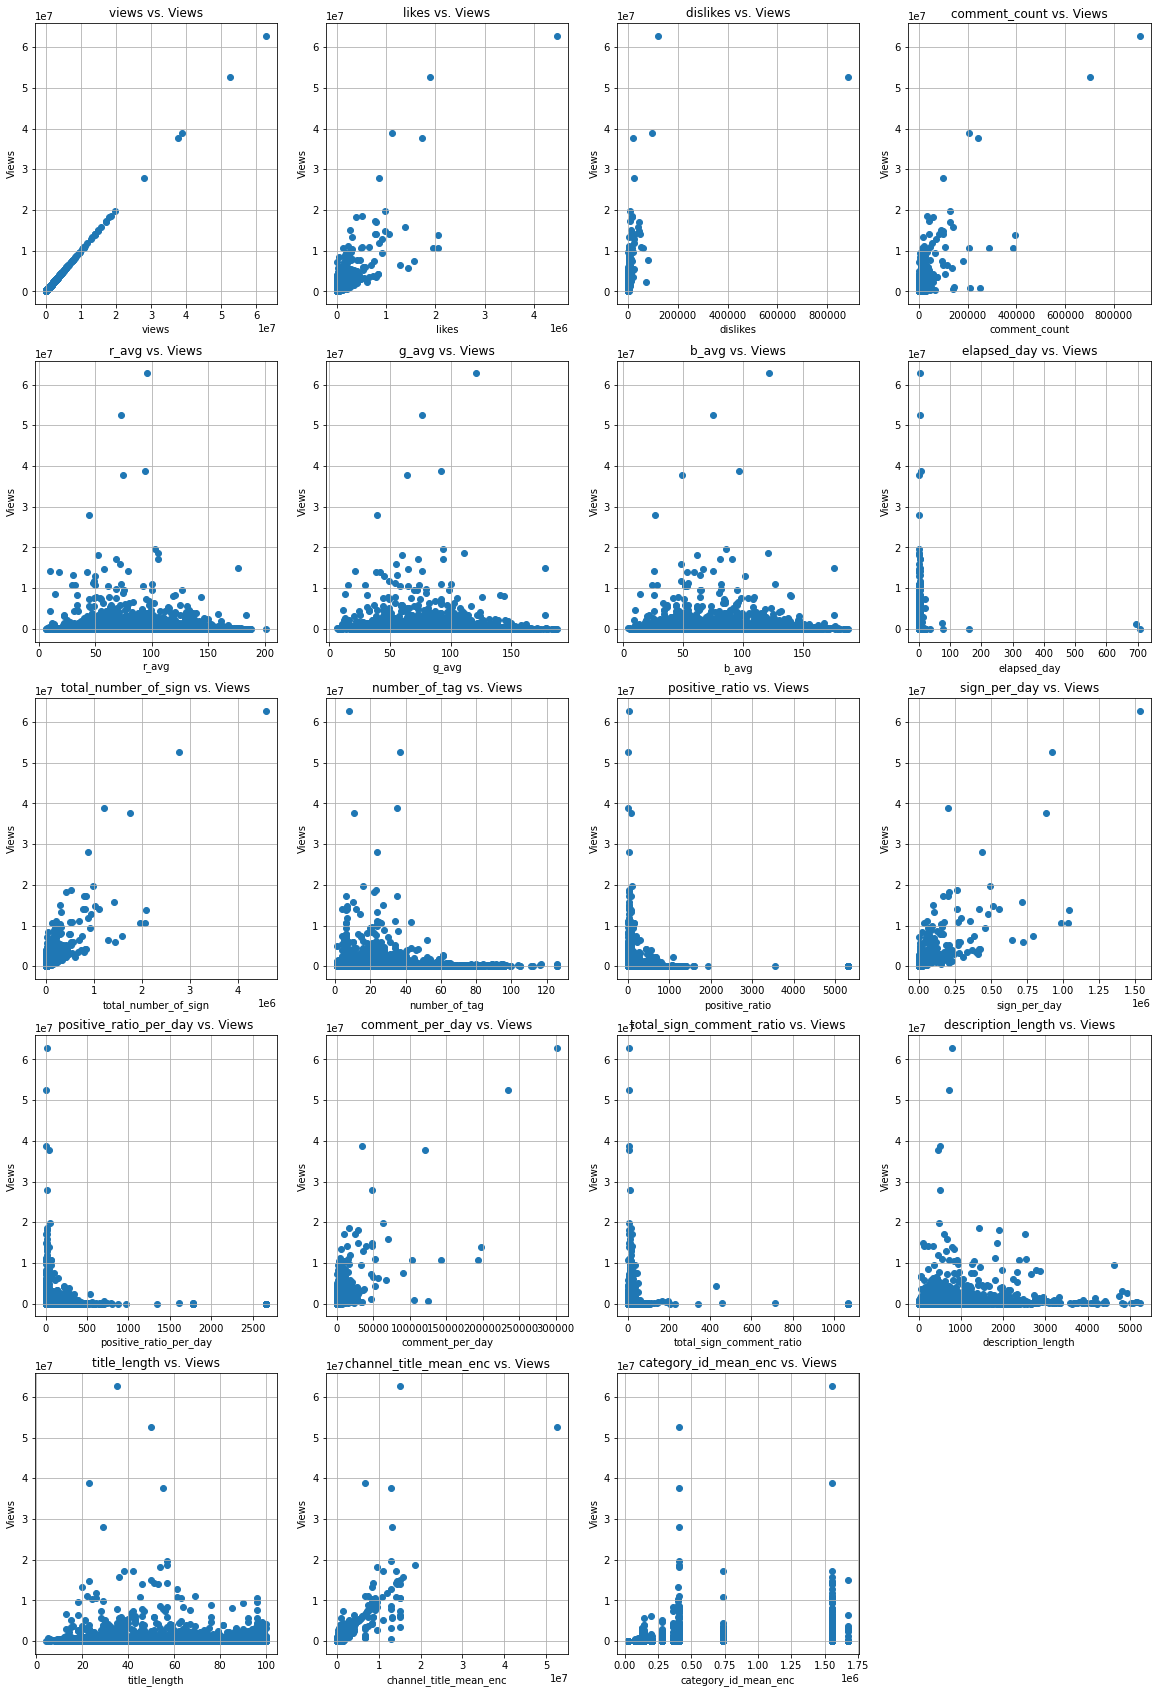

In [36]:
plt.figure(figsize=(20, 30))

for i in range(1, len(df_rgb2.describe().columns)):
    plt.subplot(5, 4, i)
    title = str(df_rgb2.describe().columns[i]) + ' vs. Views'
    plt.title(title)
    plt.xlabel(df_rgb2.describe().columns[i])
    plt.ylabel('Views')
    plt.grid()
    plt.scatter(df_rgb2[df_rgb2.describe().columns[i]], df_rgb2['views'])    

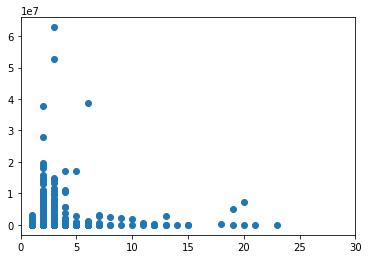

In [37]:
# 상관관계이지 인과관계는 아니다
plt.xlim(0,30)
plt.scatter(df_rgb2['elapsed_day'],df_rgb2['views'])

In [38]:
list(df_rgb2)

['video_id',
 'trending_date',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'thumbnail_link',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'description',
 'r_avg',
 'g_avg',
 'b_avg',
 'publish_time2',
 'publish_date',
 'elapsed_day',
 'total_number_of_sign',
 'number_of_tag',
 'positive_ratio',
 'sign_per_day',
 'positive_ratio_per_day',
 'comment_per_day',
 'total_sign_comment_ratio',
 'description_length',
 'title_length',
 'channel_title_mean_enc',
 'category_id_mean_enc']

#### 다중공산성 체크 

                             likes  dislikes  comment_count  r_avg  g_avg  \
likes                     1.000000       NaN            NaN    NaN    NaN   
dislikes                       NaN       1.0            NaN    NaN    NaN   
comment_count                  NaN       NaN       1.000000    NaN    NaN   
r_avg                          NaN       NaN            NaN    1.0    NaN   
g_avg                          NaN       NaN            NaN    NaN    1.0   
b_avg                          NaN       NaN            NaN    NaN    NaN   
elapsed_day                    NaN       NaN            NaN    NaN    NaN   
number_of_tag                  NaN       NaN            NaN    NaN    NaN   
positive_ratio                 NaN       NaN            NaN    NaN    NaN   
sign_per_day              0.976338       NaN            NaN    NaN    NaN   
positive_ratio_per_day         NaN       NaN            NaN    NaN    NaN   
comment_per_day                NaN       NaN       0.973708    NaN    NaN   

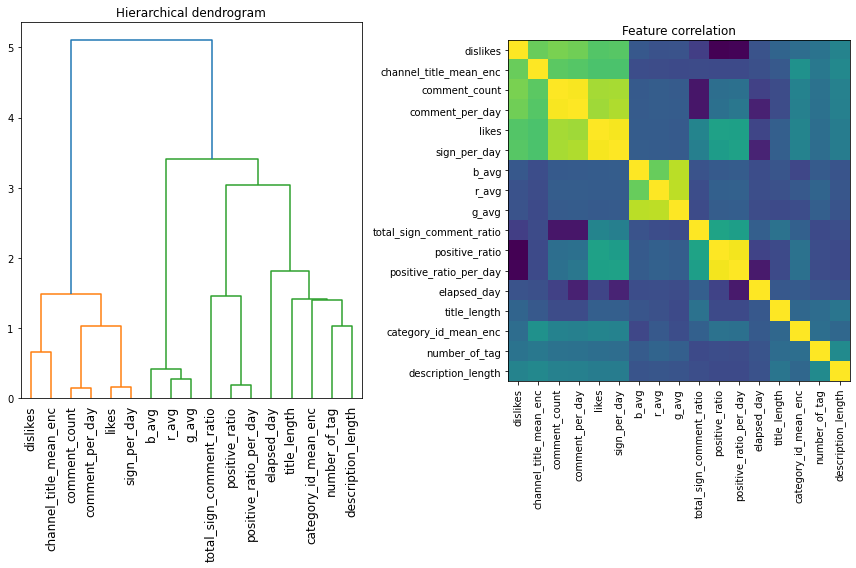

In [39]:
features = ['likes', 'dislikes', 'comment_count', 'r_avg', 'g_avg', 'b_avg', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'sign_per_day', 'positive_ratio_per_day', 'comment_per_day',
            'total_sign_comment_ratio', 'description_length', 'title_length', 'channel_title_mean_enc',
            'category_id_mean_enc']

x_input = df_rgb2[features]
cor_table = x_input.corr()

print(cor_table[cor_table > 0.9])

# correlation그림 그리는 것 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

                        likes  dislikes  comment_count  elapsed_day  \
likes                     1.0       NaN            NaN          NaN   
dislikes                  NaN       1.0            NaN          NaN   
comment_count             NaN       NaN            1.0          NaN   
elapsed_day               NaN       NaN            NaN          1.0   
number_of_tag             NaN       NaN            NaN          NaN   
positive_ratio            NaN       NaN            NaN          NaN   
description_length        NaN       NaN            NaN          NaN   
title_length              NaN       NaN            NaN          NaN   
r_avg                     NaN       NaN            NaN          NaN   
g_avg                     NaN       NaN            NaN          NaN   
b_avg                     NaN       NaN            NaN          NaN   
channel_title_mean_enc    NaN       NaN            NaN          NaN   
category_id_mean_enc      NaN       NaN            NaN          NaN   

     

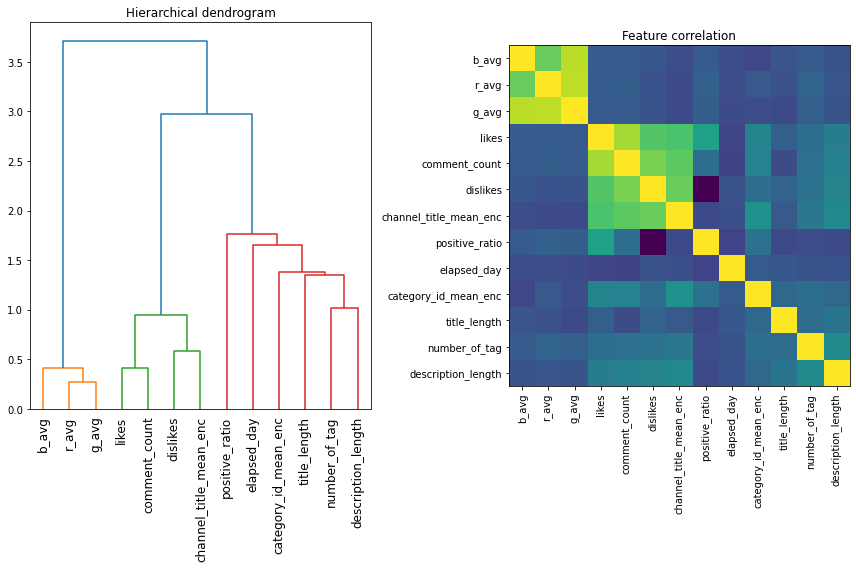

In [40]:
# 필요한 피쳐들만 남겼다
features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'description_length', 'title_length',
            'r_avg', 'g_avg', 'b_avg',  
            'channel_title_mean_enc', 'category_id_mean_enc']            

x_input = df_rgb2[features]
cor_table = x_input.corr()
print(cor_table[cor_table > 0.9])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

In [41]:
y_output = df_rgb2['views']

x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, random_state=42)

In [42]:
y_output #views숫자 

0       156130
1       421409
2       222850
3        84466
4       188707
         ...  
6553     16026
6554     68002
6555     13175
6556     23404
6557     20923
Name: views, Length: 6558, dtype: int64

#**4. 데이터 스케일링**

In [43]:
scaler = MinMaxScaler() # 각열에 대해서 따로따로 0-1사이로 정렬.
# fit한 정보가 scaler에 들어감.
x_train_scaled = scaler.fit_transform(x_train) # 한번에 처리됨. fit=0-1로 바꿀수있는 파라미터 아는것, transform=바꿔주는 것
x_test_scaled = scaler.transform(x_test) #fit한정보 이용해서 transform만 한다. 

#**5. 모델 생성 및 최적화**

In [44]:
model_name = []
train_perf = []
test_perf = []

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits
Best_estimator: ElasticNet(alpha=0.002700000000000001, l1_ratio=0.9, max_iter=100000000,
           random_state=42, tol=0.1)
Best_params: {'alpha': 0.002700000000000001, 'l1_ratio': 0.9, 'tol': 0.1}
Best_score: 0.7275762237612713
Train score: 0.7335034282763583
Test  score: 0.5717640114921283


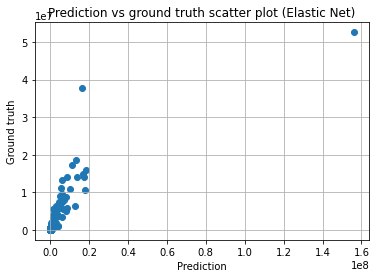

In [45]:
en_model = ElasticNet(max_iter=100000000, random_state=42) #선형모델은 계산부담 없다 많이 돌려도 괜찮다

# 파라미터 미리 준비해옴.
en_param = {'l1_ratio': np.arange(0.9, 0.995, 0.005),
            'alpha': np.arange(0.0008, 0.0028, 0.0001),
            'tol': [1e-2, 3.16e-2, 1e-1, 3.16e-1, 1e0]}

#Grid Search:순차탐색
# n_jobs: 모든 코어를 쓰겠다
clf = GridSearchCV(estimator=en_model, param_grid=en_param, n_jobs=-1, verbose=3) 
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)

train_score = r2_score(y_train_pred, y_train) 
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Elastic Net')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Elastic Net)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [46]:
# best_parameter로 고정한 모델
en_model = ElasticNet(alpha=0.0027, l1_ratio=0.96, tol=0.1, max_iter=100000000, random_state=42)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best_estimator: RandomForestRegressor(max_depth=30, min_samples_split=3, n_estimators=96,
                      n_jobs=-1, random_state=42)
Best_params: {'max_depth': 30, 'min_samples_split': 3, 'n_estimators': 96}
Best_score: 0.7965402943428193
Train score: 0.938119725937386
Test  score: 0.7656353646719458


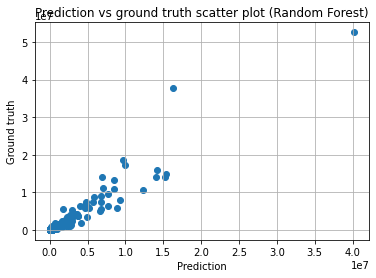

In [47]:
# RandomForest: DecisionTree가 불순도를 가장 줄일 수 있는 방향으로 진행
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)
# 파라미터 종류확인
# n_estimators: 트리갯수
# max_depth: 트리의 깊이(너무 크면 오버피팅)
# min_samples_split: 나눌때 최소한 이 갯수이상은 있어야 나눌 수 있음
rf_param = {'n_estimators': range(76, 136, 20),
            'max_depth': range(30, 42, 4),
            'min_samples_split': range(2, 5, 1)}

clf = GridSearchCV(estimator=rf_model, param_grid=rf_param, n_jobs=-1, verbose=2)

clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Random Forest')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Random Forest)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [48]:
# best_parameter로 고정한 모델
rf_model = RandomForestRegressor(n_estimators=96, max_depth=34, min_samples_split=3, n_jobs=-1, random_state=42)

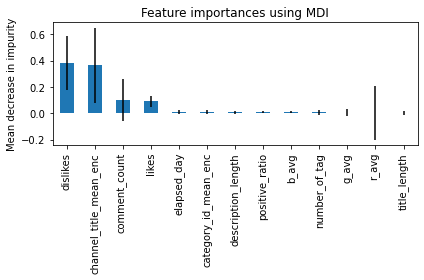

In [49]:
# rf의 피쳐중요도
rf_model.fit(x_train_scaled, y_train)

feature_names = ['feature {i}' for i in range(x_train_scaled.shape[1])]

#피쳐의 중요도가 target예측의 방향성을 알려주지는 않는다
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

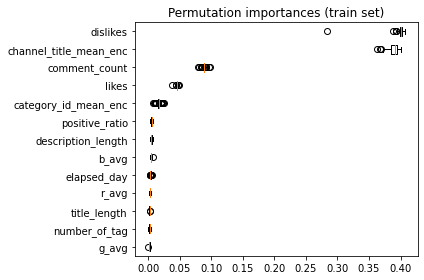

In [50]:
# permutation importance는 피처를 랜덤하게 바꿨을 때 성과로 분석
# n_repeats: 많아질 수록 좋아진다.(배깅) 
result = permutation_importance(rf_model, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best_estimator: MLPRegressor(alpha=0.00011387059213756816, early_stopping=True,
             hidden_layer_sizes=(28, 29, 26, 31), learning_rate='adaptive',
             max_iter=2000000, random_state=42, verbose=0)
Best_params: {'alpha': 0.00011387059213756816, 'hidden_layer_sizes': (28, 29, 26, 31)}
Best_score: 0.7057387150117531
Train score: 0.6987896366721712
Test  score: 0.6846340389129408


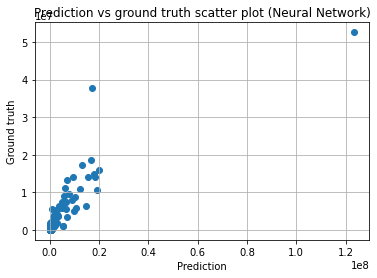

In [51]:
mlp_model = MLPRegressor(learning_rate='adaptive', max_iter=2000000, verbose=0,
                         early_stopping=True, random_state=42)

# itertools.product부분: 24~32사이 숫자를 이용해서 4개의 숫자를 뽑아서 tuple로 만들겠다.
# alpha:규제
# hidden layer와 node수의 관계: 1 hidden layer수=20개 노드수 
mlp_param = {'hidden_layer_sizes': [x for x in itertools.product((range(24, 32)), repeat=4)],
             'alpha': loguniform(1e-4, 1e-3)}

# n_iter:3개보다 크게 돌리자
rand_clf = RandomizedSearchCV(estimator=mlp_model, param_distributions=mlp_param, n_iter=10, n_jobs=-1,
                              cv=3, verbose=2, random_state=42)

rand_clf.fit(x_train_scaled, y_train)

y_train_pred = rand_clf.predict(x_train_scaled)
y_test_pred = rand_clf.predict(x_test_scaled)

print('Best_estimator:', rand_clf.best_estimator_)
print('Best_params:', rand_clf.best_params_)
print('Best_score:', rand_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Neural Network')
train_perf.append(train_score)
test_perf.append(test_score)
plt.title('Prediction vs ground truth scatter plot (Neural Network)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [52]:
# best_parameter로 고정한 모델
mlp_model = MLPRegressor(hidden_layer_sizes=(24, 27, 28, 31), alpha=2.715e-4, learning_rate='adaptive',
                         max_iter=2000000, verbose=0, early_stopping=True, random_state=42)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=120, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best_params: {'max_depth': 2, 'n_estimators': 120, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best_score: 0.7719576984387961
Train score: 0.9922683770622531
Test  score: 0.8017477716708146


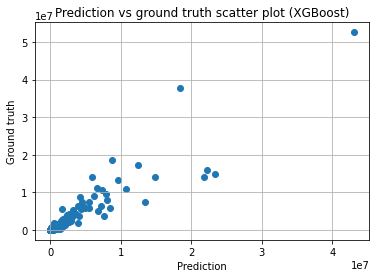

In [53]:
# XGBoost
xgb_model = XGBRegressor(n_jobs=-1, random_state=42)

# rf와 비슷
# 부스팅알고리즘(reg_) 체크
xgb_param = {'n_estimators': range(80, 140, 20),
             'max_depth': range(2, 5, 1),
             'reg_alpha': [1e-2, 3.16e-2, 1e-1],
             'reg_lambda': [0.1, 0.316, 1]}

xgb_clf = GridSearchCV(estimator=xgb_model, param_grid=xgb_param, n_jobs=-1, verbose=2, cv=3)

xgb_clf.fit(x_train_scaled, y_train)
y_train_pred = xgb_clf.predict(x_train_scaled)
y_test_pred = xgb_clf.predict(x_test_scaled)

print('Best_estimator:', xgb_clf.best_estimator_)
print('Best_params:', xgb_clf.best_params_)
print('Best_score:', xgb_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('XGBoost')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (XGBoost)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [54]:
# best_parameter로 고정한 모델
xgb_model = XGBRegressor(max_depth=4, n_estimators=120, reg_alpha=0.1, reg_lambda=0.1, n_jobs=-1, random_state=42)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best_estimator: SVR(C=31600000.0, gamma=0.1)
Best_params: {'C': 31600000.0, 'gamma': 0.1}
Best_score: 0.7589470912496413
Train score: 0.4757299501531632
Test  score: -0.40204085363753483


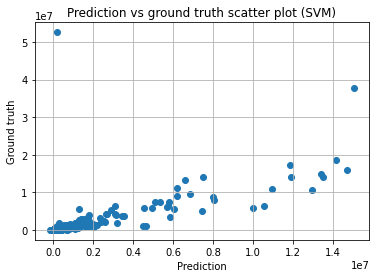

In [55]:
# SVM 
svr_model = SVR()

# 두파라미터: overfit제어가능
# C는 1e8이 맥스임 
svr_param = {'C': [3.16e7, 1e8],
             'gamma': [0.1, 0.316]}

svr_clf = GridSearchCV(estimator=svr_model, param_grid=svr_param, n_jobs=-1, verbose=3, cv=3)

svr_clf.fit(x_train_scaled, y_train)
y_train_pred = svr_clf.predict(x_train_scaled)
y_test_pred = svr_clf.predict(x_test_scaled)

print('Best_estimator:', svr_clf.best_estimator_)
print('Best_params:', svr_clf.best_params_)
print('Best_score:', svr_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('SVM')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (SVM)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [56]:
# best_parameter로 고정한 모델
svr_model = SVR(C=1e8, gamma=0.1)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best_estimator: KNeighborsRegressor(leaf_size=1, n_jobs=-1, weights='distance')
Best_params: {'leaf_size': 1, 'n_neighbors': 5, 'weights': 'distance'}
Best_score: 0.6003613583437778
Train score: 1.0
Test  score: 0.40377898597534967


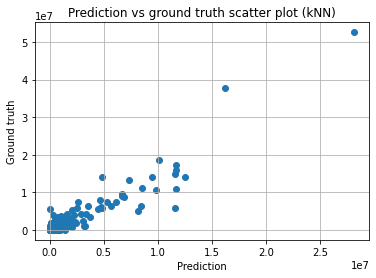

In [114]:
# KNeighborsRegressor: 인접한 데이터들을 기반으로 가격을 예측한다. 
# https://rebro.kr/184
# 범위 밖의 영역은 어떤 예측 체크
knn_model = KNeighborsRegressor(n_jobs=-1)

# n_neighbors: 이웃을 몇개로 할 것인지
# weights: 거리가 멀어진 point에 대해서는 웨이트를 낮게 주고
# leaf_size: 
knn_param = {'n_neighbors': range(1, 6, 1),
             'weights': ['uniform', 'distance'],
             'leaf_size': range(1, 5, 1)}

knn_clf = GridSearchCV(estimator=knn_model, param_grid=knn_param, n_jobs=-1, verbose=3)

knn_clf.fit(x_train_scaled, y_train)
y_train_pred = knn_clf.predict(x_train_scaled)
y_test_pred = knn_clf.predict(x_test_scaled)

print('Best_estimator:', knn_clf.best_estimator_)
print('Best_params:', knn_clf.best_params_)
print('Best_score:', knn_clf.best_score_)
# train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
# test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

# model_name.append('KN')
# train_perf.append(train_score)
# test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (kNN)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

- 위의 모델들 비교

['Elastic Net', 'Random Forest', 'Neural Network', 'XGBoost', 'SVM', 'KN', 'KN']
[0.7335034282763583, 0.938119725937386, 0.6987896366721712, 0.9922683770622531, 0.4757299501531632, 0.4757299501531632, 1.0]


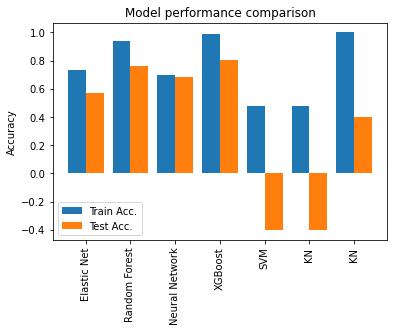

In [117]:
plt.title('Model performance comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
print(model_name)
print(train_perf)
x = np.arange(len(model_name))
plt.xticks(x, model_name)
plt.bar(x - 0.2, train_perf, width=0.4, label='Train Acc.')
plt.bar(x + 0.2, test_perf, width=0.4, label='Test Acc.')
plt.legend()

#**6. 모델 앙상블**

1 Ensemble train score: 0.998935623347123
1 Ensemble test  score: 0.8133059060463537
2 Ensemble train score: 0.9859270082999271
2 Ensemble test  score: 0.794830540400796
3 Ensemble train score: 0.9430097247517739
3 Ensemble test  score: 0.5878487309320353
4 Ensemble train score: 0.9181206517707368
4 Ensemble test  score: 0.8754461328285247
5 Ensemble train score: 0.8965498575776579
5 Ensemble test  score: 0.8434584529310978


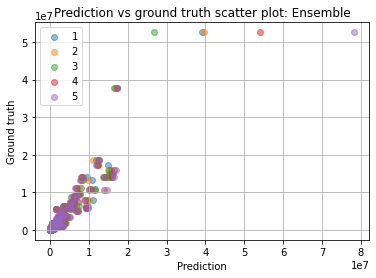

In [59]:
# 반드시 앙상블로 사용하자: 일반화 (익스트림앙상블 10000개)
# sklearn voting classifier
ensemble_list = [('xgb', xgb_model),
                 ('rf', rf_model),
                 ('svm', svr_model),
                 ('mlp', mlp_model),
                 ('en', en_model)]

voting_est = []

for idx, target_model in enumerate(ensemble_list):
    voting_est.append(target_model)

    voting_clf = VotingRegressor(estimators=voting_est, n_jobs=-1)
    voting_clf.fit(x_train_scaled, y_train)
    y_train_pred = voting_clf.predict(x_train_scaled)
    y_test_pred = voting_clf.predict(x_test_scaled)
    print(idx + 1, 'Ensemble train score:', r2_score(y_train_pred, y_train))
    print(idx + 1, 'Ensemble test  score:', r2_score(y_test_pred, y_test))

    plt.scatter(y_test_pred, y_test, label=str(idx + 1), alpha=0.5) #alpha:투명도
    title = 'Prediction vs ground truth scatter plot: Ensemble'     
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground truth')
    plt.grid()
    plt.legend()

In [60]:
voting_clf = VotingRegressor(estimators=[('xgb', xgb_model), ('rf', rf_model), ('svm', svr_model)],
                             n_jobs=-1)
voting_clf.fit(x_train_scaled, y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=4,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=120, n_jobs=-1,
                                          num_parallel_tree=None,
                                          pr

#**7. 특성(피쳐) 중요도 분석**
- 최종 모델에 대한 피쳐중요도 분석

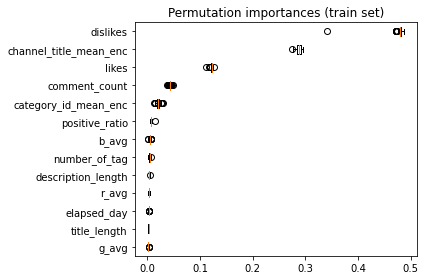

In [61]:
# 피쳐중요도 최종분석
result = permutation_importance(voting_clf, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

#### 분석에 쓸 최종 모델만들기
- 이전 단계에서는 train데이터를 활용해서 모델을 학습시키고 test데이터로 확인을 하였다 
- 이번 단계에서는 최종모델을 훈련하여 test에 쓸 최종 모델을 만든다. 

In [62]:
x_total = np.concatenate((x_train, x_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)

x_total_scaled = scaler.transform(x_total)# 이전 scaler를 사용 확인

voting_clf.fit(x_total_scaled, y_total) # 학습완료

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=4,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=120, n_jobs=-1,
                                          num_parallel_tree=None,
                                          pr

#**8. 유전 알고리즘 - 최적 피쳐 탐색: 일반 YouTuber**
- 먼저 일반youtuber 분석함

In [63]:
# views의 통계량 분석
# 일반유튜버는 50%레벨로 보고
# 상단으로 갈수록 views수가 크게 늘어난다
df_rgb2['views'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

count    6.558000e+03
mean     3.702816e+05
std      1.662346e+06
min      2.623000e+03
50%      9.915450e+04
75%      2.330775e+05
90%      5.680616e+05
95%      1.155140e+06
99%      5.188478e+06
max      6.279639e+07
Name: views, dtype: float64

In [64]:
# 참고사항 
# features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag', 'positive_ratio',
#             'description_length', 'title_length', 'r_avg', 'g_avg', 'b_avg', 'channel_title_mean_enc',
#             'category_id_mean_enc']

# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'


# 유전알고리즘에 의해서 만들어진 x_input이 여기에 쓰인다. 
def input_conversion(x_input):
    conversion = [int(x_input[0]),
                  int(x_input[1]),
                  int(x_input[2]),
                  int(x_input[3]),
                  int(x_input[4]),
                  x_input[0] / x_input[1],
                  int(x_input[5]),
                  int(x_input[6]),
                  int(x_input[7]),
                  int(x_input[8]),
                  int(x_input[9]),
                  mean_encode_channel.iloc[int(x_input[10])],
                  mean_encode_category.iloc[int(x_input[11])]]

    return conversion

In [65]:
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

# variable들의 바운드 
# [최소값, 최대값]
# 찾고자하는 범위를 조금 안쪽으로 세팅해도 됨. 지금은 1로 보정하였으나 범위끝쪽은 설명력 떨어짐
varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()],
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()],
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]], 
                     [2, 2]]) # music카테고리사용 아니면 위의 코드로 전체를 사용함

In [66]:
# 유전알고리즘이 사용할 object함수 
# target_model: 유전알고리즘을 머신러닝알고리즘에 연결해서 사용함 
# 일반유튜브를 상대로 한 것이라 median이라고 씀 
def object_function_median(x_input, target_model=voting_clf):
    # 모델이 사용할 수 있는 형식으로 바꿈 
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)
    
    # 스케일링: fit해서 파라미터저장하였음. 
    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled) #추론

    # 유전알고리즘에 따라서 목표값을 탐색하는 것임. 
    # 목표: views가 10만(median)에 해당하는 컨디션은 무엇이 있는지? 
    target = df_rgb2['views'].median()
    print('Predicted views:', int(prediction), 'Difference from target:', int(prediction - target))

    # Target에 가까이 가기 위해서 loss함수처럼 짜준다 
    # prediction과 target차이가 커지면 차이를 줄이려고 유전알고리즘이 작동 
    # return abs(int(prediction) - target) # target값근처에서는 차이가 별로 안나서 효율이 안나서 절대값대신 로그씀
    return math.log(abs(target - int(prediction))) # 작은 값을 맞출때 그 gain이 크도록 log를 쓴다 

In [67]:
# 유전알고리즘 파라미터 정의
# parents_portion: 다음세대에 부모세대의 비중 30% 
# crossover_probability: 크로스오버 교차연산을 얼마나 하겠다
# crossover_type: uniform 부분해 집합을 랜덤하게 섞겠다 
# mutation_probability: 다음세대에 변이비중 10%로 가져가겠다 
# elit_ratio: 이전세대에 가장 뛰어난 비중만큼 이번세대에 그대로 가져간다 
# population_size: 초기 generation된 해값들
# max_num_iteration: 전체 몇번 진화를 할 것이냐 
# max_iteration_without_improv: 몇번동안 개선이 없으면 정지하겠느냐 

algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

Predicted views: 29479034 Difference from target: 29379880
Predicted views: 37330430 Difference from target: 37231276
Predicted views: 28969820 Difference from target: 28870666
Predicted views: 35529511 Difference from target: 35430356
Predicted views: 25718095 Difference from target: 25618941
Predicted views: 34240515 Difference from target: 34141360
Predicted views: 31733911 Difference from target: 31634756
Predicted views: 30819940 Difference from target: 30720785
Predicted views: 32718848 Difference from target: 32619694
Predicted views: 33246591 Difference from target: 33147437
Predicted views: 21192865 Difference from target: 21093710
Predicted views: 32041386 Difference from target: 31942232
Predicted views: 24744413 Difference from target: 24645258
Predicted views: 29317279 Difference from target: 29218125
Predicted views: 25189050 Difference from target: 25089896
Predicted views: 30979838 Difference from target: 30880684
Predicted views: 17312523 Difference from target: 172133

Predicted views: 22830555 Difference from target: 22731401
Predicted views: 27640687 Difference from target: 27541533
Predicted views: 26864717 Difference from target: 26765562
Predicted views: 36024683 Difference from target: 35925528
Predicted views: 28546151 Difference from target: 28446996
Predicted views: 29482335 Difference from target: 29383180
Predicted views: 37371754 Difference from target: 37272600
Predicted views: 25737215 Difference from target: 25638060
Predicted views: 40633101 Difference from target: 40533947
Predicted views: 27923354 Difference from target: 27824200
Predicted views: 29665565 Difference from target: 29566411
Predicted views: 27269160 Difference from target: 27170006
Predicted views: 12212118 Difference from target: 12112963
Predicted views: 32073403 Difference from target: 31974249
Predicted views: 30098701 Difference from target: 29999547
Predicted views: 12687941 Difference from target: 12588786
Predicted views: 23592034 Difference from target: 234928

Predicted views: 24398404 Difference from target: 24299250
Predicted views: 28010713 Difference from target: 27911558
Predicted views: 32221467 Difference from target: 32122313
Predicted views: 32500816 Difference from target: 32401662
Predicted views: 28278030 Difference from target: 28178875
Predicted views: 7678180 Difference from target: 7579026
Predicted views: 34022979 Difference from target: 33923824
Predicted views: 27320524 Difference from target: 27221369
Predicted views: 14400686 Difference from target: 14301532
Predicted views: 33395824 Difference from target: 33296669
Predicted views: 27856588 Difference from target: 27757434
Predicted views: 28164287 Difference from target: 28065132
Predicted views: 28534764 Difference from target: 28435609
Predicted views: 14922096 Difference from target: 14822942
Predicted views: 27749192 Difference from target: 27650037
Predicted views: 26141911 Difference from target: 26042757
Predicted views: 27780484 Difference from target: 27681329

Predicted views: 5860195 Difference from target: 5761041
Predicted views: 28551287 Difference from target: 28452133
Predicted views: 32340891 Difference from target: 32241736
Predicted views: 12136898 Difference from target: 12037743
Predicted views: 8643645 Difference from target: 8544490
Predicted views: 29312520 Difference from target: 29213365
Predicted views: 14656792 Difference from target: 14557638
Predicted views: 27938672 Difference from target: 27839518
Predicted views: 32308433 Difference from target: 32209278
Predicted views: 5746200 Difference from target: 5647046
Predicted views: 42132084 Difference from target: 42032930
Predicted views: 5017015 Difference from target: 4917861
Predicted views: 29303924 Difference from target: 29204770
Predicted views: 4002314 Difference from target: 3903159
Predicted views: 28058292 Difference from target: 27959137
Predicted views: 14556901 Difference from target: 14457747
Predicted views: 32988075 Difference from target: 32888921
Predict

Predicted views: 11307730 Difference from target: 11208576
Predicted views: 6235216 Difference from target: 6136061
Predicted views: 6246757 Difference from target: 6147602
Predicted views: 6092689 Difference from target: 5993535
Predicted views: 29436969 Difference from target: 29337815
Predicted views: 5692318 Difference from target: 5593164
Predicted views: 30115412 Difference from target: 30016258
Predicted views: 5579664 Difference from target: 5480509
Predicted views: 5441821 Difference from target: 5342667
Predicted views: 7496713 Difference from target: 7397558
Predicted views: 9804212 Difference from target: 9705058
Predicted views: 10947402 Difference from target: 10848247
Predicted views: 3420676 Difference from target: 3321522
Predicted views: 3463289 Difference from target: 3364134
Predicted views: 3756784 Difference from target: 3657630
Predicted views: 4985967 Difference from target: 4886813
Predicted views: 30356158 Difference from target: 30257004
Predicted views: 2999

Predicted views: 3188069 Difference from target: 3088914
Predicted views: 11115262 Difference from target: 11016107
Predicted views: 1007228 Difference from target: 908074
Predicted views: 1046391 Difference from target: 947237
Predicted views: 2097163 Difference from target: 1998009
Predicted views: 17941678 Difference from target: 17842523
Predicted views: 4345678 Difference from target: 4246524
Predicted views: 35548848 Difference from target: 35449693
Predicted views: 1865271 Difference from target: 1766116
Predicted views: 1000662 Difference from target: 901507
Predicted views: 1083921 Difference from target: 984766
Predicted views: 2628062 Difference from target: 2528908
Predicted views: 1215644 Difference from target: 1116490
Predicted views: 1619665 Difference from target: 1520510
Predicted views: 5629685 Difference from target: 5530530
Predicted views: 5609654 Difference from target: 5510499
Predicted views: 6660307 Difference from target: 6561153
Predicted views: 5662399 Diff

Predicted views: 1257822 Difference from target: 1158668
Predicted views: 18167100 Difference from target: 18067946
Predicted views: 1357436 Difference from target: 1258281
Predicted views: 706049 Difference from target: 606895
Predicted views: 1240821 Difference from target: 1141666
Predicted views: 836673 Difference from target: 737519
Predicted views: 5638282 Difference from target: 5539127
Predicted views: 5525968 Difference from target: 5426813
Predicted views: 484540 Difference from target: 385386
Predicted views: 1389709 Difference from target: 1290555
Predicted views: 1112912 Difference from target: 1013758
Predicted views: 7912450 Difference from target: 7813296
Predicted views: 5091917 Difference from target: 4992762
Predicted views: 1264401 Difference from target: 1165247
Predicted views: 2004230 Difference from target: 1905075
Predicted views: 1088780 Difference from target: 989626
Predicted views: 1135844 Difference from target: 1036690
Predicted views: 20413016 Difference

Predicted views: 727472 Difference from target: 628317
Predicted views: 1532357 Difference from target: 1433202
Predicted views: 3686803 Difference from target: 3587649
Predicted views: 1076067 Difference from target: 976913
Predicted views: 5050300 Difference from target: 4951145
Predicted views: 688567 Difference from target: 589413
Predicted views: 18446334 Difference from target: 18347179
Predicted views: 1118359 Difference from target: 1019205
Predicted views: 1148859 Difference from target: 1049705
Predicted views: 6827016 Difference from target: 6727861
Predicted views: 1224263 Difference from target: 1125108
Predicted views: 5291821 Difference from target: 5192666
Predicted views: 572124 Difference from target: 472969
Predicted views: 5381513 Difference from target: 5282358
Predicted views: 5381513 Difference from target: 5282358
Predicted views: 14894587 Difference from target: 14795432
Predicted views: 1071705 Difference from target: 972551
Predicted views: 1857805 Difference

Predicted views: 877297 Difference from target: 778143
Predicted views: 432832 Difference from target: 333677
Predicted views: 601954 Difference from target: 502800
Predicted views: 18784540 Difference from target: 18685386
Predicted views: 2038155 Difference from target: 1939001
Predicted views: 734297 Difference from target: 635142
Predicted views: 936624 Difference from target: 837470
Predicted views: 4607727 Difference from target: 4508573
Predicted views: 941939 Difference from target: 842785
Predicted views: 2084314 Difference from target: 1985160
Predicted views: 392124 Difference from target: 292969
Predicted views: 1347513 Difference from target: 1248359
Predicted views: 5426772 Difference from target: 5327617
Predicted views: 391060 Difference from target: 291905
Predicted views: 961361 Difference from target: 862206
Predicted views: 1333440 Difference from target: 1234286
Predicted views: 4126891 Difference from target: 4027736
Predicted views: 1252815 Difference from target

Predicted views: 531196 Difference from target: 432042
Predicted views: 3594247 Difference from target: 3495093
Predicted views: 3457615 Difference from target: 3358460
Predicted views: 629372 Difference from target: 530218
Predicted views: 3541357 Difference from target: 3442203
Predicted views: 421056 Difference from target: 321902
Predicted views: 3224100 Difference from target: 3124946
Predicted views: 861553 Difference from target: 762398
Predicted views: 866453 Difference from target: 767299
Predicted views: 3357817 Difference from target: 3258662
Predicted views: 3181488 Difference from target: 3082334
Predicted views: 5121628 Difference from target: 5022474
Predicted views: 18971288 Difference from target: 18872133
Predicted views: 1470694 Difference from target: 1371539
Predicted views: 4006842 Difference from target: 3907688
Predicted views: 2194254 Difference from target: 2095099
|||_______________________________________________ 6.0% GA is running...Predicted views: 1224228

Predicted views: 846336 Difference from target: 747182
Predicted views: 1752256 Difference from target: 1653101
Predicted views: 1387294 Difference from target: 1288139
Predicted views: 1372197 Difference from target: 1273043
Predicted views: 1925164 Difference from target: 1826010
Predicted views: 884040 Difference from target: 784886
Predicted views: 1274250 Difference from target: 1175096
Predicted views: 1863172 Difference from target: 1764017
|||_______________________________________________ 6.7% GA is running...Predicted views: 184270 Difference from target: 85116
Predicted views: 18952317 Difference from target: 18853163
Predicted views: 485194 Difference from target: 386040
Predicted views: 824811 Difference from target: 725657
Predicted views: 1037533 Difference from target: 938378
Predicted views: 524311 Difference from target: 425157
Predicted views: 2354585 Difference from target: 2255431
Predicted views: 290938 Difference from target: 191783
Predicted views: 358294 Differ

Predicted views: 288065 Difference from target: 188910
Predicted views: 383968 Difference from target: 284813
Predicted views: 2602691 Difference from target: 2503536
||||______________________________________________ 7.3% GA is running...Predicted views: 199939 Difference from target: 100785
Predicted views: 4315790 Difference from target: 4216636
Predicted views: 2666912 Difference from target: 2567757
Predicted views: 1243420 Difference from target: 1144266
Predicted views: 1720623 Difference from target: 1621468
Predicted views: 4219761 Difference from target: 4120606
Predicted views: 236998 Difference from target: 137843
Predicted views: 7820803 Difference from target: 7721649
Predicted views: 430355 Difference from target: 331200
Predicted views: 421680 Difference from target: 322525
Predicted views: 1353042 Difference from target: 1253888
Predicted views: 444642 Difference from target: 345488
Predicted views: 849048 Difference from target: 749894
Predicted views: 70574 Differenc

Predicted views: 221774 Difference from target: 122619
Predicted views: 1059322 Difference from target: 960167
Predicted views: 15555797 Difference from target: 15456642
Predicted views: 181192 Difference from target: 82038
Predicted views: 380964 Difference from target: 281809
Predicted views: 17528591 Difference from target: 17429437
Predicted views: 17958773 Difference from target: 17859619
Predicted views: 3087634 Difference from target: 2988479
Predicted views: 199939 Difference from target: 100785
Predicted views: 181508 Difference from target: 82354
Predicted views: 131990 Difference from target: 32835
Predicted views: 731912 Difference from target: 632757
Predicted views: 184640 Difference from target: 85485
Predicted views: 3652549 Difference from target: 3553394
Predicted views: 308688 Difference from target: 209533
Predicted views: 15730064 Difference from target: 15630909
Predicted views: 645482 Difference from target: 546327
Predicted views: 282361 Difference from target: 

Predicted views: 472955 Difference from target: 373801
Predicted views: 310800 Difference from target: 211645
Predicted views: 16515114 Difference from target: 16415959
Predicted views: 17061356 Difference from target: 16962202
Predicted views: 17461931 Difference from target: 17362776
Predicted views: 1910221 Difference from target: 1811066
Predicted views: 568705 Difference from target: 469550
Predicted views: 182108 Difference from target: 82954
Predicted views: 675871 Difference from target: 576717
Predicted views: 245761 Difference from target: 146607
Predicted views: 389825 Difference from target: 290670
Predicted views: 296853 Difference from target: 197699
Predicted views: 430098 Difference from target: 330943
Predicted views: 606263 Difference from target: 507109
Predicted views: 167836 Difference from target: 68681
Predicted views: 445090 Difference from target: 345936
Predicted views: 252340 Difference from target: 153186
Predicted views: 2661455 Difference from target: 2562

Predicted views: 860748 Difference from target: 761593
Predicted views: 2522881 Difference from target: 2423726
Predicted views: 204636 Difference from target: 105482
Predicted views: 210108 Difference from target: 110954
Predicted views: 16985322 Difference from target: 16886168
Predicted views: 689433 Difference from target: 590278
Predicted views: 21267374 Difference from target: 21168219
Predicted views: 17651902 Difference from target: 17552747
Predicted views: 17444058 Difference from target: 17344904
Predicted views: 892337 Difference from target: 793183
Predicted views: 1005341 Difference from target: 906186
Predicted views: 5421336 Difference from target: 5322181
Predicted views: 679196 Difference from target: 580042
Predicted views: 6838599 Difference from target: 6739444
Predicted views: 383938 Difference from target: 284784
Predicted views: 243433 Difference from target: 144279
Predicted views: 106081 Difference from target: 6927
Predicted views: 3810239 Difference from tar

Predicted views: 342206 Difference from target: 243051
Predicted views: 297199 Difference from target: 198045
Predicted views: 19981895 Difference from target: 19882741
Predicted views: 71142 Difference from target: -28011
Predicted views: 224432 Difference from target: 125278
Predicted views: 94496 Difference from target: -4658
Predicted views: 160416 Difference from target: 61262
Predicted views: 613379 Difference from target: 514224
Predicted views: 2117032 Difference from target: 2017878
Predicted views: 103951 Difference from target: 4797
Predicted views: 3579848 Difference from target: 3480693
Predicted views: 218335 Difference from target: 119181
Predicted views: 307536 Difference from target: 208382
Predicted views: 382729 Difference from target: 283574
Predicted views: 619886 Difference from target: 520731
Predicted views: 332265 Difference from target: 233111
Predicted views: 30301795 Difference from target: 30202640
Predicted views: 4180828 Difference from target: 4081674
Pr

Predicted views: 472185 Difference from target: 373030
Predicted views: 19246924 Difference from target: 19147770
Predicted views: 539774 Difference from target: 440620
Predicted views: 17892367 Difference from target: 17793213
Predicted views: 358619 Difference from target: 259464
Predicted views: 258132 Difference from target: 158977
Predicted views: 167194 Difference from target: 68039
Predicted views: 245391 Difference from target: 146237
Predicted views: 370784 Difference from target: 271629
Predicted views: 418241 Difference from target: 319087
Predicted views: 413359 Difference from target: 314204
Predicted views: 61374 Difference from target: -37780
Predicted views: 182174 Difference from target: 83020
Predicted views: 161944 Difference from target: 62790
Predicted views: 235129 Difference from target: 135974
Predicted views: 1389090 Difference from target: 1289936
Predicted views: 215741 Difference from target: 116587
Predicted views: 3687199 Difference from target: 3588044
Pr

Predicted views: 118322 Difference from target: 19167
Predicted views: 345048 Difference from target: 245893
Predicted views: 305089 Difference from target: 205934
Predicted views: 44918 Difference from target: -54235
Predicted views: 548337 Difference from target: 449183
Predicted views: 160828 Difference from target: 61673
Predicted views: 340262 Difference from target: 241108
Predicted views: 19129711 Difference from target: 19030557
Predicted views: 647546 Difference from target: 548392
Predicted views: 291162 Difference from target: 192007
Predicted views: 17816474 Difference from target: 17717320
Predicted views: 315595 Difference from target: 216441
Predicted views: 136066 Difference from target: 36912
Predicted views: 18443366 Difference from target: 18344211
Predicted views: 142859 Difference from target: 43705
Predicted views: 118189 Difference from target: 19034
Predicted views: 148162 Difference from target: 49007
Predicted views: 17800562 Difference from target: 17701408
P

Predicted views: 2559891 Difference from target: 2460737
Predicted views: 1902434 Difference from target: 1803280
Predicted views: 294369 Difference from target: 195214
Predicted views: 214571 Difference from target: 115417
Predicted views: 5619023 Difference from target: 5519869
Predicted views: 175501 Difference from target: 76347
Predicted views: 84755 Difference from target: -14398
Predicted views: -1789 Difference from target: -100944
Predicted views: 22387824 Difference from target: 22288670
Predicted views: 65294 Difference from target: -33860
Predicted views: 1143875 Difference from target: 1044720
Predicted views: 3294565 Difference from target: 3195410
Predicted views: 173915 Difference from target: 74760
Predicted views: 2100690 Difference from target: 2001536
Predicted views: 5106896 Difference from target: 5007741
Predicted views: 146745 Difference from target: 47590
Predicted views: 255509 Difference from target: 156355
Predicted views: -5601 Difference from target: -1047

Predicted views: 2331624 Difference from target: 2232470
Predicted views: 2984161 Difference from target: 2885007
Predicted views: 5371543 Difference from target: 5272389
Predicted views: 211293 Difference from target: 112139
Predicted views: 383410 Difference from target: 284255
Predicted views: 18387127 Difference from target: 18287972
Predicted views: -7010 Difference from target: -106165
Predicted views: 91836 Difference from target: -7318
Predicted views: 95703 Difference from target: -3450
Predicted views: 174370 Difference from target: 75215
Predicted views: 1886937 Difference from target: 1787782
Predicted views: 24719 Difference from target: -74435
Predicted views: 81098 Difference from target: -18055
Predicted views: 2159512 Difference from target: 2060357
Predicted views: 77916 Difference from target: -21238
Predicted views: 17221186 Difference from target: 17122032
Predicted views: 2033788 Difference from target: 1934633
Predicted views: 2445082 Difference from target: 2345

Predicted views: 316960 Difference from target: 217806
Predicted views: 175479 Difference from target: 76324
Predicted views: 180099 Difference from target: 80945
Predicted views: 250847 Difference from target: 151693
Predicted views: 62578 Difference from target: -36575
Predicted views: 336528 Difference from target: 237374
Predicted views: 197454 Difference from target: 98299
Predicted views: 17586169 Difference from target: 17487015
Predicted views: 102655 Difference from target: 3500
Predicted views: 258115 Difference from target: 158960
Predicted views: 189121 Difference from target: 89967
Predicted views: 16671696 Difference from target: 16572542
Predicted views: 223233 Difference from target: 124078
Predicted views: 68551 Difference from target: -30603
Predicted views: 172085 Difference from target: 72931
Predicted views: 316067 Difference from target: 216913
Predicted views: 180363 Difference from target: 81209
Predicted views: 419614 Difference from target: 320459
Predicted vi

Predicted views: 96598 Difference from target: -2556
Predicted views: 363263 Difference from target: 264109
Predicted views: 16879110 Difference from target: 16779956
Predicted views: 2776655 Difference from target: 2677501
Predicted views: 126002 Difference from target: 26848
Predicted views: 3650721 Difference from target: 3551566
Predicted views: 153008 Difference from target: 53854
Predicted views: 156575 Difference from target: 57420
Predicted views: 653352 Difference from target: 554197
Predicted views: 1987762 Difference from target: 1888608
Predicted views: 32979 Difference from target: -66174
Predicted views: -13891 Difference from target: -113046
Predicted views: 116435 Difference from target: 17281
|||||||___________________________________________ 14.3% GA is running...Predicted views: 3171391 Difference from target: 3072236
Predicted views: 529603 Difference from target: 430448
Predicted views: 96928 Difference from target: -2225
Predicted views: 104939 Difference from tar

Predicted views: 76285 Difference from target: -22869
Predicted views: 2929842 Difference from target: 2830688
Predicted views: 81507 Difference from target: -17646
Predicted views: 74694 Difference from target: -24459
Predicted views: 129237 Difference from target: 30082
Predicted views: 2764243 Difference from target: 2665088
Predicted views: 97404 Difference from target: -1750
||||||||__________________________________________ 15.0% GA is running...Predicted views: 167619 Difference from target: 68465
Predicted views: 40587 Difference from target: -58567
Predicted views: 26034041 Difference from target: 25934887
Predicted views: 165361 Difference from target: 66206
Predicted views: 16761577 Difference from target: 16662422
Predicted views: 244581 Difference from target: 145426
Predicted views: 2463730 Difference from target: 2364576
Predicted views: 136369 Difference from target: 37214
Predicted views: 847529 Difference from target: 748374
Predicted views: 439956 Difference from tar

||||||||__________________________________________ 15.7% GA is running...Predicted views: 175951 Difference from target: 76797
Predicted views: 122848 Difference from target: 23694
Predicted views: 207114 Difference from target: 107960
Predicted views: 41760 Difference from target: -57394
Predicted views: 61239 Difference from target: -37914
Predicted views: 321688 Difference from target: 222533
Predicted views: 236225 Difference from target: 137070
Predicted views: 40210 Difference from target: -58944
Predicted views: 274288 Difference from target: 175133
Predicted views: 152401 Difference from target: 53246
Predicted views: 3259229 Difference from target: 3160074
Predicted views: 105699 Difference from target: 6545
Predicted views: 108146 Difference from target: 8991
Predicted views: 36039 Difference from target: -63114
Predicted views: 2613990 Difference from target: 2514835
Predicted views: 470585 Difference from target: 371431
Predicted views: 225873 Difference from target: 126719

Predicted views: 2531293 Difference from target: 2432139
Predicted views: 17106769 Difference from target: 17007614
Predicted views: -28525 Difference from target: -127680
Predicted views: 31163748 Difference from target: 31064594
Predicted views: 121557 Difference from target: 22403
Predicted views: 2688437 Difference from target: 2589283
Predicted views: 488302 Difference from target: 389148
Predicted views: 135151 Difference from target: 35997
Predicted views: 2408058 Difference from target: 2308903
Predicted views: 1208392 Difference from target: 1109237
Predicted views: 283263 Difference from target: 184108
Predicted views: 2376023 Difference from target: 2276869
Predicted views: 220430 Difference from target: 121276
Predicted views: 2481703 Difference from target: 2382548
Predicted views: 1093859 Difference from target: 994704
Predicted views: 2605891 Difference from target: 2506736
Predicted views: 826762 Difference from target: 727607
Predicted views: 2320086 Difference from ta

Predicted views: 220256 Difference from target: 121102
Predicted views: 23805853 Difference from target: 23706698
Predicted views: 133355 Difference from target: 34200
Predicted views: 186675 Difference from target: 87520
Predicted views: 278620 Difference from target: 179466
Predicted views: 322346 Difference from target: 223192
Predicted views: 20241473 Difference from target: 20142318
Predicted views: 162920 Difference from target: 63765
Predicted views: 243571 Difference from target: 144416
Predicted views: 95099 Difference from target: -4054
Predicted views: 2093322 Difference from target: 1994167
Predicted views: 2368115 Difference from target: 2268961
Predicted views: 45008 Difference from target: -54146
Predicted views: 18898501 Difference from target: 18799347
Predicted views: 211543 Difference from target: 112389
Predicted views: 142362 Difference from target: 43207
Predicted views: 2235353 Difference from target: 2136199
Predicted views: 300407 Difference from target: 201252

Predicted views: 398958 Difference from target: 299803
Predicted views: 18399086 Difference from target: 18299932
Predicted views: 409528 Difference from target: 310374
Predicted views: 299189 Difference from target: 200035
Predicted views: 192349 Difference from target: 93195
Predicted views: 162702 Difference from target: 63547
Predicted views: 2446253 Difference from target: 2347098
Predicted views: 145032 Difference from target: 45878
Predicted views: 410730 Difference from target: 311575
Predicted views: 867395 Difference from target: 768240
Predicted views: 1143773 Difference from target: 1044619
Predicted views: 146109 Difference from target: 46954
Predicted views: 17127723 Difference from target: 17028568
Predicted views: 227243 Difference from target: 128089
Predicted views: 297966 Difference from target: 198811
Predicted views: 834836 Difference from target: 735682
Predicted views: 310880 Difference from target: 211726
Predicted views: 240657 Difference from target: 141502
Pr

Predicted views: 5835678 Difference from target: 5736523
Predicted views: 144666 Difference from target: 45512
Predicted views: 128821 Difference from target: 29667
Predicted views: 1098279 Difference from target: 999125
Predicted views: 259855 Difference from target: 160701
Predicted views: 318062 Difference from target: 218908
Predicted views: 238126 Difference from target: 138972
Predicted views: 1390183 Difference from target: 1291029
Predicted views: 1141673 Difference from target: 1042518
Predicted views: 3086195 Difference from target: 2987041
Predicted views: 258572 Difference from target: 159418
Predicted views: 292002 Difference from target: 192848
Predicted views: 177838 Difference from target: 78684
Predicted views: 396329 Difference from target: 297175
Predicted views: 815735 Difference from target: 716581
Predicted views: 178316 Difference from target: 79161
Predicted views: 2177917 Difference from target: 2078763
Predicted views: 107619 Difference from target: 8465
Predi

Predicted views: 358178 Difference from target: 259023
Predicted views: 3800971 Difference from target: 3701816
Predicted views: 241703 Difference from target: 142549
Predicted views: 227102 Difference from target: 127948
Predicted views: 314078 Difference from target: 214923
Predicted views: 3586066 Difference from target: 3486911
Predicted views: 452935 Difference from target: 353781
Predicted views: 2248473 Difference from target: 2149319
Predicted views: 110976 Difference from target: 11822
Predicted views: 19493674 Difference from target: 19394520
Predicted views: 305325 Difference from target: 206171
Predicted views: 230624 Difference from target: 131470
Predicted views: 2044165 Difference from target: 1945010
Predicted views: 92794 Difference from target: -6360
Predicted views: 5883959 Difference from target: 5784804
Predicted views: 279821 Difference from target: 180666
Predicted views: 5744495 Difference from target: 5645341
Predicted views: 130898 Difference from target: 3174

Predicted views: 142778 Difference from target: 43623
Predicted views: 349509 Difference from target: 250354
Predicted views: 121906 Difference from target: 22751
Predicted views: 92128 Difference from target: -7026
Predicted views: 118520 Difference from target: 19366
Predicted views: 216286 Difference from target: 117131
Predicted views: 393871 Difference from target: 294717
Predicted views: 143795 Difference from target: 44641
Predicted views: 265579 Difference from target: 166425
Predicted views: 538541 Difference from target: 439386
Predicted views: 143911 Difference from target: 44757
Predicted views: 124253 Difference from target: 25099
Predicted views: 348504 Difference from target: 249350
Predicted views: 204032 Difference from target: 104877
Predicted views: 178179 Difference from target: 79024
Predicted views: 2031747 Difference from target: 1932593
Predicted views: 238353 Difference from target: 139198
Predicted views: 17208344 Difference from target: 17109189
Predicted vie

Predicted views: 529180 Difference from target: 430025
Predicted views: 275662 Difference from target: 176508
Predicted views: 211344 Difference from target: 112189
Predicted views: 226635 Difference from target: 127480
Predicted views: 3379297 Difference from target: 3280142
Predicted views: 303394 Difference from target: 204240
Predicted views: 114562 Difference from target: 15408
Predicted views: 193190 Difference from target: 94035
Predicted views: 127237 Difference from target: 28083
Predicted views: 90879 Difference from target: -8274
Predicted views: 424152 Difference from target: 324997
Predicted views: 425867 Difference from target: 326713
Predicted views: 271211 Difference from target: 172057
Predicted views: 561694 Difference from target: 462539
Predicted views: 3600351 Difference from target: 3501197
Predicted views: 317629 Difference from target: 218474
Predicted views: 280477 Difference from target: 181323
Predicted views: 185228 Difference from target: 86073
Predicted vi

Predicted views: 21515729 Difference from target: 21416575
Predicted views: 335463 Difference from target: 236308
Predicted views: 146726 Difference from target: 47572
Predicted views: 2651141 Difference from target: 2551987
Predicted views: 224008 Difference from target: 124854
Predicted views: 64402 Difference from target: -34752
Predicted views: 71766 Difference from target: -27387
Predicted views: 97163 Difference from target: -1991
Predicted views: 241679 Difference from target: 142524
Predicted views: 12838730 Difference from target: 12739576
Predicted views: 2663641 Difference from target: 2564487
Predicted views: 81670 Difference from target: -17484
Predicted views: 232706 Difference from target: 133551
Predicted views: 166398 Difference from target: 67244
Predicted views: 19294899 Difference from target: 19195745
Predicted views: 63455 Difference from target: -35698
Predicted views: 180663 Difference from target: 81508
Predicted views: 1078565 Difference from target: 979411
Pr

Predicted views: 192958 Difference from target: 93804
Predicted views: 14361980 Difference from target: 14262825
Predicted views: 231318 Difference from target: 132163
Predicted views: 181268 Difference from target: 82113
Predicted views: 98775 Difference from target: -379
Predicted views: 3097280 Difference from target: 2998126
Predicted views: 207658 Difference from target: 108504
Predicted views: 138333 Difference from target: 39178
|||||||||||_______________________________________ 22.0% GA is running...Predicted views: 83301 Difference from target: -15852
Predicted views: 201599 Difference from target: 102444
Predicted views: 18515448 Difference from target: 18416293
Predicted views: 116140 Difference from target: 16985
Predicted views: 108940 Difference from target: 9786
Predicted views: 3989799 Difference from target: 3890644
Predicted views: 99770 Difference from target: 616
Predicted views: 126215 Difference from target: 27060
Predicted views: 177306 Difference from target: 78

Predicted views: 118260 Difference from target: 19106
|||||||||||_______________________________________ 22.7% GA is running...Predicted views: 107094 Difference from target: 7939
Predicted views: 17854735 Difference from target: 17755580
Predicted views: 222840 Difference from target: 123686
Predicted views: 271102 Difference from target: 171948
Predicted views: 18089596 Difference from target: 17990442
Predicted views: 164474 Difference from target: 65319
Predicted views: 104437 Difference from target: 5282
Predicted views: 3544981 Difference from target: 3445827
Predicted views: 257210 Difference from target: 158056
Predicted views: 206502 Difference from target: 107348
Predicted views: 16699723 Difference from target: 16600568
Predicted views: 129476 Difference from target: 30322
Predicted views: 29769576 Difference from target: 29670422
Predicted views: 204476 Difference from target: 105322
Predicted views: 344061 Difference from target: 244906
Predicted views: 344061 Difference f

Predicted views: 183596 Difference from target: 84442
Predicted views: 19247695 Difference from target: 19148541
Predicted views: 161497 Difference from target: 62343
Predicted views: 100323 Difference from target: 1169
Predicted views: 3589196 Difference from target: 3490041
Predicted views: 18944661 Difference from target: 18845506
Predicted views: 332568 Difference from target: 233413
Predicted views: 19743495 Difference from target: 19644340
Predicted views: 173621 Difference from target: 74467
Predicted views: 203425 Difference from target: 104270
Predicted views: 246606 Difference from target: 147451
Predicted views: 167276 Difference from target: 68121
Predicted views: 458787 Difference from target: 359633
Predicted views: 3782157 Difference from target: 3683003
Predicted views: 349144 Difference from target: 249990
Predicted views: 192541 Difference from target: 93386
Predicted views: 151564 Difference from target: 52409
Predicted views: 114290 Difference from target: 15136
Pre

Predicted views: 112829 Difference from target: 13675
Predicted views: 210145 Difference from target: 110990
Predicted views: 2993019 Difference from target: 2893865
Predicted views: 64234 Difference from target: -34920
Predicted views: 2353231 Difference from target: 2254076
Predicted views: 71191 Difference from target: -27963
Predicted views: 242848 Difference from target: 143694
Predicted views: 156675 Difference from target: 57521
Predicted views: 120267 Difference from target: 21112
Predicted views: 191632 Difference from target: 92478
Predicted views: 73261 Difference from target: -25893
Predicted views: 17730260 Difference from target: 17631106
Predicted views: 5702352 Difference from target: 5603197
Predicted views: 299048 Difference from target: 199894
Predicted views: 202339 Difference from target: 103184
Predicted views: 79578 Difference from target: -19575
Predicted views: 16174252 Difference from target: 16075098
Predicted views: 916764 Difference from target: 817609
Pred

Predicted views: 126122 Difference from target: 26968
Predicted views: 2460748 Difference from target: 2361593
Predicted views: 3369071 Difference from target: 3269916
Predicted views: 366635 Difference from target: 267481
Predicted views: 740077 Difference from target: 640922
Predicted views: 116508 Difference from target: 17353
Predicted views: 2545863 Difference from target: 2446708
Predicted views: 3727227 Difference from target: 3628072
Predicted views: 110543 Difference from target: 11388
Predicted views: 17168374 Difference from target: 17069220
Predicted views: 78778 Difference from target: -20376
Predicted views: 70443 Difference from target: -28710
Predicted views: 520982 Difference from target: 421828
Predicted views: 112886 Difference from target: 13732
Predicted views: 3506079 Difference from target: 3406924
Predicted views: 124656 Difference from target: 25502
Predicted views: 4486552 Difference from target: 4387397
Predicted views: 520129 Difference from target: 420974
P

Predicted views: 80731 Difference from target: -18422
Predicted views: 93090 Difference from target: -6063
Predicted views: 18135812 Difference from target: 18036658
Predicted views: 1558115 Difference from target: 1458961
Predicted views: 78778 Difference from target: -20376
Predicted views: 99381 Difference from target: 226
Predicted views: 339472 Difference from target: 240317
Predicted views: 2092907 Difference from target: 1993753
Predicted views: 278744 Difference from target: 179589
Predicted views: 108655 Difference from target: 9501
Predicted views: 121373 Difference from target: 22219
Predicted views: 369234 Difference from target: 270079
Predicted views: 70888 Difference from target: -28265
Predicted views: 12887133 Difference from target: 12787979
Predicted views: 101473 Difference from target: 2319
Predicted views: 130904 Difference from target: 31750
Predicted views: 64172 Difference from target: -34982
Predicted views: 58014 Difference from target: -41139
Predicted views

Predicted views: 2944756 Difference from target: 2845601
Predicted views: 17211499 Difference from target: 17112344
Predicted views: 141393 Difference from target: 42239
Predicted views: 56010 Difference from target: -43144
Predicted views: 106032 Difference from target: 6877
Predicted views: 2182507 Difference from target: 2083353
Predicted views: 99424 Difference from target: 269
Predicted views: 2560884 Difference from target: 2461730
Predicted views: 349350 Difference from target: 250196
Predicted views: 2765720 Difference from target: 2666566
Predicted views: 1183406 Difference from target: 1084252
Predicted views: 114812 Difference from target: 15658
Predicted views: 2415697 Difference from target: 2316542
Predicted views: 13123870 Difference from target: 13024715
Predicted views: 2406303 Difference from target: 2307148
Predicted views: 114145 Difference from target: 14990
Predicted views: 104949 Difference from target: 5794
Predicted views: 179468 Difference from target: 80314
P

Predicted views: 100226 Difference from target: 1072
Predicted views: 64149 Difference from target: -35005
Predicted views: 92154 Difference from target: -6999
Predicted views: 122131 Difference from target: 22976
Predicted views: 115489 Difference from target: 16335
Predicted views: 384069 Difference from target: 284914
Predicted views: 2524491 Difference from target: 2425337
Predicted views: 171633 Difference from target: 72478
Predicted views: 73126 Difference from target: -26028
Predicted views: 96704 Difference from target: -2449
Predicted views: 2681253 Difference from target: 2582099
Predicted views: 19162489 Difference from target: 19063334
Predicted views: 65598 Difference from target: -33555
Predicted views: 128862 Difference from target: 29707
Predicted views: 93252 Difference from target: -5901
Predicted views: 50131 Difference from target: -49022
Predicted views: 16893372 Difference from target: 16794217
Predicted views: 98182 Difference from target: -971
Predicted views: 

Predicted views: 95702 Difference from target: -3451
Predicted views: 77985 Difference from target: -21168
Predicted views: 81140 Difference from target: -18014
Predicted views: 116998 Difference from target: 17843
Predicted views: 98380 Difference from target: -774
Predicted views: 2355628 Difference from target: 2256473
Predicted views: 298850 Difference from target: 199696
Predicted views: 115625 Difference from target: 16471
Predicted views: 15560874 Difference from target: 15461719
Predicted views: 30341175 Difference from target: 30242020
Predicted views: 72807 Difference from target: -26346
Predicted views: 76066 Difference from target: -23087
Predicted views: 473541 Difference from target: 374386
Predicted views: 58815 Difference from target: -40339
Predicted views: 2482827 Difference from target: 2383672
Predicted views: 78081 Difference from target: -21072
Predicted views: 129238 Difference from target: 30083
Predicted views: 145983 Difference from target: 46828
Predicted vie

Predicted views: 258417 Difference from target: 159262
Predicted views: 1808045 Difference from target: 1708891
Predicted views: 289292 Difference from target: 190138
Predicted views: 731875 Difference from target: 632721
Predicted views: 243982 Difference from target: 144827
Predicted views: 276309 Difference from target: 177154
Predicted views: 2475650 Difference from target: 2376496
Predicted views: 247304 Difference from target: 148150
Predicted views: 372764 Difference from target: 273610
Predicted views: 2265826 Difference from target: 2166671
Predicted views: 375872 Difference from target: 276717
Predicted views: 195676 Difference from target: 96522
Predicted views: 2607357 Difference from target: 2508203
Predicted views: 141320 Difference from target: 42166
Predicted views: 127338 Difference from target: 28184
Predicted views: 98786 Difference from target: -368
Predicted views: 17049661 Difference from target: 16950506
Predicted views: 198286 Difference from target: 99132
|||||

Predicted views: 140037 Difference from target: 40882
Predicted views: 91053 Difference from target: -8100
Predicted views: 2850458 Difference from target: 2751304
Predicted views: 222185 Difference from target: 123030
Predicted views: 133594 Difference from target: 34440
Predicted views: 158804 Difference from target: 59649
Predicted views: 234743 Difference from target: 135588
Predicted views: 18643149 Difference from target: 18543995
Predicted views: 225401 Difference from target: 126246
Predicted views: 120145 Difference from target: 20990
||||||||||||||____________________________________ 29.0% GA is running...Predicted views: 132552 Difference from target: 33397
Predicted views: 3725308 Difference from target: 3626154
Predicted views: 300631 Difference from target: 201477
Predicted views: 3095554 Difference from target: 2996400
Predicted views: 117066 Difference from target: 17911
Predicted views: 60874 Difference from target: -38279
Predicted views: 135310 Difference from target

Predicted views: 128990 Difference from target: 29835
Predicted views: 212543 Difference from target: 113388
|||||||||||||||___________________________________ 29.7% GA is running...Predicted views: 145751 Difference from target: 46596
Predicted views: 285673 Difference from target: 186519
Predicted views: 141235 Difference from target: 42080
Predicted views: 141856 Difference from target: 42701
Predicted views: 137776 Difference from target: 38622
Predicted views: 201228 Difference from target: 102074
Predicted views: 1205166 Difference from target: 1106012
Predicted views: 162925 Difference from target: 63771
Predicted views: 383604 Difference from target: 284450
Predicted views: 275842 Difference from target: 176687
Predicted views: 208045 Difference from target: 108891
Predicted views: 243736 Difference from target: 144582
Predicted views: 16624186 Difference from target: 16525032
Predicted views: 95763 Difference from target: -3390
Predicted views: 16857428 Difference from target:

Predicted views: 257982 Difference from target: 158827
Predicted views: 347989 Difference from target: 248834
Predicted views: 107965 Difference from target: 8810
Predicted views: 264607 Difference from target: 165452
Predicted views: 100506 Difference from target: 1352
Predicted views: 362194 Difference from target: 263040
Predicted views: 167162 Difference from target: 68007
Predicted views: 96030 Difference from target: -3123
Predicted views: 148879 Difference from target: 49725
Predicted views: 57506 Difference from target: -41648
Predicted views: 3229433 Difference from target: 3130279
Predicted views: 137551 Difference from target: 38397
Predicted views: 348982 Difference from target: 249828
Predicted views: 83472 Difference from target: -15681
Predicted views: 111956 Difference from target: 12802
Predicted views: 95808 Difference from target: -3345
Predicted views: 320346 Difference from target: 221191
Predicted views: 249317 Difference from target: 150163
Predicted views: 27787

Predicted views: 262500 Difference from target: 163345
Predicted views: 301387 Difference from target: 202233
Predicted views: 17253210 Difference from target: 17154055
Predicted views: 495500 Difference from target: 396346
Predicted views: 3920315 Difference from target: 3821160
Predicted views: 277873 Difference from target: 178719
Predicted views: 403922 Difference from target: 304767
Predicted views: 5760034 Difference from target: 5660879
Predicted views: 200162 Difference from target: 101007
Predicted views: 122369 Difference from target: 23214
Predicted views: 310779 Difference from target: 211624
Predicted views: 358954 Difference from target: 259800
Predicted views: 492396 Difference from target: 393241
Predicted views: 296218 Difference from target: 197063
Predicted views: 18296213 Difference from target: 18197059
Predicted views: 17568219 Difference from target: 17469064
Predicted views: 18460728 Difference from target: 18361574
Predicted views: 141741 Difference from target

Predicted views: 130672 Difference from target: 31517
Predicted views: 126580 Difference from target: 27425
Predicted views: 1026715 Difference from target: 927560
Predicted views: 82293 Difference from target: -16861
Predicted views: 17382713 Difference from target: 17283559
Predicted views: 111383 Difference from target: 12228
Predicted views: 378036 Difference from target: 278882
Predicted views: 137833 Difference from target: 38678
Predicted views: 123685 Difference from target: 24531
Predicted views: 61815 Difference from target: -37338
Predicted views: 76340 Difference from target: -22813
Predicted views: 164631 Difference from target: 65477
Predicted views: 814091 Difference from target: 714937
Predicted views: 157967 Difference from target: 58813
Predicted views: 116977 Difference from target: 17822
Predicted views: 376513 Difference from target: 277359
Predicted views: 50061 Difference from target: -49092
Predicted views: 95029 Difference from target: -4124
Predicted views: 16

Predicted views: 79185 Difference from target: -19968
Predicted views: 3739005 Difference from target: 3639850
Predicted views: 113408 Difference from target: 14253
Predicted views: 142174 Difference from target: 43020
Predicted views: 2740124 Difference from target: 2640969
Predicted views: 299854 Difference from target: 200699
Predicted views: 4818690 Difference from target: 4719535
Predicted views: 96030 Difference from target: -3123
Predicted views: 110907 Difference from target: 11753
Predicted views: 375639 Difference from target: 276485
Predicted views: 4896863 Difference from target: 4797708
Predicted views: 24991884 Difference from target: 24892729
Predicted views: 7531352 Difference from target: 7432198
Predicted views: 114752 Difference from target: 15597
Predicted views: 122855 Difference from target: 23701
Predicted views: 118867 Difference from target: 19713
Predicted views: 379457 Difference from target: 280303
Predicted views: 2094749 Difference from target: 1995595
Pre

Predicted views: 176369 Difference from target: 77215
Predicted views: 300812 Difference from target: 201658
Predicted views: 123398 Difference from target: 24244
Predicted views: 99531 Difference from target: 377
Predicted views: 145045 Difference from target: 45891
Predicted views: 3922130 Difference from target: 3822976
Predicted views: 2804963 Difference from target: 2705809
Predicted views: 179593 Difference from target: 80438
Predicted views: 124430 Difference from target: 25276
Predicted views: 274588 Difference from target: 175433
Predicted views: 177925 Difference from target: 78770
Predicted views: 436036 Difference from target: 336882
Predicted views: 2390862 Difference from target: 2291707
Predicted views: 3684115 Difference from target: 3584960
Predicted views: 98507 Difference from target: -646
Predicted views: 873487 Difference from target: 774332
Predicted views: 17520129 Difference from target: 17420974
Predicted views: 3163097 Difference from target: 3063942
Predicted

Predicted views: 141253 Difference from target: 42098
Predicted views: 105937 Difference from target: 6783
Predicted views: 353553 Difference from target: 254398
Predicted views: 256907 Difference from target: 157753
Predicted views: 172991 Difference from target: 73836
Predicted views: 135677 Difference from target: 36522
Predicted views: 148071 Difference from target: 48917
Predicted views: 156376 Difference from target: 57222
Predicted views: 341848 Difference from target: 242693
Predicted views: 58530 Difference from target: -40624
Predicted views: 22202763 Difference from target: 22103609
Predicted views: 182120 Difference from target: 82966
Predicted views: 138752 Difference from target: 39598
Predicted views: 95907 Difference from target: -3247
Predicted views: 16840914 Difference from target: 16741759
Predicted views: 900746 Difference from target: 801592
Predicted views: 1146635 Difference from target: 1047481
Predicted views: 141422 Difference from target: 42267
Predicted vie

Predicted views: 145242 Difference from target: 46087
Predicted views: 18613297 Difference from target: 18514142
Predicted views: 77584 Difference from target: -21569
Predicted views: 130560 Difference from target: 31405
Predicted views: 2154953 Difference from target: 2055798
Predicted views: 180325 Difference from target: 81170
Predicted views: 99996 Difference from target: 841
Predicted views: 2272449 Difference from target: 2173294
Predicted views: 103349 Difference from target: 4195
Predicted views: 2325974 Difference from target: 2226820
Predicted views: 389297 Difference from target: 290142
Predicted views: 521965 Difference from target: 422810
Predicted views: 504662 Difference from target: 405507
Predicted views: 282111 Difference from target: 182956
|||||||||||||||||_________________________________ 34.7% GA is running...Predicted views: 18262744 Difference from target: 18163590
Predicted views: 352856 Difference from target: 253702
Predicted views: 355463 Difference from tar

Predicted views: 18361876 Difference from target: 18262721
Predicted views: 22792 Difference from target: -76362
Predicted views: 181060 Difference from target: 81906
Predicted views: 121380 Difference from target: 22226
Predicted views: 20016183 Difference from target: 19917028
Predicted views: 140787 Difference from target: 41633
Predicted views: 273905 Difference from target: 174750
||||||||||||||||||________________________________ 35.3% GA is running...Predicted views: 390157 Difference from target: 291003
Predicted views: 163647 Difference from target: 64493
Predicted views: 314515 Difference from target: 215361
Predicted views: 78536 Difference from target: -20618
Predicted views: 223284 Difference from target: 124129
Predicted views: 3663933 Difference from target: 3564778
Predicted views: 111835 Difference from target: 12680
Predicted views: 18170123 Difference from target: 18070969
Predicted views: -13295 Difference from target: -112450
Predicted views: 126675 Difference from

||||||||||||||||||________________________________ 36.0% GA is running...Predicted views: 243269 Difference from target: 144114
Predicted views: 128324 Difference from target: 29169
Predicted views: 19991430 Difference from target: 19892275
Predicted views: 154494 Difference from target: 55339
Predicted views: 105276 Difference from target: 6122
Predicted views: 3712200 Difference from target: 3613046
Predicted views: 129933 Difference from target: 30779
Predicted views: 517940 Difference from target: 418785
Predicted views: 416809 Difference from target: 317655
Predicted views: 4143335 Difference from target: 4044181
Predicted views: 3710060 Difference from target: 3610905
Predicted views: 587708 Difference from target: 488554
Predicted views: 3843809 Difference from target: 3744655
Predicted views: 878306 Difference from target: 779152
Predicted views: 146336 Difference from target: 47181
Predicted views: 222052 Difference from target: 122897
Predicted views: 665006 Difference from t

Predicted views: 75898 Difference from target: -23256
Predicted views: 156266 Difference from target: 57111
Predicted views: 124357 Difference from target: 25203
Predicted views: 123668 Difference from target: 24513
Predicted views: 555603 Difference from target: 456449
Predicted views: 4586226 Difference from target: 4487071
Predicted views: 348932 Difference from target: 249777
Predicted views: 305953 Difference from target: 206799
Predicted views: 545359 Difference from target: 446205
Predicted views: 20109744 Difference from target: 20010589
Predicted views: 308481 Difference from target: 209327
Predicted views: 236983 Difference from target: 137828
Predicted views: 111547 Difference from target: 12393
Predicted views: 153914 Difference from target: 54760
Predicted views: 119881 Difference from target: 20726
Predicted views: 3653474 Difference from target: 3554320
Predicted views: 230326 Difference from target: 131171
Predicted views: 180384 Difference from target: 81229
Predicted 

Predicted views: 27952 Difference from target: -71201
Predicted views: 125679 Difference from target: 26524
Predicted views: 112368 Difference from target: 13213
Predicted views: 157736 Difference from target: 58582
Predicted views: 31596826 Difference from target: 31497672
Predicted views: 3606507 Difference from target: 3507352
Predicted views: 193442 Difference from target: 94288
Predicted views: 2245210 Difference from target: 2146055
Predicted views: 2564814 Difference from target: 2465660
Predicted views: 17888733 Difference from target: 17789579
Predicted views: 515528 Difference from target: 416374
Predicted views: 69600 Difference from target: -29553
Predicted views: 16608962 Difference from target: 16509807
Predicted views: 184306 Difference from target: 85152
Predicted views: 2733663 Difference from target: 2634509
Predicted views: 48243 Difference from target: -50910
Predicted views: 367310 Difference from target: 268156
Predicted views: 308442 Difference from target: 20928

Predicted views: 158998 Difference from target: 59843
Predicted views: 97945 Difference from target: -1209
Predicted views: 42941 Difference from target: -56213
Predicted views: 140553 Difference from target: 41399
Predicted views: 24558440 Difference from target: 24459286
Predicted views: 129166 Difference from target: 30012
Predicted views: 103931 Difference from target: 4777
Predicted views: 54828 Difference from target: -44325
Predicted views: 213050 Difference from target: 113896
Predicted views: 170351 Difference from target: 71197
Predicted views: 1518463 Difference from target: 1419308
Predicted views: 40055 Difference from target: -59099
Predicted views: 190082 Difference from target: 90928
Predicted views: 28487386 Difference from target: 28388231
Predicted views: 289133 Difference from target: 189979
Predicted views: 185144 Difference from target: 85989
Predicted views: 17981393 Difference from target: 17882238
Predicted views: 2363411 Difference from target: 2264256
Predict

Predicted views: 2745635 Difference from target: 2646480
Predicted views: 15856 Difference from target: -83298
Predicted views: 167471 Difference from target: 68317
Predicted views: 76987 Difference from target: -22166
Predicted views: 30299073 Difference from target: 30199918
Predicted views: 116435 Difference from target: 17281
Predicted views: 388443 Difference from target: 289289
Predicted views: 122423 Difference from target: 23269
Predicted views: 112379 Difference from target: 13224
Predicted views: 127742 Difference from target: 28588
Predicted views: 207827 Difference from target: 108673
Predicted views: 2485857 Difference from target: 2386702
Predicted views: 46905 Difference from target: -52249
Predicted views: 99016 Difference from target: -138
Predicted views: 3838142 Difference from target: 3738987
Predicted views: 5712291 Difference from target: 5613136
Predicted views: 18422755 Difference from target: 18323601
Predicted views: 2743362 Difference from target: 2644207
Pre

Predicted views: 284985 Difference from target: 185830
Predicted views: 2269720 Difference from target: 2170566
Predicted views: 162491 Difference from target: 63336
Predicted views: 472216 Difference from target: 373061
Predicted views: 2925867 Difference from target: 2826712
Predicted views: 111292 Difference from target: 12137
Predicted views: 394871 Difference from target: 295716
Predicted views: 172920 Difference from target: 73766
Predicted views: 437440 Difference from target: 338285
Predicted views: 146815 Difference from target: 47660
Predicted views: 226906 Difference from target: 127752
Predicted views: 79216 Difference from target: -19938
Predicted views: 298311 Difference from target: 199157
Predicted views: 568123 Difference from target: 468969
Predicted views: 405447 Difference from target: 306292
Predicted views: 17578317 Difference from target: 17479162
Predicted views: 196151 Difference from target: 96997
Predicted views: 30912175 Difference from target: 30813021
Pred

Predicted views: 2457339 Difference from target: 2358185
Predicted views: 13920755 Difference from target: 13821600
Predicted views: 181442 Difference from target: 82287
Predicted views: 149114 Difference from target: 49959
Predicted views: 110281 Difference from target: 11126
Predicted views: 187008 Difference from target: 87854
Predicted views: 187821 Difference from target: 88666
Predicted views: 18834610 Difference from target: 18735455
Predicted views: 160494 Difference from target: 61340
Predicted views: 165640 Difference from target: 66486
Predicted views: 235587 Difference from target: 136432
Predicted views: 211165 Difference from target: 112011
Predicted views: 18677587 Difference from target: 18578433
Predicted views: 121695 Difference from target: 22541
Predicted views: 322279 Difference from target: 223125
Predicted views: 117006 Difference from target: 17851
Predicted views: 18839202 Difference from target: 18740048
Predicted views: 1876612 Difference from target: 1777458

Predicted views: 91490 Difference from target: -7664
Predicted views: 99852 Difference from target: 697
Predicted views: 769986 Difference from target: 670831
Predicted views: 1440 Difference from target: -97714
Predicted views: 91240 Difference from target: -7913
Predicted views: 14529 Difference from target: -84624
Predicted views: 101298 Difference from target: 2143
Predicted views: 99124 Difference from target: -29
Predicted views: 97268 Difference from target: -1885
Predicted views: 148718 Difference from target: 49564
Predicted views: 94087 Difference from target: -5066
Predicted views: 18202668 Difference from target: 18103513
Predicted views: 133860 Difference from target: 34706
Predicted views: 158834 Difference from target: 59679
Predicted views: 182227 Difference from target: 83073
Predicted views: 105078 Difference from target: 5923
Predicted views: 15686670 Difference from target: 15587516
Predicted views: 183346 Difference from target: 84192
Predicted views: 16829560 Diff

Predicted views: 30034 Difference from target: -69120
Predicted views: 205469 Difference from target: 106314
Predicted views: 104981 Difference from target: 5826
Predicted views: 199901 Difference from target: 100747
Predicted views: 80211 Difference from target: -18942
Predicted views: 114429 Difference from target: 15274
Predicted views: 220189 Difference from target: 121034
Predicted views: 2525296 Difference from target: 2426142
Predicted views: 28933831 Difference from target: 28834677
Predicted views: 219729 Difference from target: 120575
Predicted views: 94533 Difference from target: -4620
|||||||||||||||||||||_____________________________ 41.7% GA is running...Predicted views: 99188 Difference from target: 33
Predicted views: 411240 Difference from target: 312085
Predicted views: 91729 Difference from target: -7424
Predicted views: 91729 Difference from target: -7424
Predicted views: 956851 Difference from target: 857696
Predicted views: 99188 Difference from target: 33
Predict

Predicted views: 62810 Difference from target: -36343
Predicted views: 80819 Difference from target: -18335
Predicted views: 2914568 Difference from target: 2815413
|||||||||||||||||||||_____________________________ 42.3% GA is running...Predicted views: 117584 Difference from target: 18430
Predicted views: 18799530 Difference from target: 18700375
Predicted views: 3430022 Difference from target: 3330868
Predicted views: 1230335 Difference from target: 1131181
Predicted views: 233945 Difference from target: 134791
Predicted views: 99188 Difference from target: 33
Predicted views: 301978 Difference from target: 202824
Predicted views: 2658588 Difference from target: 2559434
Predicted views: 192637 Difference from target: 93482
Predicted views: 95473 Difference from target: -3681
Predicted views: 5202888 Difference from target: 5103733
Predicted views: 226288 Difference from target: 127133
Predicted views: 153983 Difference from target: 54829
Predicted views: 18814909 Difference from tar

Predicted views: 129831 Difference from target: 30677
Predicted views: 103502 Difference from target: 4348
Predicted views: 105253 Difference from target: 6098
Predicted views: 2299499 Difference from target: 2200345
Predicted views: 16955345 Difference from target: 16856191
Predicted views: 18839070 Difference from target: 18739916
Predicted views: 99066 Difference from target: -87
Predicted views: 141535 Difference from target: 42380
Predicted views: 89538 Difference from target: -9615
Predicted views: 105976 Difference from target: 6821
Predicted views: 16491934 Difference from target: 16392779
Predicted views: 162954 Difference from target: 63799
Predicted views: 152986 Difference from target: 53831
Predicted views: 99188 Difference from target: 33
Predicted views: 132182 Difference from target: 33027
Predicted views: 1528714 Difference from target: 1429559
Predicted views: 104088 Difference from target: 4933
Predicted views: 2826822 Difference from target: 2727667
Predicted views:

Predicted views: 17435166 Difference from target: 17336012
Predicted views: 83333 Difference from target: -15821
Predicted views: 3703125 Difference from target: 3603971
Predicted views: 115493 Difference from target: 16339
Predicted views: 18693345 Difference from target: 18594190
Predicted views: 99901 Difference from target: 747
Predicted views: 2585562 Difference from target: 2486408
Predicted views: 451945 Difference from target: 352791
Predicted views: 99907 Difference from target: 753
Predicted views: 2318564 Difference from target: 2219409
Predicted views: 2360769 Difference from target: 2261615
Predicted views: 57586 Difference from target: -41567
Predicted views: 99016 Difference from target: -138
Predicted views: 183095 Difference from target: 83941
Predicted views: 98393 Difference from target: -761
Predicted views: 283218 Difference from target: 184064
Predicted views: 2349714 Difference from target: 2250560
Predicted views: 107381 Difference from target: 8227
Predicted vi

Predicted views: 1457732 Difference from target: 1358578
Predicted views: 12486361 Difference from target: 12387206
Predicted views: 3467133 Difference from target: 3367978
Predicted views: 96271 Difference from target: -2882
Predicted views: 254357 Difference from target: 155202
Predicted views: 25526624 Difference from target: 25427469
Predicted views: 6708468 Difference from target: 6609313
Predicted views: 18264708 Difference from target: 18165554
Predicted views: 360485 Difference from target: 261330
Predicted views: 99124 Difference from target: -29
Predicted views: 116217 Difference from target: 17063
Predicted views: 102085 Difference from target: 2931
Predicted views: 277339 Difference from target: 178184
Predicted views: 486778 Difference from target: 387623
Predicted views: 2330545 Difference from target: 2231390
Predicted views: 99124 Difference from target: -29
Predicted views: 99188 Difference from target: 33
Predicted views: 205994 Difference from target: 106840
Predicte

Predicted views: 221384 Difference from target: 122230
Predicted views: 286143 Difference from target: 186988
Predicted views: 229851 Difference from target: 130697
Predicted views: 99188 Difference from target: 33
Predicted views: 174621 Difference from target: 75466
Predicted views: 18570816 Difference from target: 18471661
Predicted views: 2504175 Difference from target: 2405021
Predicted views: 34186 Difference from target: -64968
Predicted views: 321221 Difference from target: 222066
Predicted views: 365786 Difference from target: 266632
Predicted views: 3605943 Difference from target: 3506789
Predicted views: 111808 Difference from target: 12654
Predicted views: 16964590 Difference from target: 16865436
Predicted views: 201303 Difference from target: 102149
Predicted views: 104410 Difference from target: 5255
Predicted views: 96604 Difference from target: -2549
Predicted views: 2978923 Difference from target: 2879768
Predicted views: 205635 Difference from target: 106481
Predicte

Predicted views: 213857 Difference from target: 114703
Predicted views: 100970 Difference from target: 1815
Predicted views: 104096 Difference from target: 4942
Predicted views: 199255 Difference from target: 100101
Predicted views: 107391 Difference from target: 8236
Predicted views: 76243 Difference from target: -22910
Predicted views: 114322 Difference from target: 15167
Predicted views: 17050784 Difference from target: 16951629
Predicted views: 3179863 Difference from target: 3080708
Predicted views: 96565 Difference from target: -2588
Predicted views: 2088906 Difference from target: 1989751
Predicted views: 572472 Difference from target: 473318
Predicted views: 34186 Difference from target: -64968
Predicted views: 371781 Difference from target: 272627
Predicted views: 22676 Difference from target: -76477
Predicted views: 17057198 Difference from target: 16958043
Predicted views: 103329 Difference from target: 4174
Predicted views: 95065 Difference from target: -4088
Predicted view

Predicted views: 186575 Difference from target: 87421
Predicted views: 246176 Difference from target: 147021
Predicted views: 64780 Difference from target: -34374
Predicted views: 348953 Difference from target: 249798
Predicted views: 288158 Difference from target: 189004
Predicted views: 343654 Difference from target: 244500
Predicted views: 16821307 Difference from target: 16722152
Predicted views: 98861 Difference from target: -292
Predicted views: 109943 Difference from target: 10789
Predicted views: 285906 Difference from target: 186751
Predicted views: 254452 Difference from target: 155298
Predicted views: 3255753 Difference from target: 3156599
Predicted views: 16932999 Difference from target: 16833844
Predicted views: 57979 Difference from target: -41175
Predicted views: 157115 Difference from target: 57960
Predicted views: 3234746 Difference from target: 3135591
Predicted views: 345767 Difference from target: 246612
Predicted views: 152701 Difference from target: 53547
Predict

Predicted views: 119988 Difference from target: 20833
Predicted views: 126625 Difference from target: 27471
Predicted views: 351742 Difference from target: 252588
Predicted views: 171497 Difference from target: 72342
Predicted views: 110252 Difference from target: 11097
Predicted views: 466142 Difference from target: 366987
Predicted views: 17688408 Difference from target: 17589254
Predicted views: 65833 Difference from target: -33321
Predicted views: 141478 Difference from target: 42324
Predicted views: 29546094 Difference from target: 29446940
Predicted views: 204058 Difference from target: 104904
Predicted views: 481345 Difference from target: 382191
Predicted views: 17536010 Difference from target: 17436855
Predicted views: 66678 Difference from target: -32475
Predicted views: 126469 Difference from target: 27314
Predicted views: 400860 Difference from target: 301705
Predicted views: 2704803 Difference from target: 2605648
Predicted views: 170763 Difference from target: 71609
Predi

Predicted views: 2873318 Difference from target: 2774163
Predicted views: 137227 Difference from target: 38072
Predicted views: 1016351 Difference from target: 917197
Predicted views: 409868 Difference from target: 310714
Predicted views: 114843 Difference from target: 15689
Predicted views: 121148 Difference from target: 21994
Predicted views: 223716 Difference from target: 124562
Predicted views: 124074 Difference from target: 24919
Predicted views: 16600221 Difference from target: 16501066
||||||||||||||||||||||||__________________________ 48.0% GA is running...Predicted views: 212501 Difference from target: 113346
Predicted views: 49303 Difference from target: -49851
Predicted views: 38898 Difference from target: -60256
Predicted views: 99124 Difference from target: -29
Predicted views: 114930 Difference from target: 15775
Predicted views: 18707044 Difference from target: 18607890
Predicted views: 5122962 Difference from target: 5023808
Predicted views: 73319 Difference from target

||||||||||||||||||||||||__________________________ 48.7% GA is running...Predicted views: 74916 Difference from target: -24237
Predicted views: 17963370 Difference from target: 17864216
Predicted views: 193133 Difference from target: 93979
Predicted views: 162322 Difference from target: 63167
Predicted views: 121754 Difference from target: 22599
Predicted views: 127588 Difference from target: 28433
Predicted views: 304490 Difference from target: 205336
Predicted views: 34593 Difference from target: -64560
Predicted views: 77519 Difference from target: -21634
Predicted views: 72117 Difference from target: -27037
Predicted views: 100031 Difference from target: 877
Predicted views: 16483707 Difference from target: 16384552
Predicted views: 116722 Difference from target: 17568
Predicted views: 128176 Difference from target: 29022
Predicted views: 8421327 Difference from target: 8322172
Predicted views: 25688 Difference from target: -73466
Predicted views: 237761 Difference from target: 138

Predicted views: 267957 Difference from target: 168802
Predicted views: 90772 Difference from target: -8382
Predicted views: 86906 Difference from target: -12248
Predicted views: 142528 Difference from target: 43374
Predicted views: 177418 Difference from target: 78263
Predicted views: 74080 Difference from target: -25073
Predicted views: 136731 Difference from target: 37576
Predicted views: 253815 Difference from target: 154660
Predicted views: 83620 Difference from target: -15533
Predicted views: 143029 Difference from target: 43874
Predicted views: 85976 Difference from target: -13178
Predicted views: 1395356 Difference from target: 1296201
Predicted views: 216001 Difference from target: 116846
Predicted views: 132723 Difference from target: 33569
Predicted views: 140952 Difference from target: 41797
Predicted views: 90914 Difference from target: -8240
Predicted views: 21545 Difference from target: -77609
Predicted views: 234103 Difference from target: 134949
Predicted views: 187421

Predicted views: 1320139 Difference from target: 1220984
Predicted views: 165523 Difference from target: 66369
Predicted views: 31003 Difference from target: -68151
Predicted views: 1286742 Difference from target: 1187588
Predicted views: 1355106 Difference from target: 1255952
Predicted views: 1395689 Difference from target: 1296534
Predicted views: 18826 Difference from target: -80328
Predicted views: 3044178 Difference from target: 2945024
Predicted views: 60961 Difference from target: -38193
Predicted views: 2301588 Difference from target: 2202433
Predicted views: 102242 Difference from target: 3087
Predicted views: 96478 Difference from target: -2675
Predicted views: 1380841 Difference from target: 1281687
Predicted views: 146668 Difference from target: 47513
Predicted views: 3662043 Difference from target: 3562889
Predicted views: 8009347 Difference from target: 7910192
Predicted views: 17128953 Difference from target: 17029799
Predicted views: 100370 Difference from target: 1216

Predicted views: 17369407 Difference from target: 17270252
Predicted views: 1366738 Difference from target: 1267584
Predicted views: 154169 Difference from target: 55014
Predicted views: 1361483 Difference from target: 1262328
Predicted views: 121972 Difference from target: 22817
Predicted views: 62567 Difference from target: -36587
Predicted views: 1420278 Difference from target: 1321123
Predicted views: 2949692 Difference from target: 2850538
Predicted views: 168876 Difference from target: 69721
Predicted views: 80306 Difference from target: -18848
Predicted views: 253518 Difference from target: 154363
Predicted views: 3469541 Difference from target: 3370386
Predicted views: 36280 Difference from target: -62873
Predicted views: 104911 Difference from target: 5757
Predicted views: 1612071 Difference from target: 1512916
Predicted views: 126483 Difference from target: 27328
Predicted views: 21692412 Difference from target: 21593258
Predicted views: -1446 Difference from target: -100600

Predicted views: 5488209 Difference from target: 5389054
Predicted views: 17792831 Difference from target: 17693677
Predicted views: 156373 Difference from target: 57218
Predicted views: 452546 Difference from target: 353392
Predicted views: 158301 Difference from target: 59146
Predicted views: 490295 Difference from target: 391141
Predicted views: 110850 Difference from target: 11696
Predicted views: 111750 Difference from target: 12595
Predicted views: 71836 Difference from target: -27317
Predicted views: 97893 Difference from target: -1261
Predicted views: 397365 Difference from target: 298210
Predicted views: 1460086 Difference from target: 1360931
Predicted views: 3112635 Difference from target: 3013481
Predicted views: 18387085 Difference from target: 18287930
Predicted views: 48738 Difference from target: -50416
Predicted views: 112859 Difference from target: 13705
Predicted views: 734707 Difference from target: 635553
Predicted views: 150501 Difference from target: 51347
Predic

Predicted views: 209029 Difference from target: 109875
Predicted views: 16922499 Difference from target: 16823345
Predicted views: 141105 Difference from target: 41950
Predicted views: 33683 Difference from target: -65471
Predicted views: 24308 Difference from target: -74845
Predicted views: 107222 Difference from target: 8068
Predicted views: 175099 Difference from target: 75944
Predicted views: 3683664 Difference from target: 3584509
Predicted views: 2212859 Difference from target: 2113704
Predicted views: 66277 Difference from target: -32876
Predicted views: 99141 Difference from target: -13
Predicted views: 99141 Difference from target: -13
Predicted views: 16793723 Difference from target: 16694569
Predicted views: 2443040 Difference from target: 2343885
Predicted views: 62809 Difference from target: -36345
Predicted views: 32434042 Difference from target: 32334887
Predicted views: 160352 Difference from target: 61198
Predicted views: 131142 Difference from target: 31987
Predicted 

Predicted views: 34129 Difference from target: -65025
Predicted views: 97704 Difference from target: -1449
Predicted views: 18461 Difference from target: -80693
Predicted views: 130059 Difference from target: 30905
Predicted views: 29005985 Difference from target: 28906830
Predicted views: 121469 Difference from target: 22314
Predicted views: 19513952 Difference from target: 19414797
Predicted views: 280317 Difference from target: 181163
Predicted views: 11157 Difference from target: -87997
Predicted views: 17056 Difference from target: -82098
Predicted views: 59440 Difference from target: -39714
Predicted views: 1168794 Difference from target: 1069639
Predicted views: 6900 Difference from target: -92253
Predicted views: 103979 Difference from target: 4825
Predicted views: 17315 Difference from target: -81839
Predicted views: 34021270 Difference from target: 33922115
Predicted views: 11801 Difference from target: -87352
Predicted views: 65803 Difference from target: -33350
Predicted vi

Predicted views: 432501 Difference from target: 333346
Predicted views: 94879 Difference from target: -4274
Predicted views: 628824 Difference from target: 529669
Predicted views: 1015934 Difference from target: 916780
Predicted views: 1256097 Difference from target: 1156942
Predicted views: 23870 Difference from target: -75284
Predicted views: 216226 Difference from target: 117072
Predicted views: 64563 Difference from target: -34591
Predicted views: 98018 Difference from target: -1135
Predicted views: 99148 Difference from target: -5
Predicted views: 431178 Difference from target: 332024
Predicted views: 94775 Difference from target: -4379
Predicted views: 99026 Difference from target: -128
Predicted views: 95965 Difference from target: -3189
Predicted views: 214552 Difference from target: 115397
Predicted views: 464391 Difference from target: 365236
Predicted views: 61723 Difference from target: -37430
Predicted views: 128296 Difference from target: 29142
Predicted views: 244025 Dif

Predicted views: 153571 Difference from target: 54416
Predicted views: 32774 Difference from target: -66380
Predicted views: -24798 Difference from target: -123953
Predicted views: 14708710 Difference from target: 14609556
Predicted views: 1232052 Difference from target: 1132897
Predicted views: 200881 Difference from target: 101726
Predicted views: 17043384 Difference from target: 16944230
Predicted views: 1719342 Difference from target: 1620187
Predicted views: 118097 Difference from target: 18943
Predicted views: 213125 Difference from target: 113971
|||||||||||||||||||||||||||_______________________ 54.3% GA is running...Predicted views: 79507 Difference from target: -19646
Predicted views: 240161 Difference from target: 141006
Predicted views: 15026359 Difference from target: 14927205
Predicted views: 195400 Difference from target: 96246
Predicted views: 231561 Difference from target: 132407
Predicted views: 104260 Difference from target: 5105
Predicted views: 283611 Difference fr

Predicted views: 442645 Difference from target: 343490
Predicted views: 17408547 Difference from target: 17309392
Predicted views: 149809 Difference from target: 50655
||||||||||||||||||||||||||||______________________ 55.0% GA is running...Predicted views: 609911 Difference from target: 510757
Predicted views: 138768 Difference from target: 39613
Predicted views: 616451 Difference from target: 517297
Predicted views: 28097 Difference from target: -71056
Predicted views: 145117 Difference from target: 45962
Predicted views: 17427930 Difference from target: 17328775
Predicted views: 25889 Difference from target: -73265
Predicted views: 18325246 Difference from target: 18226091
Predicted views: 232181 Difference from target: 133026
Predicted views: 17286015 Difference from target: 17186860
Predicted views: 776591 Difference from target: 677436
Predicted views: 3064179 Difference from target: 2965024
Predicted views: 165098 Difference from target: 65944
Predicted views: 2847515 Difference

Predicted views: 535075 Difference from target: 435920
Predicted views: 467400 Difference from target: 368246
Predicted views: 2741928 Difference from target: 2642774
Predicted views: 240048 Difference from target: 140893
Predicted views: 229041 Difference from target: 129886
Predicted views: 3222458 Difference from target: 3123304
Predicted views: 26272396 Difference from target: 26173241
Predicted views: 238098 Difference from target: 138943
Predicted views: 3889767 Difference from target: 3790613
Predicted views: 136977 Difference from target: 37822
Predicted views: 2886783 Difference from target: 2787628
Predicted views: 20042041 Difference from target: 19942887
Predicted views: 475703 Difference from target: 376549
Predicted views: 2772845 Difference from target: 2673691
Predicted views: 18036240 Difference from target: 17937086
Predicted views: 15909247 Difference from target: 15810092
Predicted views: 200226 Difference from target: 101071
Predicted views: 132899 Difference from 

Predicted views: 57306 Difference from target: -41848
Predicted views: -25331 Difference from target: -124485
Predicted views: 169960 Difference from target: 70805
Predicted views: 2909556 Difference from target: 2810401
Predicted views: 2374238 Difference from target: 2275083
Predicted views: 134439 Difference from target: 35285
Predicted views: 92437 Difference from target: -6716
Predicted views: 102234 Difference from target: 3080
Predicted views: 128802 Difference from target: 29647
Predicted views: 80810 Difference from target: -18344
Predicted views: 2259923 Difference from target: 2160768
Predicted views: 110353 Difference from target: 11198
Predicted views: 18110237 Difference from target: 18011082
Predicted views: 99148 Difference from target: -5
Predicted views: 66899 Difference from target: -32255
Predicted views: 45979 Difference from target: -53175
Predicted views: 4521558 Difference from target: 4422403
Predicted views: 2378204 Difference from target: 2279050
Predicted vi

Predicted views: 130556 Difference from target: 31401
Predicted views: 154964 Difference from target: 55810
Predicted views: 162816 Difference from target: 63661
Predicted views: 238268 Difference from target: 139114
Predicted views: 2264148 Difference from target: 2164994
Predicted views: 2203184 Difference from target: 2104029
Predicted views: 119290 Difference from target: 20135
Predicted views: 185286 Difference from target: 86132
Predicted views: 110353 Difference from target: 11198
Predicted views: 18394794 Difference from target: 18295639
Predicted views: 118796 Difference from target: 19641
Predicted views: 128211 Difference from target: 29056
Predicted views: -16133 Difference from target: -115288
Predicted views: 16984764 Difference from target: 16885610
Predicted views: 113951 Difference from target: 14796
Predicted views: -24323 Difference from target: -123478
Predicted views: 108164 Difference from target: 9009
Predicted views: 147809 Difference from target: 48655
Predicte

Predicted views: 163559 Difference from target: 64405
Predicted views: 18090509 Difference from target: 17991355
Predicted views: 93744 Difference from target: -5409
Predicted views: 17117536 Difference from target: 17018381
Predicted views: 234055 Difference from target: 134901
Predicted views: 133341 Difference from target: 34187
Predicted views: 129800 Difference from target: 30645
Predicted views: 89481 Difference from target: -9673
Predicted views: 451014 Difference from target: 351859
Predicted views: 106967 Difference from target: 7812
Predicted views: 5003599 Difference from target: 4904445
Predicted views: 127487 Difference from target: 28333
Predicted views: 120800 Difference from target: 21646
Predicted views: 291403 Difference from target: 192248
Predicted views: 279245 Difference from target: 180090
Predicted views: 171917 Difference from target: 72763
Predicted views: 125800 Difference from target: 26646
Predicted views: 190294 Difference from target: 91140
Predicted view

Predicted views: 2278001 Difference from target: 2178846
Predicted views: 2430628 Difference from target: 2331474
Predicted views: 298037 Difference from target: 198883
Predicted views: 19450896 Difference from target: 19351741
Predicted views: 122850 Difference from target: 23695
Predicted views: 20034091 Difference from target: 19934937
Predicted views: 701872 Difference from target: 602718
Predicted views: 2575678 Difference from target: 2476524
Predicted views: 143420 Difference from target: 44266
Predicted views: 2642140 Difference from target: 2542986
Predicted views: 117777 Difference from target: 18622
Predicted views: 19850204 Difference from target: 19751050
Predicted views: 189351 Difference from target: 90196
Predicted views: 148204 Difference from target: 49050
Predicted views: 18360513 Difference from target: 18261358
Predicted views: 19503991 Difference from target: 19404837
Predicted views: 2880233 Difference from target: 2781079
Predicted views: 1346455 Difference from

Predicted views: 212091 Difference from target: 112937
Predicted views: 79026 Difference from target: -20127
Predicted views: 56179 Difference from target: -42975
Predicted views: 2414285 Difference from target: 2315131
Predicted views: 54478 Difference from target: -44676
Predicted views: 118215 Difference from target: 19061
Predicted views: 301835 Difference from target: 202681
Predicted views: 60532 Difference from target: -38622
Predicted views: 154961 Difference from target: 55806
Predicted views: 75934 Difference from target: -23220
Predicted views: 180388 Difference from target: 81234
Predicted views: 1093861 Difference from target: 994706
Predicted views: 70122 Difference from target: -29032
Predicted views: 2926996 Difference from target: 2827841
Predicted views: 2383144 Difference from target: 2283989
Predicted views: 159445 Difference from target: 60291
Predicted views: 106967 Difference from target: 7812
Predicted views: 90239 Difference from target: -8915
Predicted views: 

Predicted views: 192432 Difference from target: 93278
Predicted views: 74211 Difference from target: -24943
Predicted views: 5139224 Difference from target: 5040070
Predicted views: 100223 Difference from target: 1069
Predicted views: 2926996 Difference from target: 2827841
Predicted views: 3239639 Difference from target: 3140484
Predicted views: 163146 Difference from target: 63992
Predicted views: 88315 Difference from target: -10838
Predicted views: 125118 Difference from target: 25963
Predicted views: 253974 Difference from target: 154820
Predicted views: 2276892 Difference from target: 2177738
Predicted views: 18703048 Difference from target: 18603893
Predicted views: 104389 Difference from target: 5234
Predicted views: 16743033 Difference from target: 16643879
Predicted views: 523114 Difference from target: 423959
Predicted views: 2376782 Difference from target: 2277628
Predicted views: 260492 Difference from target: 161338
Predicted views: 2424482 Difference from target: 2325327

Predicted views: 151525 Difference from target: 52371
Predicted views: 117692 Difference from target: 18538
Predicted views: 3856876 Difference from target: 3757722
Predicted views: 294304 Difference from target: 195149
Predicted views: 134455 Difference from target: 35300
Predicted views: 172076 Difference from target: 72921
Predicted views: 148640 Difference from target: 49485
Predicted views: 274324 Difference from target: 175169
Predicted views: 2675605 Difference from target: 2576450
Predicted views: 141567 Difference from target: 42413
Predicted views: 638475 Difference from target: 539320
Predicted views: 118630 Difference from target: 19476
||||||||||||||||||||||||||||||____________________ 60.7% GA is running...Predicted views: 2765952 Difference from target: 2666798
Predicted views: 207316 Difference from target: 108161
Predicted views: 3635208 Difference from target: 3536053
Predicted views: 68253 Difference from target: -30900
Predicted views: 27694276 Difference from targe

Predicted views: 2978303 Difference from target: 2879149
Predicted views: 16509092 Difference from target: 16409937
Predicted views: 98273 Difference from target: -880
Predicted views: 99148 Difference from target: -5
Predicted views: 99148 Difference from target: -5
|||||||||||||||||||||||||||||||___________________ 61.3% GA is running...Predicted views: 2511055 Difference from target: 2411901
Predicted views: 163751 Difference from target: 64597
Predicted views: 100895 Difference from target: 1740
Predicted views: 85232 Difference from target: -13921
Predicted views: 2340569 Difference from target: 2241415
Predicted views: 28820996 Difference from target: 28721841
Predicted views: 88865 Difference from target: -10288
Predicted views: 3592421 Difference from target: 3493266
Predicted views: 90693 Difference from target: -8460
Predicted views: 104377 Difference from target: 5223
Predicted views: 99148 Difference from target: -5
Predicted views: 439421 Difference from target: 340267
Pre

Predicted views: 226114 Difference from target: 126959
Predicted views: 95813 Difference from target: -3340
Predicted views: 25821805 Difference from target: 25722650
Predicted views: 16548178 Difference from target: 16449024
Predicted views: 3022764 Difference from target: 2923610
Predicted views: 103538 Difference from target: 4383
Predicted views: 99148 Difference from target: -5
Predicted views: 3928153 Difference from target: 3828999
Predicted views: 99148 Difference from target: -5
Predicted views: 99148 Difference from target: -5
Predicted views: 149974 Difference from target: 50820
Predicted views: 203741 Difference from target: 104586
Predicted views: 2818852 Difference from target: 2719697
Predicted views: 866948 Difference from target: 767793
Predicted views: 18683028 Difference from target: 18583874
Predicted views: 317075 Difference from target: 217921
Predicted views: 17012398 Difference from target: 16913243
Predicted views: 3758642 Difference from target: 3659487
Predic

Predicted views: 82391 Difference from target: -16762
Predicted views: 94990 Difference from target: -4163
Predicted views: 115759 Difference from target: 16604
Predicted views: 419728 Difference from target: 320573
Predicted views: 13723112 Difference from target: 13623957
Predicted views: 99148 Difference from target: -5
Predicted views: 38166 Difference from target: -60988
Predicted views: 98785 Difference from target: -369
Predicted views: 25617441 Difference from target: 25518287
Predicted views: 401849 Difference from target: 302695
Predicted views: 98722 Difference from target: -431
Predicted views: 17259960 Difference from target: 17160806
Predicted views: 482362 Difference from target: 383208
Predicted views: 72432 Difference from target: -26721
Predicted views: 95852 Difference from target: -3301
Predicted views: 129132 Difference from target: 29978
Predicted views: 429598 Difference from target: 330444
Predicted views: 99457 Difference from target: 303
Predicted views: 55689

Predicted views: 87211 Difference from target: -11943
Predicted views: 28556884 Difference from target: 28457729
Predicted views: 2270476 Difference from target: 2171321
Predicted views: 519412 Difference from target: 420258
Predicted views: 134416 Difference from target: 35261
Predicted views: 198745 Difference from target: 99590
Predicted views: 63922 Difference from target: -35232
Predicted views: 371167 Difference from target: 272012
Predicted views: 137278 Difference from target: 38123
Predicted views: 205605 Difference from target: 106450
Predicted views: 17237655 Difference from target: 17138500
Predicted views: 100441 Difference from target: 1287
Predicted views: 996 Difference from target: -98157
Predicted views: 234336 Difference from target: 135182
Predicted views: 360391 Difference from target: 261236
Predicted views: 96709 Difference from target: -2444
Predicted views: 366959 Difference from target: 267804
Predicted views: 294031 Difference from target: 194876
Predicted vi

Predicted views: 260055 Difference from target: 160901
Predicted views: 29068139 Difference from target: 28968985
Predicted views: 151663 Difference from target: 52509
Predicted views: 2225919 Difference from target: 2126764
Predicted views: 196483 Difference from target: 97329
Predicted views: 101777 Difference from target: 2622
Predicted views: 18691517 Difference from target: 18592363
Predicted views: 2451952 Difference from target: 2352798
Predicted views: 2154675 Difference from target: 2055521
Predicted views: 2554462 Difference from target: 2455307
Predicted views: 964720 Difference from target: 865565
Predicted views: -4654 Difference from target: -103808
Predicted views: 81286 Difference from target: -17868
Predicted views: 225106 Difference from target: 125952
Predicted views: 99148 Difference from target: -5
Predicted views: 93719 Difference from target: -5435
Predicted views: 99024 Difference from target: -130
Predicted views: 4001233 Difference from target: 3902078
Predict

Predicted views: 2546535 Difference from target: 2447380
Predicted views: 70683 Difference from target: -28470
Predicted views: 102205 Difference from target: 3050
Predicted views: 209069 Difference from target: 109915
Predicted views: 2535847 Difference from target: 2436693
Predicted views: 3461184 Difference from target: 3362029
Predicted views: 16922261 Difference from target: 16823107
Predicted views: 964720 Difference from target: 865565
Predicted views: 245419 Difference from target: 146264
Predicted views: 112863 Difference from target: 13708
Predicted views: 4608902 Difference from target: 4509747
Predicted views: 251118 Difference from target: 151963
Predicted views: 3501037 Difference from target: 3401882
Predicted views: 173943 Difference from target: 74789
Predicted views: 1946270 Difference from target: 1847115
Predicted views: 2550134 Difference from target: 2450979
Predicted views: 2545354 Difference from target: 2446200
Predicted views: 100441 Difference from target: 12

Predicted views: 99148 Difference from target: -5
Predicted views: 109044 Difference from target: 9889
Predicted views: 146387 Difference from target: 47232
Predicted views: 99148 Difference from target: -5
Predicted views: 160056 Difference from target: 60901
Predicted views: 112434 Difference from target: 13279
Predicted views: 108395 Difference from target: 9240
Predicted views: 18630850 Difference from target: 18531695
Predicted views: 249125 Difference from target: 149970
Predicted views: 114473 Difference from target: 15318
Predicted views: 1958019 Difference from target: 1858864
Predicted views: 21339466 Difference from target: 21240311
Predicted views: 243937 Difference from target: 144782
Predicted views: 2450369 Difference from target: 2351215
Predicted views: 107475 Difference from target: 8320
Predicted views: 16634784 Difference from target: 16535630
Predicted views: 16473094 Difference from target: 16373939
Predicted views: 292256 Difference from target: 193102
Predicted 

Predicted views: 17709268 Difference from target: 17610113
Predicted views: 121578 Difference from target: 22424
Predicted views: 162500 Difference from target: 63345
Predicted views: 847378 Difference from target: 748224
Predicted views: 270540 Difference from target: 171385
Predicted views: 113576 Difference from target: 14421
Predicted views: 3608320 Difference from target: 3509166
Predicted views: 194873 Difference from target: 95718
Predicted views: 5049480 Difference from target: 4950325
Predicted views: 99148 Difference from target: -5
Predicted views: 609799 Difference from target: 510644
Predicted views: 147908 Difference from target: 48753
Predicted views: 268513 Difference from target: 169359
Predicted views: 121578 Difference from target: 22424
|||||||||||||||||||||||||||||||||_________________ 66.3% GA is running...Predicted views: 136883 Difference from target: 37728
Predicted views: 94781 Difference from target: -4373
Predicted views: 102903 Difference from target: 3748


Predicted views: 2972002 Difference from target: 2872847
Predicted views: 163161 Difference from target: 64007
Predicted views: 238533 Difference from target: 139378
Predicted views: 204316 Difference from target: 105162
Predicted views: 1223102 Difference from target: 1123947
Predicted views: 220735 Difference from target: 121580
Predicted views: 197166 Difference from target: 98012
||||||||||||||||||||||||||||||||||________________ 67.0% GA is running...Predicted views: 167122 Difference from target: 67967
Predicted views: 102349 Difference from target: 3195
Predicted views: 2956946 Difference from target: 2857792
Predicted views: 192481 Difference from target: 93326
Predicted views: 289990 Difference from target: 190836
Predicted views: 122551 Difference from target: 23397
Predicted views: 24096 Difference from target: -75057
Predicted views: 182938 Difference from target: 83784
Predicted views: 211456 Difference from target: 112302
Predicted views: 265412 Difference from target: 16

||||||||||||||||||||||||||||||||||________________ 67.7% GA is running...Predicted views: 16944626 Difference from target: 16845471
Predicted views: 311353 Difference from target: 212198
Predicted views: 117511 Difference from target: 18357
Predicted views: 95495 Difference from target: -3659
Predicted views: 3142084 Difference from target: 3042929
Predicted views: 298160 Difference from target: 199006
Predicted views: 118710 Difference from target: 19555
Predicted views: 20215404 Difference from target: 20116249
Predicted views: 99148 Difference from target: -5
Predicted views: 24811 Difference from target: -74342
Predicted views: 308687 Difference from target: 209533
Predicted views: 43111 Difference from target: -56042
Predicted views: 17792466 Difference from target: 17693311
Predicted views: 113606 Difference from target: 14452
Predicted views: 2260837 Difference from target: 2161683
Predicted views: 149777 Difference from target: 50623
Predicted views: 2931886 Difference from tar

Predicted views: 111734 Difference from target: 12579
Predicted views: 92670 Difference from target: -6484
Predicted views: 19134738 Difference from target: 19035583
Predicted views: 288191 Difference from target: 189036
Predicted views: 17046392 Difference from target: 16947237
Predicted views: 94992 Difference from target: -4162
Predicted views: 119128 Difference from target: 19973
Predicted views: 138757 Difference from target: 39602
Predicted views: 99148 Difference from target: -5
Predicted views: 168513 Difference from target: 69359
Predicted views: 182055 Difference from target: 82900
Predicted views: 202667 Difference from target: 103512
Predicted views: 317304 Difference from target: 218150
Predicted views: 2489323 Difference from target: 2390169
Predicted views: 99148 Difference from target: -5
Predicted views: 155225 Difference from target: 56071
Predicted views: 2796963 Difference from target: 2697808
Predicted views: 2553134 Difference from target: 2453979
Predicted views:

Predicted views: 60698 Difference from target: -38456
Predicted views: 95764 Difference from target: -3390
Predicted views: 180724 Difference from target: 81569
Predicted views: 344070 Difference from target: 244916
Predicted views: 31048 Difference from target: -68106
Predicted views: 3617520 Difference from target: 3518365
Predicted views: 16990804 Difference from target: 16891650
Predicted views: 558056 Difference from target: 458902
Predicted views: 121139 Difference from target: 21985
Predicted views: 178098 Difference from target: 78943
Predicted views: 2033100 Difference from target: 1933946
Predicted views: 17356519 Difference from target: 17257365
Predicted views: 215900 Difference from target: 116745
Predicted views: 295086 Difference from target: 195931
Predicted views: 16492947 Difference from target: 16393792
Predicted views: 327512 Difference from target: 228358
Predicted views: 98500 Difference from target: -653
Predicted views: 193835 Difference from target: 94680
Predi

Predicted views: 25619 Difference from target: -73534
Predicted views: 26638 Difference from target: -72515
Predicted views: 164787 Difference from target: 65632
Predicted views: 102749 Difference from target: 3595
Predicted views: 6516164 Difference from target: 6417010
Predicted views: 80076 Difference from target: -19077
Predicted views: 24498 Difference from target: -74656
Predicted views: 723666 Difference from target: 624512
Predicted views: 174837 Difference from target: 75683
Predicted views: 2694223 Difference from target: 2595068
Predicted views: 147577 Difference from target: 48423
Predicted views: 93665 Difference from target: -5489
Predicted views: 18361 Difference from target: -80792
Predicted views: 156531 Difference from target: 57377
Predicted views: 5126 Difference from target: -94028
Predicted views: 189865 Difference from target: 90711
Predicted views: 181553 Difference from target: 82398
Predicted views: 96763 Difference from target: -2390
Predicted views: 78899 Di

Predicted views: 17468757 Difference from target: 17369603
Predicted views: 98579 Difference from target: -574
Predicted views: 906115 Difference from target: 806960
Predicted views: 164223 Difference from target: 65068
Predicted views: 3467877 Difference from target: 3368723
Predicted views: 81847 Difference from target: -17306
Predicted views: 17047 Difference from target: -82106
Predicted views: 226346 Difference from target: 127192
Predicted views: 149201 Difference from target: 50047
Predicted views: 140107 Difference from target: 40952
Predicted views: 3063811 Difference from target: 2964656
Predicted views: 809183 Difference from target: 710029
Predicted views: 2731494 Difference from target: 2632339
Predicted views: 2207747 Difference from target: 2108593
Predicted views: 92592 Difference from target: -6562
Predicted views: 16913777 Difference from target: 16814622
Predicted views: 377111 Difference from target: 277957
Predicted views: 83232 Difference from target: -15921
Predi

Predicted views: 308273 Difference from target: 209119
Predicted views: 3601580 Difference from target: 3502426
Predicted views: 2251314 Difference from target: 2152160
Predicted views: 128766 Difference from target: 29611
Predicted views: 931146 Difference from target: 831992
Predicted views: 19122920 Difference from target: 19023766
Predicted views: 396832 Difference from target: 297678
Predicted views: 790709 Difference from target: 691554
Predicted views: 17333066 Difference from target: 17233911
Predicted views: 17068983 Difference from target: 16969828
Predicted views: 175512 Difference from target: 76357
Predicted views: 130621 Difference from target: 31466
Predicted views: 124240 Difference from target: 25085
Predicted views: 17631541 Difference from target: 17532387
Predicted views: 18534354 Difference from target: 18435199
Predicted views: 447315 Difference from target: 348160
Predicted views: 130224 Difference from target: 31069
Predicted views: 88361 Difference from target:

Predicted views: 97154 Difference from target: -2000
Predicted views: 472824 Difference from target: 373670
Predicted views: 114788 Difference from target: 15633
Predicted views: 2713958 Difference from target: 2614803
Predicted views: 3805765 Difference from target: 3706611
Predicted views: 17896 Difference from target: -81257
Predicted views: 1171276 Difference from target: 1072121
Predicted views: 5525659 Difference from target: 5426504
Predicted views: 202639 Difference from target: 103485
Predicted views: 119922 Difference from target: 20768
Predicted views: 3233084 Difference from target: 3133930
Predicted views: 136457 Difference from target: 37303
Predicted views: 144095 Difference from target: 44940
Predicted views: 97767 Difference from target: -1387
Predicted views: 94992 Difference from target: -4162
Predicted views: 168323 Difference from target: 69168
Predicted views: 1505246 Difference from target: 1406091
Predicted views: 106362 Difference from target: 7207
Predicted vi

Predicted views: 86143 Difference from target: -13011
Predicted views: 142581 Difference from target: 43426
Predicted views: 2045737 Difference from target: 1946582
Predicted views: 241008 Difference from target: 141854
Predicted views: 941397 Difference from target: 842243
Predicted views: 197185 Difference from target: 98031
Predicted views: 569185 Difference from target: 470030
Predicted views: 2790040 Difference from target: 2690885
Predicted views: 74143 Difference from target: -25010
Predicted views: 22623497 Difference from target: 22524342
Predicted views: 2876159 Difference from target: 2777004
Predicted views: 98336 Difference from target: -817
Predicted views: 78520 Difference from target: -20633
Predicted views: 735312 Difference from target: 636158
Predicted views: 313895 Difference from target: 214741
Predicted views: 127448 Difference from target: 28294
Predicted views: 18536084 Difference from target: 18436930
||||||||||||||||||||||||||||||||||||______________ 72.7% GA 

Predicted views: 80002 Difference from target: -19152
Predicted views: 127837 Difference from target: 28683
Predicted views: 165267 Difference from target: 66112
Predicted views: 94017 Difference from target: -5137
Predicted views: 103923 Difference from target: 4768
Predicted views: 275585 Difference from target: 176431
Predicted views: 73876 Difference from target: -25277
|||||||||||||||||||||||||||||||||||||_____________ 73.3% GA is running...Predicted views: 17896 Difference from target: -81257
Predicted views: 2365576 Difference from target: 2266422
Predicted views: 119430 Difference from target: 20275
Predicted views: 90986 Difference from target: -8168
Predicted views: 134083 Difference from target: 34928
Predicted views: 3055070 Difference from target: 2955916
Predicted views: 144443 Difference from target: 45289
Predicted views: 103607 Difference from target: 4453
Predicted views: 16893749 Difference from target: 16794594
Predicted views: 133443 Difference from target: 34288
P

|||||||||||||||||||||||||||||||||||||_____________ 74.0% GA is running...Predicted views: 108895 Difference from target: 9740
Predicted views: 89704 Difference from target: -9450
Predicted views: 33256 Difference from target: -65897
Predicted views: 101922 Difference from target: 2768
Predicted views: 35234160 Difference from target: 35135006
Predicted views: 94750 Difference from target: -4403
Predicted views: 132219 Difference from target: 33065
Predicted views: 1221410 Difference from target: 1122255
Predicted views: 16709734 Difference from target: 16610579
Predicted views: 84988 Difference from target: -14166
Predicted views: 99148 Difference from target: -5
Predicted views: 2634357 Difference from target: 2535202
Predicted views: 98336 Difference from target: -817
Predicted views: 139908 Difference from target: 40753
Predicted views: 91624 Difference from target: -7530
Predicted views: 101503 Difference from target: 2348
Predicted views: 57283 Difference from target: -41871
Predi

Predicted views: 179124 Difference from target: 79969
Predicted views: 59762 Difference from target: -39392
Predicted views: 16902406 Difference from target: 16803251
Predicted views: 100794 Difference from target: 1639
Predicted views: 2173828 Difference from target: 2074674
Predicted views: 304899 Difference from target: 205744
Predicted views: 2244836 Difference from target: 2145681
Predicted views: 106305 Difference from target: 7151
Predicted views: 170734 Difference from target: 71579
Predicted views: 215159 Difference from target: 116005
Predicted views: 297607 Difference from target: 198453
Predicted views: 274859 Difference from target: 175705
Predicted views: 308111 Difference from target: 208956
Predicted views: 592593 Difference from target: 493438
Predicted views: 2982573 Difference from target: 2883419
Predicted views: 120743 Difference from target: 21588
Predicted views: 2498996 Difference from target: 2399842
Predicted views: 138724 Difference from target: 39569
Predict

Predicted views: 99327 Difference from target: 173
Predicted views: 162836 Difference from target: 63682
Predicted views: 266811 Difference from target: 167656
Predicted views: 18512473 Difference from target: 18413318
Predicted views: 252677 Difference from target: 153522
Predicted views: 211847 Difference from target: 112692
Predicted views: 300874 Difference from target: 201720
Predicted views: 550509 Difference from target: 451354
Predicted views: 2000268 Difference from target: 1901113
Predicted views: 2000268 Difference from target: 1901113
Predicted views: 16837797 Difference from target: 16738643
Predicted views: 17798566 Difference from target: 17699412
Predicted views: 2568399 Difference from target: 2469244
Predicted views: 222646 Difference from target: 123492
Predicted views: 2515961 Difference from target: 2416807
Predicted views: 260100 Difference from target: 160945
Predicted views: 161347 Difference from target: 62193
Predicted views: 18573798 Difference from target: 1

Predicted views: 101001 Difference from target: 1846
Predicted views: 2740652 Difference from target: 2641498
Predicted views: 176680 Difference from target: 77525
Predicted views: 131660 Difference from target: 32505
Predicted views: 99944 Difference from target: 790
Predicted views: 143830 Difference from target: 44676
Predicted views: 2933520 Difference from target: 2834366
Predicted views: 2970047 Difference from target: 2870892
Predicted views: 2136686 Difference from target: 2037531
Predicted views: 246210 Difference from target: 147056
Predicted views: 99148 Difference from target: -5
Predicted views: 99148 Difference from target: -5
Predicted views: 493497 Difference from target: 394343
Predicted views: 93580 Difference from target: -5574
Predicted views: 621676 Difference from target: 522522
Predicted views: 16753064 Difference from target: 16653909
Predicted views: 5943807 Difference from target: 5844653
Predicted views: 16925189 Difference from target: 16826035
Predicted vie

Predicted views: 283871 Difference from target: 184716
Predicted views: 114944 Difference from target: 15789
Predicted views: 131625 Difference from target: 32470
Predicted views: 73500 Difference from target: -25654
Predicted views: 249469 Difference from target: 150314
Predicted views: 234383 Difference from target: 135228
Predicted views: 101571 Difference from target: 2416
Predicted views: 192527 Difference from target: 93373
Predicted views: 248675 Difference from target: 149520
Predicted views: 4092515 Difference from target: 3993360
Predicted views: 3718530 Difference from target: 3619376
Predicted views: 99327 Difference from target: 173
Predicted views: 101001 Difference from target: 1846
Predicted views: 80832 Difference from target: -18322
Predicted views: 94353 Difference from target: -4800
Predicted views: 2021514 Difference from target: 1922359
Predicted views: 78097 Difference from target: -21057
Predicted views: 17006104 Difference from target: 16906950
Predicted views:

Predicted views: 2020855 Difference from target: 1921700
Predicted views: 2399827 Difference from target: 2300673
Predicted views: 16576928 Difference from target: 16477773
Predicted views: 105417 Difference from target: 6262
Predicted views: 226128 Difference from target: 126973
Predicted views: 95655 Difference from target: -3499
Predicted views: 23203 Difference from target: -75950
Predicted views: 186665 Difference from target: 87511
Predicted views: 1004099 Difference from target: 904944
Predicted views: 245691 Difference from target: 146537
Predicted views: 108033 Difference from target: 8878
Predicted views: 98011 Difference from target: -1142
Predicted views: 88261 Difference from target: -10893
Predicted views: 102543 Difference from target: 3388
Predicted views: 98740 Difference from target: -413
Predicted views: 124006 Difference from target: 24851
Predicted views: 86566 Difference from target: -12587
Predicted views: 380496 Difference from target: 281341
Predicted views: 77

Predicted views: 945401 Difference from target: 846246
Predicted views: 99035 Difference from target: -119
Predicted views: 2246586 Difference from target: 2147432
Predicted views: 3632642 Difference from target: 3533487
Predicted views: 2823406 Difference from target: 2724252
Predicted views: 164421 Difference from target: 65266
Predicted views: 98981 Difference from target: -172
Predicted views: 86340 Difference from target: -12814
Predicted views: 136364 Difference from target: 37210
Predicted views: 163458 Difference from target: 64304
Predicted views: 98927 Difference from target: -227
Predicted views: 5670762 Difference from target: 5571607
Predicted views: 1191406 Difference from target: 1092251
Predicted views: 2089350 Difference from target: 1990195
Predicted views: 99148 Difference from target: -5
Predicted views: 98011 Difference from target: -1142
Predicted views: 160736 Difference from target: 61581
Predicted views: 192138 Difference from target: 92983
||||||||||||||||||||

Predicted views: 650420 Difference from target: 551265
Predicted views: 2789224 Difference from target: 2690069
Predicted views: 125656 Difference from target: 26501
Predicted views: 2329722 Difference from target: 2230568
Predicted views: 98011 Difference from target: -1142
Predicted views: 47077 Difference from target: -52076
Predicted views: 83177 Difference from target: -15977
Predicted views: 2368152 Difference from target: 2268998
Predicted views: 171520 Difference from target: 72365
Predicted views: 449204 Difference from target: 350050
Predicted views: 53424 Difference from target: -45730
||||||||||||||||||||||||||||||||||||||||__________ 79.0% GA is running...Predicted views: 2247060 Difference from target: 2147905
Predicted views: 95632 Difference from target: -3521
Predicted views: 99148 Difference from target: -5
Predicted views: 94271 Difference from target: -4883
Predicted views: 81744 Difference from target: -17410
Predicted views: 2446390 Difference from target: 2347235

Predicted views: 393513 Difference from target: 294359
Predicted views: 125215 Difference from target: 26060
Predicted views: 226732 Difference from target: 127577
||||||||||||||||||||||||||||||||||||||||__________ 79.7% GA is running...Predicted views: 145937 Difference from target: 46782
Predicted views: 246997 Difference from target: 147843
Predicted views: 489463 Difference from target: 390308
Predicted views: 16578238 Difference from target: 16479083
Predicted views: 786497 Difference from target: 687343
Predicted views: 3796077 Difference from target: 3696922
Predicted views: 99148 Difference from target: -5
Predicted views: 122159 Difference from target: 23004
Predicted views: 528325 Difference from target: 429171
Predicted views: 980118 Difference from target: 880964
Predicted views: 3195899 Difference from target: 3096745
Predicted views: 586046 Difference from target: 486891
Predicted views: 99148 Difference from target: -5
Predicted views: 646388 Difference from target: 5472

Predicted views: 9870030 Difference from target: 9770875
Predicted views: 2910537 Difference from target: 2811382
Predicted views: 99148 Difference from target: -5
Predicted views: 16806352 Difference from target: 16707197
Predicted views: 16773828 Difference from target: 16674674
Predicted views: 105655 Difference from target: 6500
Predicted views: 166409 Difference from target: 67255
Predicted views: 96829 Difference from target: -2324
Predicted views: 707752 Difference from target: 608597
Predicted views: 3050272 Difference from target: 2951117
Predicted views: 177811 Difference from target: 78657
Predicted views: 184878 Difference from target: 85724
Predicted views: 96853 Difference from target: -2301
Predicted views: 99148 Difference from target: -5
Predicted views: 128605 Difference from target: 29451
Predicted views: 165642 Difference from target: 66487
Predicted views: 96829 Difference from target: -2324
Predicted views: 4018340 Difference from target: 3919186
Predicted views: 

Predicted views: 204369 Difference from target: 105214
Predicted views: 204369 Difference from target: 105214
Predicted views: 323252 Difference from target: 224097
Predicted views: 157708 Difference from target: 58554
Predicted views: 179514 Difference from target: 80360
Predicted views: 143594 Difference from target: 44440
Predicted views: 166526 Difference from target: 67371
Predicted views: 16587589 Difference from target: 16488434
Predicted views: 270168 Difference from target: 171013
Predicted views: 69418 Difference from target: -29736
Predicted views: 204369 Difference from target: 105214
Predicted views: 102286 Difference from target: 3131
Predicted views: 20497298 Difference from target: 20398144
Predicted views: 193541 Difference from target: 94387
Predicted views: 150691 Difference from target: 51536
Predicted views: 119856 Difference from target: 20701
Predicted views: 244411 Difference from target: 145256
Predicted views: 99148 Difference from target: -5
Predicted views: 

Predicted views: 173192 Difference from target: 74037
Predicted views: 16689401 Difference from target: 16590246
Predicted views: 161946 Difference from target: 62791
Predicted views: 155908 Difference from target: 56754
Predicted views: 371181 Difference from target: 272026
Predicted views: 95962 Difference from target: -3191
Predicted views: 250919 Difference from target: 151765
Predicted views: 96639 Difference from target: -2515
Predicted views: 132421 Difference from target: 33266
Predicted views: 174865 Difference from target: 75710
Predicted views: 122810 Difference from target: 23655
Predicted views: 266295 Difference from target: 167141
Predicted views: 132893 Difference from target: 33739
Predicted views: 117484 Difference from target: 18329
Predicted views: 119299 Difference from target: 20144
Predicted views: 16849882 Difference from target: 16750727
Predicted views: 2868363 Difference from target: 2769209
Predicted views: 167620 Difference from target: 68466
Predicted view

Predicted views: 3424683 Difference from target: 3325529
Predicted views: 99148 Difference from target: -5
Predicted views: 2753422 Difference from target: 2654267
Predicted views: 29870 Difference from target: -69283
Predicted views: 144933 Difference from target: 45779
Predicted views: 2520056 Difference from target: 2420902
Predicted views: 116842 Difference from target: 17688
Predicted views: 1049921 Difference from target: 950766
Predicted views: 83817 Difference from target: -15337
Predicted views: 164769 Difference from target: 65615
Predicted views: 2607002 Difference from target: 2507848
Predicted views: 122188 Difference from target: 23033
Predicted views: 17876312 Difference from target: 17777158
Predicted views: 5240073 Difference from target: 5140918
Predicted views: 99148 Difference from target: -5
Predicted views: 99614 Difference from target: 460
Predicted views: 99148 Difference from target: -5
Predicted views: 85555 Difference from target: -13599
Predicted views: 1701

Predicted views: 3120248 Difference from target: 3021094
Predicted views: 389350 Difference from target: 290195
Predicted views: 150654 Difference from target: 51500
Predicted views: 25483038 Difference from target: 25383883
Predicted views: 629451 Difference from target: 530296
Predicted views: 502555 Difference from target: 403401
Predicted views: 2215404 Difference from target: 2116250
Predicted views: 222391 Difference from target: 123236
Predicted views: 140313 Difference from target: 41158
Predicted views: 652386 Difference from target: 553231
Predicted views: 704285 Difference from target: 605130
Predicted views: 128252 Difference from target: 29097
Predicted views: 180250 Difference from target: 81096
Predicted views: 3661748 Difference from target: 3562594
Predicted views: 690074 Difference from target: 590920
Predicted views: 16946054 Difference from target: 16846899
Predicted views: 231981 Difference from target: 132827
Predicted views: 3038079 Difference from target: 293892

Predicted views: 107154 Difference from target: 7999
Predicted views: 131958 Difference from target: 32804
Predicted views: 18351266 Difference from target: 18252111
Predicted views: 99148 Difference from target: -5
Predicted views: 99148 Difference from target: -5
Predicted views: 99148 Difference from target: -5
Predicted views: 16989931 Difference from target: 16890777
Predicted views: 212270 Difference from target: 113115
Predicted views: 353311 Difference from target: 254156
Predicted views: 319982 Difference from target: 220827
Predicted views: 3777975 Difference from target: 3678820
Predicted views: 94197 Difference from target: -4956
Predicted views: 99148 Difference from target: -5
Predicted views: 279791 Difference from target: 180636
Predicted views: 580256 Difference from target: 481102
Predicted views: 255213 Difference from target: 156059
Predicted views: 169668 Difference from target: 70513
Predicted views: 84187 Difference from target: -14966
Predicted views: 94197 Diff

Predicted views: 474284 Difference from target: 375129
Predicted views: 6559 Difference from target: -92595
Predicted views: 147702 Difference from target: 48548
Predicted views: 99148 Difference from target: -5
Predicted views: 195467 Difference from target: 96312
Predicted views: 99148 Difference from target: -5
Predicted views: 93042 Difference from target: -6111
Predicted views: 99148 Difference from target: -5
Predicted views: 557617 Difference from target: 458463
Predicted views: 99148 Difference from target: -5
Predicted views: 99148 Difference from target: -5
Predicted views: 99148 Difference from target: -5
Predicted views: 1472358 Difference from target: 1373203
Predicted views: 580235 Difference from target: 481081
Predicted views: 175161 Difference from target: 76006
Predicted views: 4877465 Difference from target: 4778310
Predicted views: 2818106 Difference from target: 2718951
||||||||||||||||||||||||||||||||||||||||||________ 84.7% GA is running...Predicted views: 175835

Predicted views: 379347 Difference from target: 280192
Predicted views: 84187 Difference from target: -14966
Predicted views: 193339 Difference from target: 94185
Predicted views: 1195104 Difference from target: 1095949
Predicted views: 112241 Difference from target: 13087
|||||||||||||||||||||||||||||||||||||||||||_______ 85.3% GA is running...Predicted views: 97592 Difference from target: -1562
Predicted views: 16592639 Difference from target: 16493484
Predicted views: 195588 Difference from target: 96433
Predicted views: 226242 Difference from target: 127088
Predicted views: 96009 Difference from target: -3144
Predicted views: 165403 Difference from target: 66249
Predicted views: 3615352 Difference from target: 3516197
Predicted views: 2236908 Difference from target: 2137754
Predicted views: 18895963 Difference from target: 18796809
Predicted views: 165093 Difference from target: 65939
Predicted views: 2947442 Difference from target: 2848287
Predicted views: 42923 Difference from ta

Predicted views: 2546168 Difference from target: 2447014
Predicted views: 99815 Difference from target: 661
Predicted views: 18103862 Difference from target: 18004707
Predicted views: 19034209 Difference from target: 18935055
Predicted views: 17539758 Difference from target: 17440603
Predicted views: 124032 Difference from target: 24877
Predicted views: 267668 Difference from target: 168514
Predicted views: 99148 Difference from target: -5
Predicted views: 258510 Difference from target: 159355
Predicted views: 20918523 Difference from target: 20819368
Predicted views: 5059582 Difference from target: 4960428
Predicted views: 99152 Difference from target: -2
Predicted views: 192744 Difference from target: 93590
Predicted views: 154251 Difference from target: 55096
Predicted views: 100773 Difference from target: 1619
Predicted views: 3596573 Difference from target: 3497419
Predicted views: 96614 Difference from target: -2540
Predicted views: 161153 Difference from target: 61998
Predicted 

Predicted views: 3958842 Difference from target: 3859687
Predicted views: 79808 Difference from target: -19346
Predicted views: 223816 Difference from target: 124661
Predicted views: 416700 Difference from target: 317546
Predicted views: 265770 Difference from target: 166616
Predicted views: 16542657 Difference from target: 16443503
Predicted views: 103043 Difference from target: 3889
Predicted views: 2250487 Difference from target: 2151333
Predicted views: 2256712 Difference from target: 2157558
Predicted views: 2379276 Difference from target: 2280121
Predicted views: 291993 Difference from target: 192839
Predicted views: 99152 Difference from target: -2
Predicted views: 99152 Difference from target: -2
Predicted views: 125662 Difference from target: 26508
Predicted views: 78101 Difference from target: -21053
Predicted views: 575274 Difference from target: 476119
Predicted views: 116036 Difference from target: 16882
Predicted views: 125668 Difference from target: 26514
Predicted views

Predicted views: 81353 Difference from target: -17800
Predicted views: 178075 Difference from target: 78920
Predicted views: 28667034 Difference from target: 28567880
Predicted views: 60641 Difference from target: -38512
Predicted views: 687681 Difference from target: 588527
Predicted views: 507866 Difference from target: 408711
Predicted views: 129722 Difference from target: 30567
Predicted views: 3453857 Difference from target: 3354702
Predicted views: 3609011 Difference from target: 3509856
Predicted views: 3583618 Difference from target: 3484463
Predicted views: 277042 Difference from target: 177888
Predicted views: 117758 Difference from target: 18603
Predicted views: 99148 Difference from target: -5
Predicted views: 96009 Difference from target: -3144
Predicted views: 2509733 Difference from target: 2410579
Predicted views: 1589993 Difference from target: 1490839
Predicted views: 303336 Difference from target: 204182
Predicted views: 765866 Difference from target: 666712
Predicte

Predicted views: 99152 Difference from target: -2
Predicted views: 126404 Difference from target: 27250
Predicted views: 143473 Difference from target: 44318
Predicted views: 98785 Difference from target: -368
Predicted views: 98430 Difference from target: -724
Predicted views: 149843 Difference from target: 50689
Predicted views: 204055 Difference from target: 104900
Predicted views: 98095 Difference from target: -1058
Predicted views: -39222 Difference from target: -138376
Predicted views: 186439 Difference from target: 87284
Predicted views: 1081075 Difference from target: 981921
Predicted views: 296271 Difference from target: 197116
Predicted views: 151468 Difference from target: 52314
Predicted views: 248009 Difference from target: 148854
Predicted views: 135160 Difference from target: 36006
Predicted views: 247686 Difference from target: 148531
Predicted views: 1243492 Difference from target: 1144338
Predicted views: 156131 Difference from target: 56976
Predicted views: 201043 Di

Predicted views: 155281 Difference from target: 56127
Predicted views: 244745 Difference from target: 145590
Predicted views: 100307 Difference from target: 1153
Predicted views: 245892 Difference from target: 146737
Predicted views: 124421 Difference from target: 25267
Predicted views: 101490 Difference from target: 2335
Predicted views: 126404 Difference from target: 27250
Predicted views: 2872570 Difference from target: 2773416
Predicted views: 16593424 Difference from target: 16494269
Predicted views: 18844714 Difference from target: 18745559
Predicted views: 19631526 Difference from target: 19532372
Predicted views: 1173702 Difference from target: 1074548
Predicted views: 116978 Difference from target: 17824
Predicted views: 86038 Difference from target: -13116
Predicted views: 721659 Difference from target: 622504
Predicted views: 126404 Difference from target: 27250
Predicted views: 290873 Difference from target: 191718
Predicted views: 27949539 Difference from target: 27850384


Predicted views: 279160 Difference from target: 180005
Predicted views: 99152 Difference from target: -2
Predicted views: 96153 Difference from target: -3001
Predicted views: 118294 Difference from target: 19140
Predicted views: 5389381 Difference from target: 5290227
Predicted views: 120259 Difference from target: 21104
Predicted views: 419832 Difference from target: 320678
Predicted views: 2613522 Difference from target: 2514368
Predicted views: 18838705 Difference from target: 18739550
Predicted views: 124421 Difference from target: 25267
Predicted views: 114345 Difference from target: 15191
Predicted views: 99148 Difference from target: -5
Predicted views: 99702 Difference from target: 548
Predicted views: 138866 Difference from target: 39712
Predicted views: 18960057 Difference from target: 18860903
Predicted views: 102592 Difference from target: 3438
Predicted views: 584928 Difference from target: 485774
Predicted views: 3543172 Difference from target: 3444018
Predicted views: 20

Predicted views: 18634306 Difference from target: 18535152
Predicted views: 103542 Difference from target: 4388
Predicted views: 99148 Difference from target: -5
Predicted views: 356609 Difference from target: 257455
Predicted views: 122246 Difference from target: 23092
Predicted views: 133639 Difference from target: 34485
Predicted views: 991512 Difference from target: 892357
Predicted views: 105042 Difference from target: 5888
Predicted views: 16595162 Difference from target: 16496007
|||||||||||||||||||||||||||||||||||||||||||||_____ 90.3% GA is running...Predicted views: 17769756 Difference from target: 17670602
Predicted views: 99148 Difference from target: -5
Predicted views: 130949 Difference from target: 31795
Predicted views: 157354 Difference from target: 58199
Predicted views: 2782013 Difference from target: 2682858
Predicted views: 93870 Difference from target: -5284
Predicted views: 99148 Difference from target: -5
Predicted views: 102211 Difference from target: 3056
Predi

||||||||||||||||||||||||||||||||||||||||||||||____ 91.0% GA is running...Predicted views: 100062 Difference from target: 908
Predicted views: 18768823 Difference from target: 18669669
Predicted views: 17304374 Difference from target: 17205219
Predicted views: 107729 Difference from target: 8575
Predicted views: 2351430 Difference from target: 2252276
Predicted views: 301300 Difference from target: 202145
Predicted views: 113646 Difference from target: 14491
Predicted views: 171904 Difference from target: 72750
Predicted views: 280129 Difference from target: 180975
Predicted views: 2776141 Difference from target: 2676987
Predicted views: 276811 Difference from target: 177656
Predicted views: 75785 Difference from target: -23369
Predicted views: 288648 Difference from target: 189494
Predicted views: 18765500 Difference from target: 18666346
Predicted views: 2654356 Difference from target: 2555202
Predicted views: 249348 Difference from target: 150194
Predicted views: 16983520 Difference 

Predicted views: 3541336 Difference from target: 3442181
Predicted views: 205814 Difference from target: 106660
Predicted views: 96639 Difference from target: -2514
Predicted views: 882241 Difference from target: 783087
Predicted views: 84563 Difference from target: -14590
Predicted views: 98789 Difference from target: -364
Predicted views: 99152 Difference from target: -2
Predicted views: 151343 Difference from target: 52189
Predicted views: 1250587 Difference from target: 1151432
Predicted views: 99152 Difference from target: -2
Predicted views: 131796 Difference from target: 32641
Predicted views: 323193 Difference from target: 224039
Predicted views: 1220900 Difference from target: 1121745
Predicted views: 107347 Difference from target: 8193
Predicted views: 146135 Difference from target: 46980
Predicted views: 18790031 Difference from target: 18690877
Predicted views: 16400224 Difference from target: 16301069
Predicted views: 913733 Difference from target: 814578
Predicted views: 

Predicted views: 3133144 Difference from target: 3033990
Predicted views: 16688201 Difference from target: 16589047
Predicted views: 99152 Difference from target: -2
Predicted views: 98910 Difference from target: -243
Predicted views: 167226 Difference from target: 68072
Predicted views: 105385 Difference from target: 6231
Predicted views: 165321 Difference from target: 66166
Predicted views: 172083 Difference from target: 72929
Predicted views: 103639 Difference from target: 4484
Predicted views: 154524 Difference from target: 55369
Predicted views: 218315 Difference from target: 119161
Predicted views: 122162 Difference from target: 23008
Predicted views: 129899 Difference from target: 30744
Predicted views: 338604 Difference from target: 239450
Predicted views: 204597 Difference from target: 105443
Predicted views: 101093 Difference from target: 1939
Predicted views: 16921760 Difference from target: 16822606
Predicted views: 157337 Difference from target: 58183
Predicted views: 4073

Predicted views: 82223 Difference from target: -16930
Predicted views: 106630 Difference from target: 7475
Predicted views: 135159 Difference from target: 36005
Predicted views: 91687 Difference from target: -7467
Predicted views: 16590416 Difference from target: 16491261
Predicted views: 388374 Difference from target: 289220
Predicted views: 2485996 Difference from target: 2386842
Predicted views: 225874 Difference from target: 126719
Predicted views: 388374 Difference from target: 289220
Predicted views: 99152 Difference from target: -2
Predicted views: 16567776 Difference from target: 16468621
Predicted views: 99152 Difference from target: -2
Predicted views: 2855197 Difference from target: 2756042
Predicted views: 2411857 Difference from target: 2312703
Predicted views: 306408 Difference from target: 207253
Predicted views: 1312124 Difference from target: 1212969
Predicted views: 216091 Difference from target: 116936
Predicted views: 98969 Difference from target: -184
Predicted vie

Predicted views: 146623 Difference from target: 47469
Predicted views: 2910406 Difference from target: 2811251
Predicted views: 140619 Difference from target: 41464
Predicted views: 111806 Difference from target: 12652
Predicted views: 2321318 Difference from target: 2222164
Predicted views: 98788 Difference from target: -366
Predicted views: 2231574 Difference from target: 2132420
Predicted views: 175767 Difference from target: 76613
Predicted views: 4512403 Difference from target: 4413249
Predicted views: 136367 Difference from target: 37212
Predicted views: 16529619 Difference from target: 16430465
Predicted views: 18772489 Difference from target: 18673335
Predicted views: 99152 Difference from target: -2
Predicted views: 2612366 Difference from target: 2513211
Predicted views: 100294 Difference from target: 1139
Predicted views: 1881475 Difference from target: 1782321
Predicted views: 101816 Difference from target: 2662
Predicted views: 98910 Difference from target: -243
Predicted 

Predicted views: 415246 Difference from target: 316091
Predicted views: 96912 Difference from target: -2241
Predicted views: 13558674 Difference from target: 13459520
Predicted views: 263352 Difference from target: 164198
Predicted views: 99152 Difference from target: -2
Predicted views: 387899 Difference from target: 288745
Predicted views: 96912 Difference from target: -2241
Predicted views: 17588129 Difference from target: 17488975
Predicted views: 74460 Difference from target: -24693
Predicted views: 99152 Difference from target: -2
Predicted views: 4123019 Difference from target: 4023865
Predicted views: 255897 Difference from target: 156743
Predicted views: 70812 Difference from target: -28341
Predicted views: 101033 Difference from target: 1878
Predicted views: 323569 Difference from target: 224415
Predicted views: 3236008 Difference from target: 3136854
Predicted views: 99152 Difference from target: -2
Predicted views: 103545 Difference from target: 4391
Predicted views: 95919 

Predicted views: 81636 Difference from target: -17518
Predicted views: 30567105 Difference from target: 30467951
Predicted views: 3643202 Difference from target: 3544047
Predicted views: 101094 Difference from target: 1939
Predicted views: 96766 Difference from target: -2388
Predicted views: 150660 Difference from target: 51505
Predicted views: 206416 Difference from target: 107261
Predicted views: 16907676 Difference from target: 16808522
Predicted views: 3463419 Difference from target: 3364264
Predicted views: 103698 Difference from target: 4543
Predicted views: 16571036 Difference from target: 16471881
Predicted views: 99877 Difference from target: 723
Predicted views: 158108 Difference from target: 58954
Predicted views: 96902 Difference from target: -2251
Predicted views: 480992 Difference from target: 381837
Predicted views: 377204 Difference from target: 278050
Predicted views: 19755561 Difference from target: 19656407
Predicted views: 16588337 Difference from target: 16489183
|

Predicted views: 165274 Difference from target: 66119
Predicted views: 141325 Difference from target: 42170
Predicted views: 3131330 Difference from target: 3032176
Predicted views: 2821847 Difference from target: 2722693
Predicted views: 7229336 Difference from target: 7130181
Predicted views: 368408 Difference from target: 269253
Predicted views: 620834 Difference from target: 521679
Predicted views: 99152 Difference from target: -2
Predicted views: 99152 Difference from target: -2
Predicted views: 606416 Difference from target: 507261
Predicted views: 530906 Difference from target: 431751
||||||||||||||||||||||||||||||||||||||||||||||||__ 96.0% GA is running...Predicted views: 102741 Difference from target: 3587
Predicted views: 17539961 Difference from target: 17440806
Predicted views: 229511 Difference from target: 130357
Predicted views: 2694757 Difference from target: 2595602
Predicted views: 16106228 Difference from target: 16007073
Predicted views: 165274 Difference from targe

Predicted views: 702821 Difference from target: 603666
Predicted views: 405486 Difference from target: 306332
||||||||||||||||||||||||||||||||||||||||||||||||__ 96.7% GA is running...Predicted views: 106855 Difference from target: 7701
Predicted views: 135953 Difference from target: 36798
Predicted views: 903351 Difference from target: 804196
Predicted views: 553940 Difference from target: 454786
Predicted views: 103698 Difference from target: 4544
Predicted views: 202219 Difference from target: 103065
Predicted views: 98969 Difference from target: -184
Predicted views: 2663489 Difference from target: 2564335
Predicted views: 69324 Difference from target: -29829
Predicted views: 2824969 Difference from target: 2725815
Predicted views: 185089 Difference from target: 85934
Predicted views: 19341839 Difference from target: 19242684
Predicted views: 2332626 Difference from target: 2233472
Predicted views: 2332626 Difference from target: 2233472
Predicted views: 258288 Difference from targe

Predicted views: 94248 Difference from target: -4905
Predicted views: 143792 Difference from target: 44637
Predicted views: 16700344 Difference from target: 16601190
Predicted views: 205403 Difference from target: 106248
Predicted views: 99152 Difference from target: -2
Predicted views: 99152 Difference from target: -2
Predicted views: 68069 Difference from target: -31085
Predicted views: 99152 Difference from target: -2
Predicted views: 90505 Difference from target: -8649
Predicted views: 99152 Difference from target: -2
Predicted views: 57993 Difference from target: -41160
Predicted views: 660805 Difference from target: 561650
Predicted views: 99152 Difference from target: -2
Predicted views: 16527829 Difference from target: 16428674
Predicted views: 104813 Difference from target: 5658
Predicted views: 183153 Difference from target: 83998
Predicted views: 17573965 Difference from target: 17474811
Predicted views: 103043 Difference from target: 3889
Predicted views: 15440215 Differenc

Predicted views: 118078 Difference from target: 18923
Predicted views: 99410 Difference from target: 256
Predicted views: 17576168 Difference from target: 17477014
Predicted views: 2752554 Difference from target: 2653399
Predicted views: 99152 Difference from target: -2
Predicted views: 2815281 Difference from target: 2716126
Predicted views: 495413 Difference from target: 396258
Predicted views: 101027 Difference from target: 1872
Predicted views: 15385792 Difference from target: 15286637
Predicted views: 82326 Difference from target: -16827
Predicted views: 99152 Difference from target: -2
Predicted views: 99152 Difference from target: -2
Predicted views: 110572 Difference from target: 11417
Predicted views: 3698221 Difference from target: 3599066
Predicted views: 2451961 Difference from target: 2352807
Predicted views: 121143 Difference from target: 21989
Predicted views: 2643367 Difference from target: 2544212
Predicted views: 176746 Difference from target: 77591
Predicted views: 1

Predicted views: 144846 Difference from target: 45691
Predicted views: 99152 Difference from target: -2
Predicted views: 3249060 Difference from target: 3149905
Predicted views: 152507 Difference from target: 53353
Predicted views: 265152 Difference from target: 165997
Predicted views: 2373193 Difference from target: 2274038
Predicted views: 308485 Difference from target: 209331
Predicted views: 99152 Difference from target: -2
Predicted views: 20507550 Difference from target: 20408395
Predicted views: 2407500 Difference from target: 2308345
Predicted views: 20689687 Difference from target: 20590533
Predicted views: 3073227 Difference from target: 2974072
Predicted views: 99152 Difference from target: -2
Predicted views: 172565 Difference from target: 73411
Predicted views: 99152 Difference from target: -2
Predicted views: 52550 Difference from target: -46604
Predicted views: 99152 Difference from target: -2
Predicted views: 99152 Difference from target: -2
Predicted views: 160971 Diff

Predicted views: 2209461 Difference from target: 2110307
Predicted views: 245595 Difference from target: 146440
Predicted views: 16726158 Difference from target: 16627004
Predicted views: 127711 Difference from target: 28557
Predicted views: 3444549 Difference from target: 3345395
Predicted views: 118472 Difference from target: 19318
Predicted views: 94798 Difference from target: -4355
Predicted views: 176746 Difference from target: 77591
Predicted views: 112052 Difference from target: 12897
Predicted views: 94055 Difference from target: -5099
Predicted views: 107075 Difference from target: 7920
Predicted views: 251715 Difference from target: 152560
Predicted views: 16848827 Difference from target: 16749673
Predicted views: 128629 Difference from target: 29475
Predicted views: 158637 Difference from target: 59482
Predicted views: 99152 Difference from target: -2
Predicted views: 45279 Difference from target: -53874
Predicted views: 16758781 Difference from target: 16659627
Predicted vi

Predicted views: 111242 Difference from target: 12088
Predicted views: 112558 Difference from target: 13403
Predicted views: 206195 Difference from target: 107041
Predicted views: 62623 Difference from target: -36531
Predicted views: 2880104 Difference from target: 2780950
Predicted views: 99610 Difference from target: 456
Predicted views: 2905924 Difference from target: 2806769
Predicted views: 362276 Difference from target: 263121
Predicted views: 107347 Difference from target: 8193
Predicted views: 200841 Difference from target: 101686
Predicted views: 99152 Difference from target: -2
Predicted views: 165580 Difference from target: 66426
Predicted views: 220696 Difference from target: 121541
Predicted views: 99152 Difference from target: -2
Predicted views: 195960 Difference from target: 96805
Predicted views: 181599 Difference from target: 82445
Predicted views: 71696 Difference from target: -27458
Predicted views: 99152 Difference from target: -2
 The best solution found:         

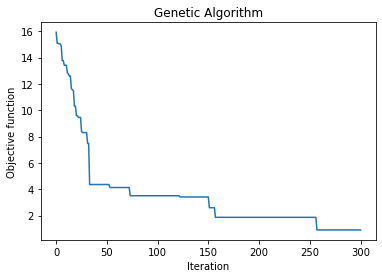

In [68]:
# 실제 모델 
# function: 머신러닝 모델과 연결하여 함수를 만듬 
# dimension: 몇차원의 문제를 푸는 것이냐? 12개의 미지수를 사용함. 
# variable_type: 유전알고리즘이 찾아주는 것을 무엇으로 할 것이냐 int
model_ga_median = geneticalgorithm(function=object_function_median,
                                   dimension=12,
                                   variable_type='int',
                                   variable_boundaries=varbound,
                                   algorithm_parameters=algorithm_param)

model_ga_median.run()

In [69]:
# 최종결과 보기 
# report: 300번 iteration동안 object의 output값
# output_dict: 최종 solution 있음  
convergence_median = model_ga_median.report
solution_median = model_ga_median.output_dict

print(convergence_median) #  
print(solution_median) # 유전알고리즘이 찾은 값
# like수=28178회, dislike=163회

[15.925281903131483, 15.087740943517522, 15.087740943517522, 15.040777083235861, 15.040777083235861, 14.889137803788453, 13.77257748251324, 13.77257748251324, 13.420846656235767, 13.420846656235767, 13.420846656235767, 12.861999411006058, 12.765464122595509, 12.600198708968344, 12.600198708968344, 11.63652709528005, 11.558543937974026, 11.488412461249219, 10.313392788670313, 10.313392788670313, 9.58076534943908, 9.58076534943908, 9.463159223600142, 9.463159223600142, 9.463159223600142, 8.405702815382874, 8.306595609270547, 8.306595609270547, 8.306595609270547, 8.306595609270547, 8.306595609270547, 7.484649502717833, 7.484649502717833, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.363098624788363, 4.3630986247883

In [70]:
ga_solution = input_conversion(solution_median['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)
print(ga_solution)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title_mean_enc,category_id_mean_enc
0,28178.0,163.0,82657.0,390.0,57.0,172.871166,4414.0,55.0,32.0,99.0,44.0,30507.125,1.553969e+06


In [118]:
# mean_encode값을 원래 값으로 원복
channel_title = mean_encode_channel[mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc'])].index[0]
print(mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc']))
ga_solution_df['channel_title_mean_enc'] = channel_title
ga_solution_df = ga_solution_df.rename(columns={'channel_title_mean_enc': 'channel_title'}) #허챠밍

category_id = mean_encode_category[mean_encode_category.isin(ga_solution_df['category_id_mean_enc'])].index[0]
ga_solution_df['category_id_mean_enc'] = category_id
ga_solution_df = ga_solution_df.rename(columns={'category_id_mean_enc': 'category_id'}) # 10
ga_solution_df

KeyError: 'channel_title_mean_enc'

In [72]:
ga_solution_df['category_id'] = category_id_code[str(ga_solution_df['category_id'][0])]
ga_solution_df = ga_solution_df.rename(columns={'category_id': 'category'}) #Music 
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category
0,28178.0,163.0,82657.0,390.0,57.0,172.871166,4414.0,55.0,32.0,99.0,44.0,Kael Reset,Music


In [73]:
prediction = voting_clf.predict(scaler.transform(ga_solution)) # 왜 scaler.transform사용
print(ga_solution)
print(prediction)
ga_solution_df['Views'] = int(prediction[0])
ga_solution_median = ga_solution_df
ga_solution_median

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,28178.0,163.0,82657.0,390.0,57.0,172.871166,4414.0,55.0,32.0,99.0,44.0,Kael Reset,Music,99152


#**9. 결과 검토 및 분석: 일반 YouTuber**

In [74]:
df_rgb2.describe()

,category_id,views,likes,dislikes,comment_count,r_avg,g_avg,b_avg,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
count,6558.000000,6.558000e+03,6.558000e+03,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6.558000e+03,6558.000000,6558.000000,6.558000e+03,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6.558000e+03,6.558000e+03
mean,21.148216,3.702816e+05,1.533824e+04,522.017993,2374.226593,94.588442,87.229643,85.689235,2.541476,1.586026e+04,21.616956,107.952186,7.277071e+03,50.902485,1085.683883,9.780098,432.711040,43.321134,3.702816e+05,3.702816e+05
std,6.779788,1.662346e+06,1.036956e+05,11337.747492,18748.472408,31.165412,29.405352,29.578320,12.456900,1.086795e+05,17.978007,419.561007,4.705238e+04,195.772203,7539.910674,48.145208,537.183225,19.539754,1.361084e+06,3.700064e+05
min,1.000000,2.623000e+03,2.000000e+00,0.000000,0.000000,6.000000,6.000000,4.000000,1.000000,2.000000e+00,1.000000,0.161180,3.703704e-02,0.012151,0.000000,0.185734,1.000000,4.000000,2.623000e+03,2.332710e+04
25%,20.000000,4.455550e+04,6.780000e+02,20.000000,150.000000,74.000000,68.000000,66.000000,2.000000,7.352500e+02,8.000000,14.211516,3.325417e+02,6.400000,66.500000,2.795164,120.000000,28.000000,6.107850e+04,1.309392e+05
50%,24.000000,9.915450e+04,2.019500e+03,54.000000,429.000000,95.000000,87.000000,84.000000,2.000000,2.137500e+03,17.000000,35.212064,9.958333e+02,16.478125,199.000000,5.143421,260.000000,41.000000,1.232558e+05,2.772646e+05
75%,25.000000,2.330775e+05,4.765000e+03,142.000000,1086.750000,116.000000,106.000000,105.000000,2.000000,4.921000e+03,30.000000,78.976690,2.398500e+03,37.797115,520.625000,9.075080,535.000000,55.000000,2.420690e+05,4.091292e+05
max,43.000000,6.279639e+07,4.470923e+06,884965.000000,905925.000000,201.000000,188.000000,188.000000,706.000000,4.589976e+06,126.000000,5325.750000,1.529992e+06,2662.875000,301975.000000,1071.000000,5235.000000,100.000000,5.261173e+07,1.678646e+06


In [75]:
# 일반적인 views를 찾는 모델은 만들었고
# comment_count가 바뀌면 views수가 어떻게 바뀌는지 궁금하다 
inf_input = copy.deepcopy(model_ga_median)

comment_count_dep_median = []

for i in tqdm.tqdm(range(df_rgb2['comment_count'].min(), df_rgb2['comment_count'].max(), 1000)):    
    inf_input.output_dict['variable'][2] = i # [2]가 comment_count자리이기 때문에 이자리에 숫자를 넣어준다.
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    comment_count_dep_median.append([i, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 906/906 [00:16<00:00, 53.43it/s]


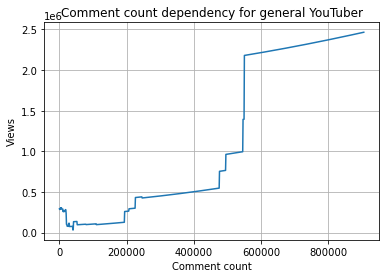

In [76]:
# comment_count가 늘어나면 views가 늘어날 것이다. 
# tree기반알고리즘은 경계에서 값이 튈수있다. 
comment_count_dep_median_df = pd.DataFrame(comment_count_dep_median, columns=['comment_count', 'views'])

plt.title('Comment count dependency for general YouTuber')
plt.xlabel('Comment count')
plt.ylabel('Views')
plt.grid()
plt.plot(comment_count_dep_median_df['comment_count'], comment_count_dep_median_df['views'])

In [77]:
# Positive_ratio바뀌면 views가 어떻게 될지 확인 
# 전제가 total_sign(like수+dislike수의 합)은 변하지 않는다
# like수를 변화시키면 dislike수가 변화할 것이고 이때 Positive_ratio값이 변화하면 views변화를 본다

inf_input = copy.deepcopy(model_ga_median)

positive_ratio_dep_median = []

total_sign = inf_input.output_dict['variable'][0] + inf_input.output_dict['variable'][1]
calculation_plot = 500
step = total_sign / calculation_plot

for i in tqdm.tqdm(np.arange(1, total_sign, step)):    
    inf_input.output_dict['variable'][0] = int(i)
    inf_input.output_dict['variable'][1] = total_sign - int(i)
    ratio = inf_input.output_dict['variable'][0] / inf_input.output_dict['variable'][1]

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    positive_ratio_dep_median.append([ratio, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.90it/s]


<BarContainer object of 500 artists>

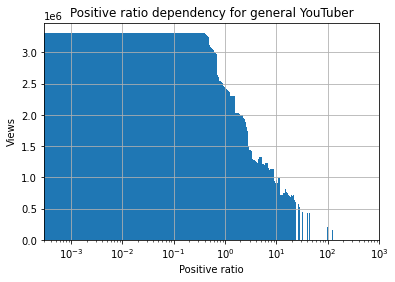

In [78]:
# positive ratio수가 줄어들어야 views수가 늘어난다
positive_ratio_dep_median_df = pd.DataFrame(positive_ratio_dep_median, columns=['positive_ratio', 'views'])

plt.title('Positive ratio dependency for general YouTuber')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.xscale('log')
plt.grid()
plt.bar(positive_ratio_dep_median_df['positive_ratio'], positive_ratio_dep_median_df['views'])


In [79]:
# number_of_tag 변화에 따른 views수 변화 
# tag수가 적은것이 좋다고 함 10개이내로 좋다. 
inf_input = copy.deepcopy(model_ga_median)

number_of_tag_dep_median = []

for i in tqdm.tqdm(range(df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max())):    
    inf_input.output_dict['variable'][4] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    number_of_tag_dep_median.append([i, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 52.28it/s]


<BarContainer object of 125 artists>

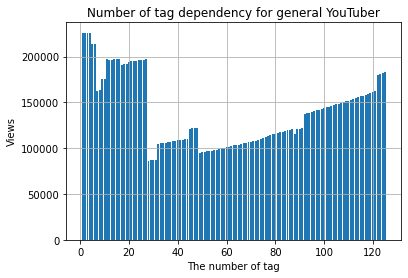

In [80]:
number_of_tag_dep_median_df = pd.DataFrame(number_of_tag_dep_median, columns=['number_of_tag', 'views'])

plt.title('Number of tag dependency for general YouTuber')
plt.xlabel('The number of tag')
plt.ylabel('Views')
plt.grid()
plt.bar(number_of_tag_dep_median_df['number_of_tag'], number_of_tag_dep_median_df['views'])

In [81]:
# 썸네일 변화 (MC시뮬레이션)
# RGB값의 최소최대값에서 랜덤하게 2000개뽑아서 봄 

inf_input = copy.deepcopy(model_ga_median)

random_image_dep_median = []

for i in tqdm.tqdm(range(2000)):    
    inf_input.output_dict['variable'][7] = randint(df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max())
    inf_input.output_dict['variable'][8] = randint(df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max())
    inf_input.output_dict['variable'][9] = randint(df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max())
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    random_image_dep_median.append([i, int(prediction)])

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 51.66it/s]


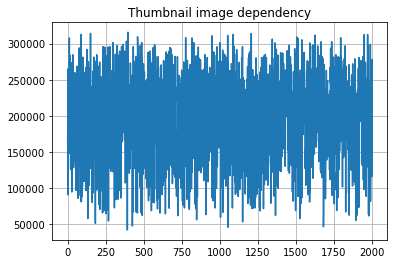

In [82]:
random_image_dep_median_df = pd.DataFrame(random_image_dep_median, columns=['Random_image', 'Views'])

plt.grid()
plt.title('Thumbnail image dependency')
plt.plot(random_image_dep_median_df['Random_image'], random_image_dep_median_df['Views'])

Average views: 201038.151
Median views: 212054.5
Standard deviation of views [count]: 59211.19183912532
Standard deviation of views     [%]: 29.45271409660215


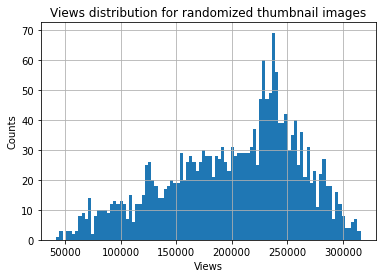

In [83]:
# 썸네일로 views수가 +-29%정도 흔들릴수있다
plt.grid()
plt.title('Views distribution for randomized thumbnail images')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.hist(random_image_dep_median_df['Views'], bins=96)

print('Average views:', random_image_dep_median_df['Views'].mean())
print('Median views:', random_image_dep_median_df['Views'].median())
print('Standard deviation of views [count]:', random_image_dep_median_df['Views'].std())
print('Standard deviation of views     [%]:', random_image_dep_median_df['Views'].std()*100 / random_image_dep_median_df['Views'].mean())

In [84]:
# 채널타이틀 영향
inf_input = copy.deepcopy(model_ga_median)

channel_title_dep_median = []

for i in tqdm.tqdm(range(len(mean_encode_channel))):
    inf_input.output_dict['variable'][10] = i 
    
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    channel_title_dep_median.append([mean_encode_channel.index[i], int(prediction)])

100%|██████████████████████████████████████████████████████████████████████████████| 1478/1478 [00:27<00:00, 53.84it/s]


<BarContainer object of 1478 artists>

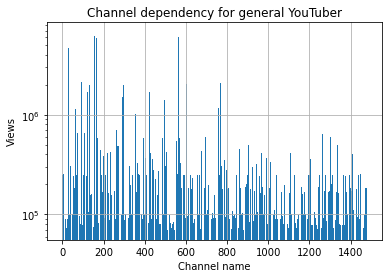

In [85]:
channel_title_dep_median_df = pd.DataFrame(channel_title_dep_median, columns=['channel_title', 'views'])

plt.title('Channel dependency for general YouTuber')
plt.xlabel('Channel name')
plt.ylabel('Views')
plt.yscale('log')
plt.grid()
plt.bar(range(len(channel_title_dep_median_df['channel_title'])), channel_title_dep_median_df['views'])

In [86]:
channel_title_dep_median_df.sort_values(by='views', ascending=False).head(10)

,channel_title,views
178,FoxStarHindi,6730331
624,YouTube Spotlight,6534166
53,ArianaGrandeVevo,6486956
363,Marvel Entertainment,6392606
99,Bruno Mars,6357429
548,TaylorSwiftVEVO,6331435
123,ChildishGambinoVEVO,6299977
677,ibighit,6295508
159,Dude Perfect,6289655
57,AsapSCIENCE,6277763


Average views: 406633.17929634644
Median views: 177300.0
Standard deviation of views [count]: 915080.8034349645
Standard deviation of views     [%]: 225.03840070759972


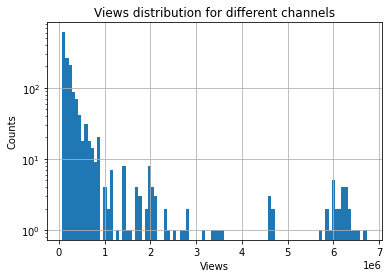

In [87]:
# 일반적인 유튜브영상에는 채널명이 중요하다 
# std가 상당히 크다. 
# 채널이 바뀌면, views수가 줄가능성이 넢다. 왜냐하면 counts수를 보면 더 많은 채널들이 적은 views를 가짐
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_median_df['views'], bins=96)

print('Average views:', channel_title_dep_median_df['views'].mean())
print('Median views:', channel_title_dep_median_df['views'].median())
print('Standard deviation of views [count]:', channel_title_dep_median_df['views'].std())
print('Standard deviation of views     [%]:', channel_title_dep_median_df['views'].std()*100 / channel_title_dep_median_df['views'].mean())

#**10. 유전 알고리즘 - 최적 피쳐 탐색: Top YouTuber**

In [88]:
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()*2],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()*2],
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()*2],
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()*2],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]],
                     [2, 2]])

In [89]:
def object_function_top(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)        

    target = 70000000
    print('Predicted views:', int(prediction), 'Difference from target:', int(target - prediction))

    # return abs(int(prediction) - target)
    return math.log(abs(target - int(prediction))) 

In [90]:
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

Predicted views: 21588733 Difference from target: 48411266
Predicted views: 28250053 Difference from target: 41749946
Predicted views: 32979488 Difference from target: 37020511
Predicted views: 34886988 Difference from target: 35113011
Predicted views: 29035163 Difference from target: 40964836
Predicted views: 38964355 Difference from target: 31035644
Predicted views: 37940298 Difference from target: 32059701
Predicted views: 24977868 Difference from target: 45022131
Predicted views: 27872543 Difference from target: 42127456
Predicted views: 28659246 Difference from target: 41340753
Predicted views: 26313617 Difference from target: 43686382
Predicted views: 31365560 Difference from target: 38634439
Predicted views: 32311759 Difference from target: 37688240
Predicted views: 17379369 Difference from target: 52620630
Predicted views: 28845666 Difference from target: 41154333
Predicted views: 26817100 Difference from target: 43182899
Predicted views: 34296846 Difference from target: 357031

Predicted views: 29804751 Difference from target: 40195248
Predicted views: 39646120 Difference from target: 30353879
Predicted views: 32371600 Difference from target: 37628399
Predicted views: 25622161 Difference from target: 44377838
Predicted views: 31908161 Difference from target: 38091838
Predicted views: 36204442 Difference from target: 33795557
Predicted views: 23771222 Difference from target: 46228777
Predicted views: 27731792 Difference from target: 42268207
Predicted views: 36152996 Difference from target: 33847003
Predicted views: 29700897 Difference from target: 40299102
Predicted views: 32837055 Difference from target: 37162944
Predicted views: 27996536 Difference from target: 42003463
Predicted views: 38653401 Difference from target: 31346598
Predicted views: 28377842 Difference from target: 41622157
Predicted views: 22845361 Difference from target: 47154638
Predicted views: 24729960 Difference from target: 45270039
Predicted views: 29490265 Difference from target: 405097

Predicted views: 27917066 Difference from target: 42082933
Predicted views: 34682855 Difference from target: 35317144
Predicted views: 32326483 Difference from target: 37673516
Predicted views: 29977620 Difference from target: 40022379
Predicted views: 23479437 Difference from target: 46520562
Predicted views: 35181196 Difference from target: 34818803
Predicted views: 27499951 Difference from target: 42500048
Predicted views: 24841221 Difference from target: 45158778
Predicted views: 42972516 Difference from target: 27027483
Predicted views: 30477356 Difference from target: 39522643
Predicted views: 29344406 Difference from target: 40655593
Predicted views: 32647473 Difference from target: 37352526
Predicted views: 28900241 Difference from target: 41099758
Predicted views: 25406985 Difference from target: 44593014
Predicted views: 34723422 Difference from target: 35276577
Predicted views: 26498831 Difference from target: 43501168
Predicted views: 46100360 Difference from target: 238996

Predicted views: 32304790 Difference from target: 37695209
Predicted views: 31527403 Difference from target: 38472596
Predicted views: 45508234 Difference from target: 24491765
Predicted views: 50712717 Difference from target: 19287282
Predicted views: 40410122 Difference from target: 29589877
Predicted views: 50045735 Difference from target: 19954264
Predicted views: 51691631 Difference from target: 18308368
Predicted views: 51439117 Difference from target: 18560882
Predicted views: 38706684 Difference from target: 31293315
Predicted views: 42669481 Difference from target: 27330518
Predicted views: 45820904 Difference from target: 24179095
Predicted views: 34643657 Difference from target: 35356342
Predicted views: 35116668 Difference from target: 34883331
Predicted views: 49144855 Difference from target: 20855144
Predicted views: 31221328 Difference from target: 38778671
Predicted views: 41206351 Difference from target: 28793648
Predicted views: 51737311 Difference from target: 182626

Predicted views: 46897006 Difference from target: 23102993
Predicted views: 48240054 Difference from target: 21759945
Predicted views: 48451838 Difference from target: 21548161
Predicted views: 51666303 Difference from target: 18333696
Predicted views: 25572309 Difference from target: 44427690
Predicted views: 44291036 Difference from target: 25708963
Predicted views: 51801566 Difference from target: 18198433
Predicted views: 45608280 Difference from target: 24391719
Predicted views: 46295011 Difference from target: 23704988
Predicted views: 40038492 Difference from target: 29961507
Predicted views: 32166245 Difference from target: 37833754
Predicted views: 51287829 Difference from target: 18712170
Predicted views: 42022687 Difference from target: 27977312
Predicted views: 29113399 Difference from target: 40886600
Predicted views: 49159950 Difference from target: 20840049
Predicted views: 50405320 Difference from target: 19594679
Predicted views: 45579661 Difference from target: 244203

Predicted views: 45309576 Difference from target: 24690423
Predicted views: 33977496 Difference from target: 36022503
Predicted views: 44351394 Difference from target: 25648605
Predicted views: 51719841 Difference from target: 18280158
Predicted views: 52325086 Difference from target: 17674913
Predicted views: 48470377 Difference from target: 21529622
Predicted views: 50986210 Difference from target: 19013789
Predicted views: 43444038 Difference from target: 26555961
Predicted views: 50531147 Difference from target: 19468852
Predicted views: 47351226 Difference from target: 22648773
Predicted views: 48848564 Difference from target: 21151435
Predicted views: 51516003 Difference from target: 18483996
Predicted views: 50064383 Difference from target: 19935616
Predicted views: 50141995 Difference from target: 19858004
Predicted views: 46364080 Difference from target: 23635919
Predicted views: 27439319 Difference from target: 42560680
Predicted views: 51860704 Difference from target: 181392

Predicted views: 44391791 Difference from target: 25608208
Predicted views: 49401952 Difference from target: 20598047
Predicted views: 50136557 Difference from target: 19863442
Predicted views: 47336507 Difference from target: 22663492
Predicted views: 50837107 Difference from target: 19162892
Predicted views: 42912283 Difference from target: 27087716
Predicted views: 51891919 Difference from target: 18108080
Predicted views: 40827189 Difference from target: 29172810
Predicted views: 52650823 Difference from target: 17349176
Predicted views: 51636173 Difference from target: 18363826
Predicted views: 46122685 Difference from target: 23877314
Predicted views: 52518448 Difference from target: 17481551
Predicted views: 51556608 Difference from target: 18443391
Predicted views: 50366120 Difference from target: 19633879
Predicted views: 47959879 Difference from target: 22040120
Predicted views: 43509433 Difference from target: 26490566
Predicted views: 39139697 Difference from target: 308603

Predicted views: 41076651 Difference from target: 28923348
Predicted views: 51197368 Difference from target: 18802631
Predicted views: 50858682 Difference from target: 19141317
Predicted views: 48338421 Difference from target: 21661578
Predicted views: 49573085 Difference from target: 20426914
Predicted views: 53553328 Difference from target: 16446671
Predicted views: 32391766 Difference from target: 37608233
Predicted views: 37136144 Difference from target: 32863855
Predicted views: 38321977 Difference from target: 31678022
Predicted views: 39760175 Difference from target: 30239824
Predicted views: 51311521 Difference from target: 18688478
Predicted views: 47315307 Difference from target: 22684692
Predicted views: 50349015 Difference from target: 19650984
Predicted views: 50328890 Difference from target: 19671109
Predicted views: 41006650 Difference from target: 28993349
Predicted views: 33266267 Difference from target: 36733732
Predicted views: 49750293 Difference from target: 202497

Predicted views: 48851967 Difference from target: 21148032
Predicted views: 44490008 Difference from target: 25509991
Predicted views: 43339749 Difference from target: 26660250
Predicted views: 49641554 Difference from target: 20358445
Predicted views: 31241618 Difference from target: 38758381
Predicted views: 49983108 Difference from target: 20016891
Predicted views: 49714180 Difference from target: 20285819
Predicted views: 43155539 Difference from target: 26844460
Predicted views: 50059886 Difference from target: 19940113
Predicted views: 50739613 Difference from target: 19260386
Predicted views: 51202479 Difference from target: 18797520
Predicted views: 39924776 Difference from target: 30075223
Predicted views: 53233765 Difference from target: 16766234
Predicted views: 44259661 Difference from target: 25740338
Predicted views: 40671953 Difference from target: 29328046
Predicted views: 49438574 Difference from target: 20561425
Predicted views: 49985773 Difference from target: 200142

Predicted views: 50699703 Difference from target: 19300296
Predicted views: 52243563 Difference from target: 17756436
Predicted views: 20155101 Difference from target: 49844898
Predicted views: 51905052 Difference from target: 18094947
Predicted views: 50950785 Difference from target: 19049214
Predicted views: 41438510 Difference from target: 28561489
Predicted views: 38052746 Difference from target: 31947253
Predicted views: 52423016 Difference from target: 17576983
Predicted views: 38370489 Difference from target: 31629510
Predicted views: 52364864 Difference from target: 17635135
Predicted views: 50705628 Difference from target: 19294371
Predicted views: 43938076 Difference from target: 26061923
Predicted views: 51184697 Difference from target: 18815302
Predicted views: 51191613 Difference from target: 18808386
Predicted views: 50038934 Difference from target: 19961065
Predicted views: 29895478 Difference from target: 40104521
Predicted views: 49806151 Difference from target: 201938

Predicted views: 52468579 Difference from target: 17531420
Predicted views: 39282463 Difference from target: 30717536
Predicted views: 50673901 Difference from target: 19326098
Predicted views: 50358265 Difference from target: 19641734
Predicted views: 49809165 Difference from target: 20190834
Predicted views: 38329532 Difference from target: 31670467
Predicted views: 51395991 Difference from target: 18604008
Predicted views: 46493224 Difference from target: 23506775
Predicted views: 38495550 Difference from target: 31504449
Predicted views: 45303059 Difference from target: 24696940
Predicted views: 52591770 Difference from target: 17408229
Predicted views: 50248157 Difference from target: 19751842
Predicted views: 52785750 Difference from target: 17214249
Predicted views: 51035364 Difference from target: 18964635
Predicted views: 48845420 Difference from target: 21154579
Predicted views: 50737858 Difference from target: 19262141
Predicted views: 49648116 Difference from target: 203518

Predicted views: 47394371 Difference from target: 22605628
Predicted views: 51298165 Difference from target: 18701834
Predicted views: 52616850 Difference from target: 17383149
Predicted views: 50679226 Difference from target: 19320773
Predicted views: 46423445 Difference from target: 23576554
Predicted views: 38757466 Difference from target: 31242533
Predicted views: 51021515 Difference from target: 18978484
Predicted views: 39842145 Difference from target: 30157854
Predicted views: 51901079 Difference from target: 18098920
Predicted views: 30917091 Difference from target: 39082908
Predicted views: 37080518 Difference from target: 32919481
Predicted views: 39459135 Difference from target: 30540864
Predicted views: 52710968 Difference from target: 17289031
Predicted views: 53111952 Difference from target: 16888047
Predicted views: 52220886 Difference from target: 17779113
Predicted views: 39389110 Difference from target: 30610889
Predicted views: 51571524 Difference from target: 184284

Predicted views: 51978046 Difference from target: 18021953
Predicted views: 51896465 Difference from target: 18103534
Predicted views: 41063437 Difference from target: 28936562
Predicted views: 37960034 Difference from target: 32039965
Predicted views: 51069260 Difference from target: 18930739
Predicted views: 41448590 Difference from target: 28551409
Predicted views: 51673289 Difference from target: 18326710
Predicted views: 38342796 Difference from target: 31657203
Predicted views: 40917582 Difference from target: 29082417
Predicted views: 38619108 Difference from target: 31380891
Predicted views: 39804601 Difference from target: 30195398
Predicted views: 51647958 Difference from target: 18352041
Predicted views: 53948776 Difference from target: 16051223
Predicted views: 51978046 Difference from target: 18021953
Predicted views: 40311911 Difference from target: 29688088
Predicted views: 42468365 Difference from target: 27531634
Predicted views: 32741555 Difference from target: 372584

Predicted views: 48290784 Difference from target: 21709215
Predicted views: 47024083 Difference from target: 22975916
Predicted views: 48355389 Difference from target: 21644610
Predicted views: 52541891 Difference from target: 17458108
Predicted views: 52541891 Difference from target: 17458108
Predicted views: 38098652 Difference from target: 31901347
Predicted views: 51902066 Difference from target: 18097933
Predicted views: 51417404 Difference from target: 18582595
Predicted views: 35469767 Difference from target: 34530232
Predicted views: 41037371 Difference from target: 28962628
Predicted views: 53487764 Difference from target: 16512235
Predicted views: 42752796 Difference from target: 27247203
Predicted views: 48111068 Difference from target: 21888931
Predicted views: 41458231 Difference from target: 28541768
Predicted views: 53916874 Difference from target: 16083125
Predicted views: 39680761 Difference from target: 30319238
Predicted views: 38292233 Difference from target: 317077

Predicted views: 40629251 Difference from target: 29370748
Predicted views: 54112483 Difference from target: 15887516
Predicted views: 28212338 Difference from target: 41787661
Predicted views: 28221080 Difference from target: 41778919
Predicted views: 47621025 Difference from target: 22378974
Predicted views: 51800402 Difference from target: 18199597
Predicted views: 49686259 Difference from target: 20313740
Predicted views: 38676549 Difference from target: 31323450
Predicted views: 52917172 Difference from target: 17082827
Predicted views: 53076680 Difference from target: 16923319
Predicted views: 50045067 Difference from target: 19954932
Predicted views: 40139238 Difference from target: 29860761
Predicted views: 51270952 Difference from target: 18729047
Predicted views: 52310893 Difference from target: 17689106
Predicted views: 52603235 Difference from target: 17396764
Predicted views: 52082331 Difference from target: 17917668
Predicted views: 32226153 Difference from target: 377738

Predicted views: 50118905 Difference from target: 19881094
Predicted views: 52972940 Difference from target: 17027059
Predicted views: 52147004 Difference from target: 17852995
Predicted views: 41230840 Difference from target: 28769159
Predicted views: 49473471 Difference from target: 20526528
Predicted views: 51734409 Difference from target: 18265590
Predicted views: 38250908 Difference from target: 31749091
Predicted views: 50081150 Difference from target: 19918849
Predicted views: 39188055 Difference from target: 30811944
Predicted views: 34479675 Difference from target: 35520324
Predicted views: 52174820 Difference from target: 17825179
Predicted views: 50790107 Difference from target: 19209892
Predicted views: 50641194 Difference from target: 19358805
Predicted views: 49425595 Difference from target: 20574404
Predicted views: 51533051 Difference from target: 18466948
Predicted views: 51457036 Difference from target: 18542963
Predicted views: 51649648 Difference from target: 183503

Predicted views: 49253892 Difference from target: 20746107
Predicted views: 38868761 Difference from target: 31131238
Predicted views: 39526931 Difference from target: 30473068
Predicted views: 39934684 Difference from target: 30065315
Predicted views: 38868761 Difference from target: 31131238
Predicted views: 40333057 Difference from target: 29666942
Predicted views: 51355566 Difference from target: 18644433
Predicted views: 51633738 Difference from target: 18366261
Predicted views: 40840440 Difference from target: 29159559
Predicted views: 50980290 Difference from target: 19019709
Predicted views: 40779166 Difference from target: 29220833
Predicted views: 50873508 Difference from target: 19126491
Predicted views: 38084942 Difference from target: 31915057
Predicted views: 38868761 Difference from target: 31131238
Predicted views: 38868761 Difference from target: 31131238
Predicted views: 53278988 Difference from target: 16721011
Predicted views: 44897501 Difference from target: 251024

Predicted views: 52082946 Difference from target: 17917053
Predicted views: 53677742 Difference from target: 16322257
Predicted views: 52760224 Difference from target: 17239775
Predicted views: 28976198 Difference from target: 41023801
Predicted views: 52368139 Difference from target: 17631860
Predicted views: 53642236 Difference from target: 16357763
Predicted views: 52514406 Difference from target: 17485593
Predicted views: 51348019 Difference from target: 18651980
Predicted views: 52187304 Difference from target: 17812695
Predicted views: 48200466 Difference from target: 21799533
Predicted views: 48009814 Difference from target: 21990185
Predicted views: 53171866 Difference from target: 16828133
Predicted views: 50989474 Difference from target: 19010525
Predicted views: 47376030 Difference from target: 22623969
Predicted views: 47871196 Difference from target: 22128803
Predicted views: 33885885 Difference from target: 36114114
Predicted views: 41223529 Difference from target: 287764

Predicted views: 25544474 Difference from target: 44455525
Predicted views: 26295154 Difference from target: 43704845
Predicted views: 54488477 Difference from target: 15511522
Predicted views: 54488477 Difference from target: 15511522
Predicted views: 52518708 Difference from target: 17481291
Predicted views: 52086748 Difference from target: 17913251
Predicted views: 51583892 Difference from target: 18416107
Predicted views: 52082721 Difference from target: 17917278
Predicted views: 44770344 Difference from target: 25229655
Predicted views: 39217580 Difference from target: 30782419
Predicted views: 38946390 Difference from target: 31053609
Predicted views: 37682989 Difference from target: 32317010
Predicted views: 50429294 Difference from target: 19570705
Predicted views: 52692777 Difference from target: 17307222
Predicted views: 50467525 Difference from target: 19532474
Predicted views: 50395487 Difference from target: 19604512
Predicted views: 53355574 Difference from target: 166444

Predicted views: 33708822 Difference from target: 36291177
Predicted views: 38720979 Difference from target: 31279020
Predicted views: 48837182 Difference from target: 21162817
Predicted views: 52726802 Difference from target: 17273197
Predicted views: 38549237 Difference from target: 31450762
Predicted views: 37831773 Difference from target: 32168226
Predicted views: 52014036 Difference from target: 17985963
Predicted views: 51531843 Difference from target: 18468156
Predicted views: 48473363 Difference from target: 21526636
Predicted views: 52801352 Difference from target: 17198647
Predicted views: 28773065 Difference from target: 41226934
Predicted views: 28602729 Difference from target: 41397270
Predicted views: 44675581 Difference from target: 25324418
Predicted views: 38690314 Difference from target: 31309685
Predicted views: 39565037 Difference from target: 30434962
Predicted views: 49042376 Difference from target: 20957623
Predicted views: 53877967 Difference from target: 161220

Predicted views: 40081848 Difference from target: 29918151
Predicted views: 51705169 Difference from target: 18294830
Predicted views: 39522672 Difference from target: 30477327
Predicted views: 40752090 Difference from target: 29247909
Predicted views: 38749221 Difference from target: 31250778
Predicted views: 52018625 Difference from target: 17981374
Predicted views: 53389456 Difference from target: 16610543
Predicted views: 50386929 Difference from target: 19613070
Predicted views: 50122923 Difference from target: 19877076
Predicted views: 53348037 Difference from target: 16651962
Predicted views: 53702268 Difference from target: 16297731
Predicted views: 46961055 Difference from target: 23038944
Predicted views: 51118684 Difference from target: 18881315
Predicted views: 53672620 Difference from target: 16327379
Predicted views: 28876468 Difference from target: 41123531
Predicted views: 32142764 Difference from target: 37857235
Predicted views: 51453887 Difference from target: 185461

Predicted views: 25984146 Difference from target: 44015853
Predicted views: 36388246 Difference from target: 33611753
Predicted views: 53889816 Difference from target: 16110183
Predicted views: 47986939 Difference from target: 22013060
Predicted views: 37142959 Difference from target: 32857040
Predicted views: 52732505 Difference from target: 17267494
Predicted views: 51223939 Difference from target: 18776060
Predicted views: 48936894 Difference from target: 21063105
Predicted views: 53705365 Difference from target: 16294634
Predicted views: 47087069 Difference from target: 22912930
Predicted views: 47139280 Difference from target: 22860719
Predicted views: 43094435 Difference from target: 26905564
Predicted views: 48479791 Difference from target: 21520208
Predicted views: 45514981 Difference from target: 24485018
Predicted views: 48513921 Difference from target: 21486078
Predicted views: 39600004 Difference from target: 30399995
Predicted views: 50905293 Difference from target: 190947

Predicted views: 54775949 Difference from target: 15224050
Predicted views: 53416407 Difference from target: 16583592
Predicted views: 41266237 Difference from target: 28733762
Predicted views: 42954986 Difference from target: 27045013
Predicted views: 52395365 Difference from target: 17604634
Predicted views: 42195094 Difference from target: 27804905
Predicted views: 53333244 Difference from target: 16666755
Predicted views: 40224448 Difference from target: 29775551
Predicted views: 53825348 Difference from target: 16174651
Predicted views: 31564154 Difference from target: 38435845
Predicted views: 16619821 Difference from target: 53380178
Predicted views: 31107191 Difference from target: 38892808
Predicted views: 52799167 Difference from target: 17200832
Predicted views: 40295632 Difference from target: 29704367
Predicted views: 53410487 Difference from target: 16589512
Predicted views: 43672481 Difference from target: 26327518
Predicted views: 39820154 Difference from target: 301798

Predicted views: 41238077 Difference from target: 28761922
Predicted views: 47959971 Difference from target: 22040028
Predicted views: 51674195 Difference from target: 18325804
Predicted views: 53856726 Difference from target: 16143273
Predicted views: 30342861 Difference from target: 39657138
Predicted views: 41070992 Difference from target: 28929007
Predicted views: 53347065 Difference from target: 16652934
Predicted views: 38900052 Difference from target: 31099947
Predicted views: 40980030 Difference from target: 29019969
Predicted views: 53212000 Difference from target: 16787999
Predicted views: 53569829 Difference from target: 16430170
Predicted views: 53306400 Difference from target: 16693599
Predicted views: 40210725 Difference from target: 29789274
Predicted views: 40658321 Difference from target: 29341678
Predicted views: 44597892 Difference from target: 25402107
Predicted views: 52417233 Difference from target: 17582766
Predicted views: 39058402 Difference from target: 309415

Predicted views: 54386897 Difference from target: 15613102
Predicted views: 52579375 Difference from target: 17420624
Predicted views: 42130538 Difference from target: 27869461
Predicted views: 37497387 Difference from target: 32502612
Predicted views: 48624944 Difference from target: 21375055
Predicted views: 51596981 Difference from target: 18403018
Predicted views: 46891050 Difference from target: 23108949
Predicted views: 47126251 Difference from target: 22873748
Predicted views: 53524219 Difference from target: 16475780
Predicted views: 41059472 Difference from target: 28940527
Predicted views: 39582422 Difference from target: 30417577
Predicted views: 39661671 Difference from target: 30338328
Predicted views: 39893525 Difference from target: 30106474
Predicted views: 54382973 Difference from target: 15617026
Predicted views: 54567921 Difference from target: 15432078
Predicted views: 29964467 Difference from target: 40035532
Predicted views: 52304968 Difference from target: 176950

Predicted views: 40963114 Difference from target: 29036885
Predicted views: 41301258 Difference from target: 28698741
Predicted views: 52713898 Difference from target: 17286101
Predicted views: 48404517 Difference from target: 21595482
Predicted views: 54590831 Difference from target: 15409168
Predicted views: 54549583 Difference from target: 15450416
Predicted views: 39927495 Difference from target: 30072504
Predicted views: 39927495 Difference from target: 30072504
Predicted views: 47921117 Difference from target: 22078882
Predicted views: 53807057 Difference from target: 16192942
Predicted views: 28308328 Difference from target: 41691671
Predicted views: 40143582 Difference from target: 29856417
Predicted views: 40634553 Difference from target: 29365446
Predicted views: 48456802 Difference from target: 21543197
Predicted views: 34334234 Difference from target: 35665765
Predicted views: 52811124 Difference from target: 17188875
Predicted views: 47493557 Difference from target: 225064

Predicted views: 37940927 Difference from target: 32059072
Predicted views: 39403240 Difference from target: 30596759
Predicted views: 52483789 Difference from target: 17516210
Predicted views: 51951200 Difference from target: 18048799
Predicted views: 37467669 Difference from target: 32532330
Predicted views: 46279703 Difference from target: 23720296
Predicted views: 38187922 Difference from target: 31812077
Predicted views: 53479591 Difference from target: 16520408
Predicted views: 40645664 Difference from target: 29354335
Predicted views: 53709904 Difference from target: 16290095
Predicted views: 41029962 Difference from target: 28970037
Predicted views: 53836730 Difference from target: 16163269
Predicted views: 38121533 Difference from target: 31878466
Predicted views: 40138955 Difference from target: 29861044
Predicted views: 40038726 Difference from target: 29961273
Predicted views: 49875475 Difference from target: 20124524
Predicted views: 39087179 Difference from target: 309128

Predicted views: 40471803 Difference from target: 29528196
Predicted views: 50032063 Difference from target: 19967936
Predicted views: 40669372 Difference from target: 29330627
Predicted views: 50403964 Difference from target: 19596035
Predicted views: 39163331 Difference from target: 30836668
Predicted views: 54633877 Difference from target: 15366122
Predicted views: 47814317 Difference from target: 22185682
Predicted views: 52849522 Difference from target: 17150477
Predicted views: 42057870 Difference from target: 27942129
Predicted views: 51910989 Difference from target: 18089010
Predicted views: 38713840 Difference from target: 31286159
Predicted views: 48444333 Difference from target: 21555666
Predicted views: 40308454 Difference from target: 29691545
Predicted views: 54193802 Difference from target: 15806197
Predicted views: 41162508 Difference from target: 28837491
Predicted views: 41162508 Difference from target: 28837491
Predicted views: 36951975 Difference from target: 330480

Predicted views: 49086112 Difference from target: 20913887
Predicted views: 50054009 Difference from target: 19945990
Predicted views: 49531327 Difference from target: 20468672
Predicted views: 50957266 Difference from target: 19042733
Predicted views: 51169979 Difference from target: 18830020
Predicted views: 39946623 Difference from target: 30053376
Predicted views: 47459364 Difference from target: 22540635
Predicted views: 49608963 Difference from target: 20391036
Predicted views: 49607964 Difference from target: 20392035
Predicted views: 51762242 Difference from target: 18237757
Predicted views: 39411424 Difference from target: 30588575
Predicted views: 38524661 Difference from target: 31475338
Predicted views: 50524687 Difference from target: 19475312
Predicted views: 39407552 Difference from target: 30592447
Predicted views: 50468686 Difference from target: 19531313
Predicted views: 33401801 Difference from target: 36598198
Predicted views: 49950279 Difference from target: 200497

Predicted views: 48707450 Difference from target: 21292549
Predicted views: 53410443 Difference from target: 16589556
Predicted views: 52904501 Difference from target: 17095498
Predicted views: 51264132 Difference from target: 18735867
Predicted views: 40651410 Difference from target: 29348589
Predicted views: 48925456 Difference from target: 21074543
Predicted views: 42361787 Difference from target: 27638212
Predicted views: 51231069 Difference from target: 18768930
Predicted views: 38075683 Difference from target: 31924316
Predicted views: 53164353 Difference from target: 16835646
Predicted views: 50565824 Difference from target: 19434175
Predicted views: 41632865 Difference from target: 28367134
Predicted views: 52931311 Difference from target: 17068688
Predicted views: 48248997 Difference from target: 21751002
Predicted views: 52379981 Difference from target: 17620018
Predicted views: 25033163 Difference from target: 44966836
Predicted views: 40716211 Difference from target: 292837

Predicted views: 53383452 Difference from target: 16616547
Predicted views: 50416289 Difference from target: 19583710
Predicted views: 54029319 Difference from target: 15970680
Predicted views: 51169676 Difference from target: 18830323
Predicted views: 52161740 Difference from target: 17838259
Predicted views: 35617693 Difference from target: 34382306
Predicted views: 54124417 Difference from target: 15875582
Predicted views: 51301795 Difference from target: 18698204
Predicted views: 53431208 Difference from target: 16568791
Predicted views: 53531597 Difference from target: 16468402
Predicted views: 51712356 Difference from target: 18287643
Predicted views: 41935438 Difference from target: 28064561
Predicted views: 48415377 Difference from target: 21584622
Predicted views: 48548745 Difference from target: 21451254
Predicted views: 41190472 Difference from target: 28809527
Predicted views: 41423816 Difference from target: 28576183
Predicted views: 46724939 Difference from target: 232750

||||||||||________________________________________ 20.3% GA is running...Predicted views: 52754526 Difference from target: 17245473
Predicted views: 53117692 Difference from target: 16882307
Predicted views: 47555223 Difference from target: 22444776
Predicted views: 47121611 Difference from target: 22878388
Predicted views: 53708855 Difference from target: 16291144
Predicted views: 53268443 Difference from target: 16731556
Predicted views: 54056560 Difference from target: 15943439
Predicted views: 54940909 Difference from target: 15059090
Predicted views: 52051377 Difference from target: 17948622
Predicted views: 38100063 Difference from target: 31899936
Predicted views: 50871345 Difference from target: 19128654
Predicted views: 52917604 Difference from target: 17082395
Predicted views: 40227037 Difference from target: 29772962
Predicted views: 45267936 Difference from target: 24732063
Predicted views: 39809625 Difference from target: 30190374
Predicted views: 53651958 Difference from 

Predicted views: 49009932 Difference from target: 20990067
Predicted views: 39660577 Difference from target: 30339422
Predicted views: 52385871 Difference from target: 17614128
||||||||||________________________________________ 21.0% GA is running...Predicted views: 54816468 Difference from target: 15183531
Predicted views: 54940909 Difference from target: 15059090
Predicted views: 54042979 Difference from target: 15957020
Predicted views: 54132975 Difference from target: 15867024
Predicted views: 27221949 Difference from target: 42778050
Predicted views: 52871884 Difference from target: 17128115
Predicted views: 54938102 Difference from target: 15061897
Predicted views: 45627191 Difference from target: 24372808
Predicted views: 52048168 Difference from target: 17951831
Predicted views: 52747685 Difference from target: 17252314
Predicted views: 46593264 Difference from target: 23406735
Predicted views: 54338620 Difference from target: 15661379
Predicted views: 53116803 Difference from 

Predicted views: 52768143 Difference from target: 17231856
Predicted views: 51008521 Difference from target: 18991478
Predicted views: 40617086 Difference from target: 29382913
Predicted views: 39014473 Difference from target: 30985526
|||||||||||_______________________________________ 21.7% GA is running...Predicted views: 41608819 Difference from target: 28391180
Predicted views: 53841734 Difference from target: 16158265
Predicted views: 53479081 Difference from target: 16520918
Predicted views: 39882188 Difference from target: 30117811
Predicted views: 47915984 Difference from target: 22084015
Predicted views: 39914767 Difference from target: 30085232
Predicted views: 39951939 Difference from target: 30048060
Predicted views: 51997281 Difference from target: 18002718
Predicted views: 41403910 Difference from target: 28596089
Predicted views: 45630680 Difference from target: 24369319
Predicted views: 53754355 Difference from target: 16245644
Predicted views: 53589302 Difference from 

Predicted views: 46817732 Difference from target: 23182267
|||||||||||_______________________________________ 22.3% GA is running...Predicted views: 39859937 Difference from target: 30140062
Predicted views: 50459996 Difference from target: 19540003
Predicted views: 28427460 Difference from target: 41572539
Predicted views: 50815689 Difference from target: 19184310
Predicted views: 51749242 Difference from target: 18250757
Predicted views: 39868833 Difference from target: 30131166
Predicted views: 49628124 Difference from target: 20371875
Predicted views: 32521733 Difference from target: 37478266
Predicted views: 53274834 Difference from target: 16725165
Predicted views: 54447177 Difference from target: 15552822
Predicted views: 42627646 Difference from target: 27372353
Predicted views: 34044475 Difference from target: 35955524
Predicted views: 46878637 Difference from target: 23121362
Predicted views: 53155067 Difference from target: 16844932
Predicted views: 29351381 Difference from 

Predicted views: 40761752 Difference from target: 29238247
||||||||||||______________________________________ 23.0% GA is running...Predicted views: 54081015 Difference from target: 15918984
Predicted views: 36964110 Difference from target: 33035889
Predicted views: 50396075 Difference from target: 19603924
Predicted views: 52370526 Difference from target: 17629473
Predicted views: 40487514 Difference from target: 29512485
Predicted views: 42260319 Difference from target: 27739680
Predicted views: 40117112 Difference from target: 29882887
Predicted views: 54308698 Difference from target: 15691301
Predicted views: 40239385 Difference from target: 29760614
Predicted views: 36900889 Difference from target: 33099110
Predicted views: 43206793 Difference from target: 26793206
Predicted views: 41432975 Difference from target: 28567024
Predicted views: 40410682 Difference from target: 29589317
Predicted views: 35171861 Difference from target: 34828138
Predicted views: 52518567 Difference from 

Predicted views: 46465119 Difference from target: 23534880
Predicted views: 50232049 Difference from target: 19767950
Predicted views: 52091324 Difference from target: 17908675
Predicted views: 40287489 Difference from target: 29712510
||||||||||||______________________________________ 23.7% GA is running...Predicted views: 53891213 Difference from target: 16108786
Predicted views: 40537056 Difference from target: 29462943
Predicted views: 47450488 Difference from target: 22549511
Predicted views: 40381384 Difference from target: 29618615
Predicted views: 31678285 Difference from target: 38321714
Predicted views: 17712226 Difference from target: 52287773
Predicted views: 40204879 Difference from target: 29795120
Predicted views: 53554217 Difference from target: 16445782
Predicted views: 32196941 Difference from target: 37803058
Predicted views: 51251838 Difference from target: 18748161
Predicted views: 43048242 Difference from target: 26951757
Predicted views: 48240687 Difference from 

Predicted views: 53875151 Difference from target: 16124848
Predicted views: 32565850 Difference from target: 37434149
Predicted views: 41649731 Difference from target: 28350268
Predicted views: 47999180 Difference from target: 22000819
Predicted views: 53404910 Difference from target: 16595089
Predicted views: 38163376 Difference from target: 31836623
Predicted views: 52892758 Difference from target: 17107241
||||||||||||______________________________________ 24.3% GA is running...Predicted views: 54677646 Difference from target: 15322353
Predicted views: 51069368 Difference from target: 18930631
Predicted views: 41376535 Difference from target: 28623464
Predicted views: 47502083 Difference from target: 22497916
Predicted views: 50009986 Difference from target: 19990013
Predicted views: 53821552 Difference from target: 16178447
Predicted views: 47544486 Difference from target: 22455513
Predicted views: 54323010 Difference from target: 15676989
Predicted views: 53774775 Difference from 

Predicted views: 53238861 Difference from target: 16761138
Predicted views: 52188834 Difference from target: 17811165
Predicted views: 32506031 Difference from target: 37493968
Predicted views: 53148399 Difference from target: 16851600
Predicted views: 33156727 Difference from target: 36843272
Predicted views: 41172440 Difference from target: 28827559
Predicted views: 40828636 Difference from target: 29171363
Predicted views: 54569886 Difference from target: 15430113
Predicted views: 51467395 Difference from target: 18532604
||||||||||||______________________________________ 25.0% GA is running...Predicted views: 47581556 Difference from target: 22418443
Predicted views: 41164147 Difference from target: 28835852
Predicted views: 40438912 Difference from target: 29561087
Predicted views: 27747533 Difference from target: 42252466
Predicted views: 40616472 Difference from target: 29383527
Predicted views: 53927148 Difference from target: 16072851
Predicted views: 52027843 Difference from 

Predicted views: 53638527 Difference from target: 16361472
Predicted views: 40681438 Difference from target: 29318561
Predicted views: 53374191 Difference from target: 16625808
Predicted views: 52070476 Difference from target: 17929523
Predicted views: 52436434 Difference from target: 17563565
Predicted views: 41369694 Difference from target: 28630305
Predicted views: 53920792 Difference from target: 16079207
Predicted views: 42033821 Difference from target: 27966178
Predicted views: 53337980 Difference from target: 16662019
Predicted views: 41847777 Difference from target: 28152222
Predicted views: 51825259 Difference from target: 18174740
|||||||||||||_____________________________________ 25.7% GA is running...Predicted views: 29242574 Difference from target: 40757425
Predicted views: 54122339 Difference from target: 15877660
Predicted views: 36322827 Difference from target: 33677172
Predicted views: 41987425 Difference from target: 28012574
Predicted views: 41540804 Difference from 

Predicted views: 51675787 Difference from target: 18324212
Predicted views: 42364311 Difference from target: 27635688
Predicted views: 41780452 Difference from target: 28219547
Predicted views: 32018780 Difference from target: 37981219
Predicted views: 54529183 Difference from target: 15470816
Predicted views: 42222573 Difference from target: 27777426
Predicted views: 52300805 Difference from target: 17699194
Predicted views: 53397851 Difference from target: 16602148
Predicted views: 53230773 Difference from target: 16769226
Predicted views: 31948064 Difference from target: 38051935
Predicted views: 52405482 Difference from target: 17594517
Predicted views: 41024844 Difference from target: 28975155
|||||||||||||_____________________________________ 26.3% GA is running...Predicted views: 42070086 Difference from target: 27929913
Predicted views: 42350174 Difference from target: 27649825
Predicted views: 39673505 Difference from target: 30326494
Predicted views: 40885652 Difference from 

Predicted views: 28630085 Difference from target: 41369914
Predicted views: 29947698 Difference from target: 40052301
Predicted views: 40904746 Difference from target: 29095253
Predicted views: 40906155 Difference from target: 29093844
Predicted views: 42046282 Difference from target: 27953717
Predicted views: 29187132 Difference from target: 40812867
Predicted views: 39954288 Difference from target: 30045711
Predicted views: 28630991 Difference from target: 41369008
Predicted views: 41621804 Difference from target: 28378195
Predicted views: 39762800 Difference from target: 30237199
Predicted views: 40875022 Difference from target: 29124977
Predicted views: 41276534 Difference from target: 28723465
Predicted views: 36920262 Difference from target: 33079737
Predicted views: 39310601 Difference from target: 30689398
Predicted views: 40885652 Difference from target: 29114347
||||||||||||||____________________________________ 27.0% GA is running...Predicted views: 43276112 Difference from 

Predicted views: 39171758 Difference from target: 30828241
Predicted views: 52511145 Difference from target: 17488854
Predicted views: 40099947 Difference from target: 29900052
Predicted views: 52461536 Difference from target: 17538463
Predicted views: 38321072 Difference from target: 31678927
Predicted views: 42757214 Difference from target: 27242785
Predicted views: 38384587 Difference from target: 31615412
Predicted views: 45529485 Difference from target: 24470514
Predicted views: 27823396 Difference from target: 42176603
Predicted views: 31997575 Difference from target: 38002424
Predicted views: 49157955 Difference from target: 20842044
Predicted views: 31220834 Difference from target: 38779165
Predicted views: 43274135 Difference from target: 26725864
Predicted views: 45923913 Difference from target: 24076086
Predicted views: 53233145 Difference from target: 16766854
Predicted views: 54966842 Difference from target: 15033157
||||||||||||||____________________________________ 27.7%

Predicted views: 32246667 Difference from target: 37753332
Predicted views: 31384330 Difference from target: 38615669
Predicted views: 42338052 Difference from target: 27661947
Predicted views: 47476854 Difference from target: 22523145
Predicted views: 52684403 Difference from target: 17315596
Predicted views: 41005841 Difference from target: 28994158
Predicted views: 40566507 Difference from target: 29433492
Predicted views: 47520867 Difference from target: 22479132
Predicted views: 40195939 Difference from target: 29804060
Predicted views: 47707771 Difference from target: 22292228
Predicted views: 52152707 Difference from target: 17847292
Predicted views: 41611673 Difference from target: 28388326
Predicted views: 53133980 Difference from target: 16866019
Predicted views: 51338867 Difference from target: 18661132
Predicted views: 31534456 Difference from target: 38465543
Predicted views: 53265010 Difference from target: 16734989
Predicted views: 53889367 Difference from target: 161106

Predicted views: 41038345 Difference from target: 28961654
Predicted views: 40290437 Difference from target: 29709562
Predicted views: 46053966 Difference from target: 23946033
Predicted views: 39007617 Difference from target: 30992382
Predicted views: 52164662 Difference from target: 17835337
Predicted views: 40881708 Difference from target: 29118291
Predicted views: 54462104 Difference from target: 15537895
Predicted views: 53524158 Difference from target: 16475841
Predicted views: 41191756 Difference from target: 28808243
Predicted views: 53272754 Difference from target: 16727245
Predicted views: 51129262 Difference from target: 18870737
Predicted views: 54238958 Difference from target: 15761041
Predicted views: 51395703 Difference from target: 18604296
Predicted views: 32772416 Difference from target: 37227583
Predicted views: 44845712 Difference from target: 25154287
Predicted views: 54826415 Difference from target: 15173584
Predicted views: 54503195 Difference from target: 154968

Predicted views: 54144082 Difference from target: 15855917
Predicted views: 45593881 Difference from target: 24406118
Predicted views: 53367258 Difference from target: 16632741
Predicted views: 53141789 Difference from target: 16858210
Predicted views: 46411955 Difference from target: 23588044
Predicted views: 48222397 Difference from target: 21777602
Predicted views: 53604611 Difference from target: 16395388
Predicted views: 44525218 Difference from target: 25474781
Predicted views: 55005750 Difference from target: 14994249
Predicted views: 54834870 Difference from target: 15165129
Predicted views: 45570197 Difference from target: 24429802
Predicted views: 52271389 Difference from target: 17728610
Predicted views: 47276766 Difference from target: 22723233
Predicted views: 43131842 Difference from target: 26868157
Predicted views: 40710105 Difference from target: 29289894
Predicted views: 53492394 Difference from target: 16507605
Predicted views: 52062143 Difference from target: 179378

Predicted views: 43834320 Difference from target: 26165679
Predicted views: 51118746 Difference from target: 18881253
Predicted views: 52455736 Difference from target: 17544263
Predicted views: 44010830 Difference from target: 25989169
Predicted views: 53531730 Difference from target: 16468269
Predicted views: 52980794 Difference from target: 17019205
Predicted views: 52709040 Difference from target: 17290959
Predicted views: 46412658 Difference from target: 23587341
Predicted views: 48830139 Difference from target: 21169860
Predicted views: 51465672 Difference from target: 18534327
Predicted views: 53436502 Difference from target: 16563497
Predicted views: 52904949 Difference from target: 17095050
Predicted views: 51542113 Difference from target: 18457886
Predicted views: 46203011 Difference from target: 23796988
Predicted views: 50680958 Difference from target: 19319041
Predicted views: 52921786 Difference from target: 17078213
Predicted views: 53506655 Difference from target: 164933

Predicted views: 39147495 Difference from target: 30852504
Predicted views: 41160820 Difference from target: 28839179
Predicted views: 53101613 Difference from target: 16898386
Predicted views: 52482649 Difference from target: 17517350
Predicted views: 33000327 Difference from target: 36999672
Predicted views: 53932123 Difference from target: 16067876
Predicted views: 53570670 Difference from target: 16429329
Predicted views: 54172214 Difference from target: 15827785
Predicted views: 44452798 Difference from target: 25547201
Predicted views: 45503856 Difference from target: 24496143
Predicted views: 47955681 Difference from target: 22044318
Predicted views: 53071413 Difference from target: 16928586
Predicted views: 52952797 Difference from target: 17047202
Predicted views: 53974128 Difference from target: 16025871
Predicted views: 42929809 Difference from target: 27070190
Predicted views: 40253426 Difference from target: 29746573
Predicted views: 53238733 Difference from target: 167612

Predicted views: 34879542 Difference from target: 35120457
Predicted views: 32815631 Difference from target: 37184368
Predicted views: 49734102 Difference from target: 20265897
Predicted views: 47373371 Difference from target: 22626628
Predicted views: 38499000 Difference from target: 31500999
Predicted views: 42066531 Difference from target: 27933468
Predicted views: 51258262 Difference from target: 18741737
Predicted views: 50487382 Difference from target: 19512617
Predicted views: 51814706 Difference from target: 18185293
Predicted views: 45914879 Difference from target: 24085120
Predicted views: 50451770 Difference from target: 19548229
Predicted views: 37517222 Difference from target: 32482777
Predicted views: 34419272 Difference from target: 35580727
Predicted views: 32001263 Difference from target: 37998736
Predicted views: 52522568 Difference from target: 17477431
Predicted views: 47977148 Difference from target: 22022851
Predicted views: 53363047 Difference from target: 166369

Predicted views: 48369504 Difference from target: 21630495
Predicted views: 38230272 Difference from target: 31769727
Predicted views: 48393768 Difference from target: 21606231
Predicted views: 53900947 Difference from target: 16099052
Predicted views: 32837265 Difference from target: 37162734
Predicted views: 47000993 Difference from target: 22999006
Predicted views: 52401282 Difference from target: 17598717
Predicted views: 47131222 Difference from target: 22868777
Predicted views: 50657567 Difference from target: 19342432
Predicted views: 51590954 Difference from target: 18409045
Predicted views: 48977106 Difference from target: 21022893
Predicted views: 51503712 Difference from target: 18496287
Predicted views: 51601854 Difference from target: 18398145
Predicted views: 36258311 Difference from target: 33741688
Predicted views: 52612091 Difference from target: 17387908
Predicted views: 38346687 Difference from target: 31653312
Predicted views: 51109609 Difference from target: 188903

Predicted views: 47340115 Difference from target: 22659884
Predicted views: 39777474 Difference from target: 30222525
Predicted views: 46112441 Difference from target: 23887558
Predicted views: 31873159 Difference from target: 38126840
Predicted views: 49860422 Difference from target: 20139577
Predicted views: 32843783 Difference from target: 37156216
Predicted views: 51696698 Difference from target: 18303301
Predicted views: 39868151 Difference from target: 30131848
Predicted views: 46217473 Difference from target: 23782526
Predicted views: 46938091 Difference from target: 23061908
Predicted views: 52759724 Difference from target: 17240275
Predicted views: 40753494 Difference from target: 29246505
Predicted views: 44974835 Difference from target: 25025164
Predicted views: 53464951 Difference from target: 16535048
Predicted views: 46528339 Difference from target: 23471660
Predicted views: 51608356 Difference from target: 18391643
Predicted views: 47179522 Difference from target: 228204

Predicted views: 38325789 Difference from target: 31674210
Predicted views: 41102345 Difference from target: 28897654
Predicted views: 40496670 Difference from target: 29503329
Predicted views: 52263725 Difference from target: 17736274
Predicted views: 39565422 Difference from target: 30434577
Predicted views: 50433502 Difference from target: 19566497
Predicted views: 47273278 Difference from target: 22726721
Predicted views: 53118363 Difference from target: 16881636
Predicted views: 51431555 Difference from target: 18568444
Predicted views: 39636674 Difference from target: 30363325
Predicted views: 41190493 Difference from target: 28809506
Predicted views: 34135332 Difference from target: 35864667
Predicted views: 42060980 Difference from target: 27939019
Predicted views: 40768721 Difference from target: 29231278
Predicted views: 30834123 Difference from target: 39165876
Predicted views: 45748101 Difference from target: 24251898
Predicted views: 31953985 Difference from target: 380460

Predicted views: 47221154 Difference from target: 22778845
Predicted views: 51844130 Difference from target: 18155869
Predicted views: 52019339 Difference from target: 17980660
Predicted views: 29320590 Difference from target: 40679409
Predicted views: 48482057 Difference from target: 21517942
Predicted views: 52318850 Difference from target: 17681149
Predicted views: 41688735 Difference from target: 28311264
Predicted views: 51264034 Difference from target: 18735965
Predicted views: 53324329 Difference from target: 16675670
Predicted views: 40834256 Difference from target: 29165743
Predicted views: 40340313 Difference from target: 29659686
Predicted views: 47399601 Difference from target: 22600398
Predicted views: 52876230 Difference from target: 17123769
Predicted views: 41568419 Difference from target: 28431580
Predicted views: 39750331 Difference from target: 30249668
Predicted views: 50328302 Difference from target: 19671697
Predicted views: 39791300 Difference from target: 302086

Predicted views: 51221188 Difference from target: 18778811
Predicted views: 41078576 Difference from target: 28921423
Predicted views: 42250488 Difference from target: 27749511
Predicted views: 51045535 Difference from target: 18954464
Predicted views: 39874346 Difference from target: 30125653
Predicted views: 39978896 Difference from target: 30021103
Predicted views: 32464369 Difference from target: 37535630
Predicted views: 35876735 Difference from target: 34123264
Predicted views: 52720852 Difference from target: 17279147
Predicted views: 51892792 Difference from target: 18107207
Predicted views: 47113465 Difference from target: 22886534
Predicted views: 52547236 Difference from target: 17452763
Predicted views: 53530995 Difference from target: 16469004
Predicted views: 52356510 Difference from target: 17643489
Predicted views: 53161517 Difference from target: 16838482
Predicted views: 51752438 Difference from target: 18247561
Predicted views: 46013038 Difference from target: 239869

Predicted views: 50645063 Difference from target: 19354936
Predicted views: 44079004 Difference from target: 25920995
Predicted views: 37710757 Difference from target: 32289242
Predicted views: 46024460 Difference from target: 23975539
Predicted views: 53117368 Difference from target: 16882631
Predicted views: 40827949 Difference from target: 29172050
Predicted views: 37802620 Difference from target: 32197379
Predicted views: 41948191 Difference from target: 28051808
Predicted views: 47143716 Difference from target: 22856283
Predicted views: 46465062 Difference from target: 23534937
Predicted views: 53264892 Difference from target: 16735107
Predicted views: 42485197 Difference from target: 27514802
Predicted views: 45714469 Difference from target: 24285530
Predicted views: 54070258 Difference from target: 15929741
Predicted views: 31990436 Difference from target: 38009563
Predicted views: 52960655 Difference from target: 17039344
Predicted views: 37101732 Difference from target: 328982

Predicted views: 40937815 Difference from target: 29062184
Predicted views: 49392741 Difference from target: 20607258
Predicted views: 51578243 Difference from target: 18421756
Predicted views: 50631000 Difference from target: 19368999
Predicted views: 34670848 Difference from target: 35329151
Predicted views: 51863612 Difference from target: 18136387
Predicted views: 51650922 Difference from target: 18349077
Predicted views: 50083424 Difference from target: 19916575
Predicted views: 50800515 Difference from target: 19199484
Predicted views: 51315517 Difference from target: 18684482
Predicted views: 50735375 Difference from target: 19264624
Predicted views: 48286939 Difference from target: 21713060
Predicted views: 42082361 Difference from target: 27917638
Predicted views: 45252538 Difference from target: 24747461
Predicted views: 37947673 Difference from target: 32052326
Predicted views: 50195346 Difference from target: 19804653
Predicted views: 40579529 Difference from target: 294204

Predicted views: 50282393 Difference from target: 19717606
Predicted views: 47739593 Difference from target: 22260406
Predicted views: 52201900 Difference from target: 17798099
Predicted views: 51411113 Difference from target: 18588886
Predicted views: 40558065 Difference from target: 29441934
Predicted views: 51996140 Difference from target: 18003859
Predicted views: 53716979 Difference from target: 16283020
Predicted views: 51683230 Difference from target: 18316769
Predicted views: 46724249 Difference from target: 23275750
Predicted views: 51311215 Difference from target: 18688784
Predicted views: 20596245 Difference from target: 49403754
Predicted views: 33317759 Difference from target: 36682240
Predicted views: 40642123 Difference from target: 29357876
Predicted views: 35016886 Difference from target: 34983113
Predicted views: 48156161 Difference from target: 21843838
Predicted views: 47169141 Difference from target: 22830858
Predicted views: 46394474 Difference from target: 236055

Predicted views: 39940193 Difference from target: 30059806
Predicted views: 52358177 Difference from target: 17641822
Predicted views: 39258024 Difference from target: 30741975
Predicted views: 39794784 Difference from target: 30205215
Predicted views: 52119838 Difference from target: 17880161
Predicted views: 39994845 Difference from target: 30005154
Predicted views: 51823673 Difference from target: 18176326
Predicted views: 51780158 Difference from target: 18219841
Predicted views: 47627785 Difference from target: 22372214
Predicted views: 51943574 Difference from target: 18056425
Predicted views: 40066088 Difference from target: 29933911
Predicted views: 41218148 Difference from target: 28781851
Predicted views: 40088090 Difference from target: 29911909
Predicted views: 35461824 Difference from target: 34538175
Predicted views: 38003703 Difference from target: 31996296
Predicted views: 51368328 Difference from target: 18631671
Predicted views: 40626990 Difference from target: 293730

Predicted views: 39614883 Difference from target: 30385116
Predicted views: 38403024 Difference from target: 31596975
Predicted views: 51084281 Difference from target: 18915718
Predicted views: 13164100 Difference from target: 56835899
Predicted views: 39250677 Difference from target: 30749322
Predicted views: 39772961 Difference from target: 30227038
Predicted views: 42649657 Difference from target: 27350342
Predicted views: 52831037 Difference from target: 17168962
Predicted views: 31168651 Difference from target: 38831348
Predicted views: 31280548 Difference from target: 38719451
Predicted views: 40814063 Difference from target: 29185936
Predicted views: 22484907 Difference from target: 47515092
Predicted views: 51615744 Difference from target: 18384255
Predicted views: 37671774 Difference from target: 32328225
Predicted views: 39369464 Difference from target: 30630535
Predicted views: 35992403 Difference from target: 34007596
Predicted views: 39349863 Difference from target: 306501

Predicted views: 46832392 Difference from target: 23167607
Predicted views: 39719476 Difference from target: 30280523
Predicted views: 52147859 Difference from target: 17852140
Predicted views: 40603540 Difference from target: 29396459
Predicted views: 50717634 Difference from target: 19282365
Predicted views: 38095398 Difference from target: 31904601
Predicted views: 46777597 Difference from target: 23222402
Predicted views: 51646277 Difference from target: 18353722
Predicted views: 50940452 Difference from target: 19059547
Predicted views: 53498933 Difference from target: 16501066
Predicted views: 41670737 Difference from target: 28329262
Predicted views: 52505283 Difference from target: 17494716
Predicted views: 39542780 Difference from target: 30457219
Predicted views: 51174849 Difference from target: 18825150
Predicted views: 51987239 Difference from target: 18012760
Predicted views: 37387607 Difference from target: 32612392
Predicted views: 46721052 Difference from target: 232789

Predicted views: 37092247 Difference from target: 32907752
Predicted views: 48600233 Difference from target: 21399766
Predicted views: 40625304 Difference from target: 29374695
Predicted views: 52491552 Difference from target: 17508447
Predicted views: 52894728 Difference from target: 17105271
Predicted views: 37367943 Difference from target: 32632056
Predicted views: 40824607 Difference from target: 29175392
Predicted views: 52682091 Difference from target: 17317908
Predicted views: 50390454 Difference from target: 19609545
Predicted views: 39797916 Difference from target: 30202083
Predicted views: 51635491 Difference from target: 18364508
Predicted views: 51027040 Difference from target: 18972959
Predicted views: 52692560 Difference from target: 17307439
Predicted views: 42607523 Difference from target: 27392476
Predicted views: 51876172 Difference from target: 18123827
Predicted views: 50603228 Difference from target: 19396771
Predicted views: 41642795 Difference from target: 283572

Predicted views: 40501544 Difference from target: 29498455
Predicted views: 49536986 Difference from target: 20463013
Predicted views: 44866183 Difference from target: 25133816
Predicted views: 53584024 Difference from target: 16415975
Predicted views: 40473561 Difference from target: 29526438
Predicted views: 50369016 Difference from target: 19630983
Predicted views: 45703318 Difference from target: 24296681
Predicted views: 51136868 Difference from target: 18863131
Predicted views: 54679826 Difference from target: 15320173
Predicted views: 54942864 Difference from target: 15057135
Predicted views: 46330269 Difference from target: 23669730
Predicted views: 46935424 Difference from target: 23064575
Predicted views: 45453556 Difference from target: 24546443
Predicted views: 52334933 Difference from target: 17665066
Predicted views: 40547722 Difference from target: 29452277
Predicted views: 50899574 Difference from target: 19100425
Predicted views: 52767352 Difference from target: 172326

Predicted views: 48108286 Difference from target: 21891713
Predicted views: 49577208 Difference from target: 20422791
Predicted views: 42707738 Difference from target: 27292261
Predicted views: 46970720 Difference from target: 23029279
Predicted views: 36465611 Difference from target: 33534388
Predicted views: 49581419 Difference from target: 20418580
Predicted views: 54967017 Difference from target: 15032982
Predicted views: 52993095 Difference from target: 17006904
Predicted views: 47549769 Difference from target: 22450230
Predicted views: 54932236 Difference from target: 15067763
Predicted views: 42519479 Difference from target: 27480520
Predicted views: 51710861 Difference from target: 18289138
Predicted views: 46298073 Difference from target: 23701926
Predicted views: 50158718 Difference from target: 19841281
Predicted views: 50457261 Difference from target: 19542738
Predicted views: 54549189 Difference from target: 15450810
Predicted views: 54397761 Difference from target: 156022

Predicted views: 49951286 Difference from target: 20048713
Predicted views: 49895762 Difference from target: 20104237
Predicted views: 52906831 Difference from target: 17093168
Predicted views: 51801697 Difference from target: 18198302
Predicted views: 53894643 Difference from target: 16105356
Predicted views: 52972802 Difference from target: 17027197
Predicted views: 53197159 Difference from target: 16802840
Predicted views: 52610218 Difference from target: 17389781
Predicted views: 51259975 Difference from target: 18740024
Predicted views: 53549383 Difference from target: 16450616
Predicted views: 50195281 Difference from target: 19804718
Predicted views: 46929567 Difference from target: 23070432
Predicted views: 48705904 Difference from target: 21294095
Predicted views: 52395202 Difference from target: 17604797
Predicted views: 38325788 Difference from target: 31674211
Predicted views: 53143657 Difference from target: 16856342
Predicted views: 46920370 Difference from target: 230796

Predicted views: 51445045 Difference from target: 18554954
Predicted views: 53549533 Difference from target: 16450466
Predicted views: 47548264 Difference from target: 22451735
Predicted views: 45210808 Difference from target: 24789191
Predicted views: 39776966 Difference from target: 30223033
Predicted views: 46189756 Difference from target: 23810243
Predicted views: 46739690 Difference from target: 23260309
Predicted views: 46516951 Difference from target: 23483048
Predicted views: 31987120 Difference from target: 38012879
Predicted views: 53679629 Difference from target: 16320370
Predicted views: 47423330 Difference from target: 22576669
Predicted views: 54473852 Difference from target: 15526147
Predicted views: 48037802 Difference from target: 21962197
Predicted views: 54105706 Difference from target: 15894293
Predicted views: 53561115 Difference from target: 16438884
Predicted views: 31646757 Difference from target: 38353242
Predicted views: 46452685 Difference from target: 235473

Predicted views: 53853879 Difference from target: 16146120
Predicted views: 54386993 Difference from target: 15613006
Predicted views: 53523484 Difference from target: 16476515
Predicted views: 53393034 Difference from target: 16606965
Predicted views: 51837849 Difference from target: 18162150
Predicted views: 45722430 Difference from target: 24277569
Predicted views: 52938806 Difference from target: 17061193
Predicted views: 41569031 Difference from target: 28430968
Predicted views: 47369884 Difference from target: 22630115
Predicted views: 38678579 Difference from target: 31321420
Predicted views: 41050272 Difference from target: 28949727
Predicted views: 51687110 Difference from target: 18312889
Predicted views: 43262454 Difference from target: 26737545
Predicted views: 43854016 Difference from target: 26145983
Predicted views: 52431903 Difference from target: 17568096
Predicted views: 52641441 Difference from target: 17358558
Predicted views: 54139978 Difference from target: 158600

Predicted views: 51737793 Difference from target: 18262206
Predicted views: 44468861 Difference from target: 25531138
Predicted views: 51155271 Difference from target: 18844728
Predicted views: 51837849 Difference from target: 18162150
Predicted views: 54461992 Difference from target: 15538007
Predicted views: 40204362 Difference from target: 29795637
Predicted views: 46942045 Difference from target: 23057954
Predicted views: 52531880 Difference from target: 17468119
Predicted views: 48273771 Difference from target: 21726228
Predicted views: 51571204 Difference from target: 18428795
Predicted views: 52871067 Difference from target: 17128932
Predicted views: 35177676 Difference from target: 34822323
Predicted views: 54849585 Difference from target: 15150414
Predicted views: 52825190 Difference from target: 17174809
Predicted views: 38929539 Difference from target: 31070460
Predicted views: 44445301 Difference from target: 25554698
Predicted views: 52045535 Difference from target: 179544

Predicted views: 46948688 Difference from target: 23051311
Predicted views: 31618833 Difference from target: 38381166
Predicted views: 46831005 Difference from target: 23168994
Predicted views: 45557465 Difference from target: 24442534
Predicted views: 52242592 Difference from target: 17757407
Predicted views: 47592213 Difference from target: 22407786
Predicted views: 45110497 Difference from target: 24889502
Predicted views: 45560904 Difference from target: 24439095
Predicted views: 39741602 Difference from target: 30258397
Predicted views: 44813876 Difference from target: 25186123
Predicted views: 44307793 Difference from target: 25692206
Predicted views: 52759647 Difference from target: 17240352
Predicted views: 26114886 Difference from target: 43885113
Predicted views: 46735364 Difference from target: 23264635
Predicted views: 31848942 Difference from target: 38151057
Predicted views: 30031268 Difference from target: 39968731
Predicted views: 52274882 Difference from target: 177251

Predicted views: 52808149 Difference from target: 17191850
Predicted views: 41987674 Difference from target: 28012325
Predicted views: 42165718 Difference from target: 27834281
Predicted views: 52241182 Difference from target: 17758817
Predicted views: 53011032 Difference from target: 16988967
Predicted views: 40655296 Difference from target: 29344703
Predicted views: 41524187 Difference from target: 28475812
Predicted views: 39593910 Difference from target: 30406089
Predicted views: 52757721 Difference from target: 17242278
Predicted views: 44879428 Difference from target: 25120571
Predicted views: 52139960 Difference from target: 17860039
Predicted views: 26530770 Difference from target: 43469229
Predicted views: 45818261 Difference from target: 24181738
Predicted views: 30779915 Difference from target: 39220084
Predicted views: 45505918 Difference from target: 24494081
Predicted views: 40221000 Difference from target: 29778999
Predicted views: 39222767 Difference from target: 307772

Predicted views: 43466831 Difference from target: 26533168
Predicted views: 38443890 Difference from target: 31556109
Predicted views: 38411326 Difference from target: 31588673
Predicted views: 44766231 Difference from target: 25233768
Predicted views: 31761395 Difference from target: 38238604
Predicted views: 45159479 Difference from target: 24840520
Predicted views: 46516146 Difference from target: 23483853
Predicted views: 45756526 Difference from target: 24243473
Predicted views: 52815519 Difference from target: 17184480
Predicted views: 41009196 Difference from target: 28990803
Predicted views: 42014344 Difference from target: 27985655
Predicted views: 53099184 Difference from target: 16900815
Predicted views: 40873358 Difference from target: 29126641
Predicted views: 52365617 Difference from target: 17634382
Predicted views: 53675272 Difference from target: 16324727
Predicted views: 44790952 Difference from target: 25209047
Predicted views: 40740036 Difference from target: 292599

Predicted views: 39847812 Difference from target: 30152187
Predicted views: 29896646 Difference from target: 40103353
Predicted views: 53201966 Difference from target: 16798033
Predicted views: 43262737 Difference from target: 26737262
Predicted views: 52702425 Difference from target: 17297574
Predicted views: 51714461 Difference from target: 18285538
Predicted views: 52295982 Difference from target: 17704017
Predicted views: 24696780 Difference from target: 45303219
Predicted views: 51090422 Difference from target: 18909577
Predicted views: 53282802 Difference from target: 16717197
Predicted views: 43832261 Difference from target: 26167738
Predicted views: 39761339 Difference from target: 30238660
Predicted views: 41243389 Difference from target: 28756610
Predicted views: 41835088 Difference from target: 28164911
Predicted views: 33096650 Difference from target: 36903349
Predicted views: 46424958 Difference from target: 23575041
Predicted views: 41261051 Difference from target: 287389

Predicted views: 39420743 Difference from target: 30579256
Predicted views: 21782418 Difference from target: 48217581
Predicted views: 37616609 Difference from target: 32383390
Predicted views: 54904068 Difference from target: 15095931
Predicted views: 37811173 Difference from target: 32188826
Predicted views: 37140296 Difference from target: 32859703
Predicted views: 51691807 Difference from target: 18308192
Predicted views: 37267156 Difference from target: 32732843
Predicted views: 50391754 Difference from target: 19608245
Predicted views: 34988038 Difference from target: 35011961
Predicted views: 41994063 Difference from target: 28005936
Predicted views: 39392253 Difference from target: 30607746
Predicted views: 39595934 Difference from target: 30404065
Predicted views: 52489351 Difference from target: 17510648
Predicted views: 53963814 Difference from target: 16036185
Predicted views: 37603249 Difference from target: 32396750
Predicted views: 38281100 Difference from target: 317188

Predicted views: 40391624 Difference from target: 29608375
Predicted views: 34984839 Difference from target: 35015160
Predicted views: 41065361 Difference from target: 28934638
Predicted views: 49261082 Difference from target: 20738917
Predicted views: 48219710 Difference from target: 21780289
Predicted views: 48219710 Difference from target: 21780289
Predicted views: 48726307 Difference from target: 21273692
Predicted views: 38207560 Difference from target: 31792439
Predicted views: 41529583 Difference from target: 28470416
Predicted views: 39381904 Difference from target: 30618095
Predicted views: 39707967 Difference from target: 30292032
Predicted views: 32888430 Difference from target: 37111569
Predicted views: 38979008 Difference from target: 31020991
Predicted views: 51789666 Difference from target: 18210333
Predicted views: 49907068 Difference from target: 20092931
Predicted views: 53435849 Difference from target: 16564150
Predicted views: 37651334 Difference from target: 323486

Predicted views: 51703532 Difference from target: 18296467
Predicted views: 51545657 Difference from target: 18454342
Predicted views: 29056340 Difference from target: 40943659
Predicted views: 42387347 Difference from target: 27612652
Predicted views: 41745795 Difference from target: 28254204
Predicted views: 29053422 Difference from target: 40946577
Predicted views: 54805995 Difference from target: 15194004
Predicted views: 53197007 Difference from target: 16802992
Predicted views: 52328150 Difference from target: 17671849
Predicted views: 53181665 Difference from target: 16818334
Predicted views: 53734612 Difference from target: 16265387
Predicted views: 52518924 Difference from target: 17481075
Predicted views: 41321489 Difference from target: 28678510
Predicted views: 49515585 Difference from target: 20484414
Predicted views: 38356669 Difference from target: 31643330
Predicted views: 53221872 Difference from target: 16778127
Predicted views: 29266919 Difference from target: 407330

Predicted views: 52241673 Difference from target: 17758326
Predicted views: 50087646 Difference from target: 19912353
Predicted views: 39918781 Difference from target: 30081218
Predicted views: 45094892 Difference from target: 24905107
Predicted views: 36233945 Difference from target: 33766054
Predicted views: 35224287 Difference from target: 34775712
Predicted views: 35641631 Difference from target: 34358368
Predicted views: 39004127 Difference from target: 30995872
Predicted views: 48854581 Difference from target: 21145418
Predicted views: 41806838 Difference from target: 28193161
Predicted views: 36862529 Difference from target: 33137470
Predicted views: 38789347 Difference from target: 31210652
Predicted views: 53723766 Difference from target: 16276233
Predicted views: 52592649 Difference from target: 17407350
Predicted views: 41509389 Difference from target: 28490610
Predicted views: 48187164 Difference from target: 21812835
Predicted views: 40965649 Difference from target: 290343

|||||||||||||||||||||||||_________________________ 49.3% GA is running...Predicted views: 39064006 Difference from target: 30935993
Predicted views: 49318176 Difference from target: 20681823
Predicted views: 33561603 Difference from target: 36438396
Predicted views: 36397424 Difference from target: 33602575
Predicted views: 50879994 Difference from target: 19120005
Predicted views: 35697292 Difference from target: 34302707
Predicted views: 52347018 Difference from target: 17652981
Predicted views: 52009579 Difference from target: 17990420
Predicted views: 37429981 Difference from target: 32570018
Predicted views: 37558212 Difference from target: 32441787
Predicted views: 35394038 Difference from target: 34605961
Predicted views: 47263980 Difference from target: 22736019
Predicted views: 44118646 Difference from target: 25881353
Predicted views: 35836464 Difference from target: 34163535
Predicted views: 51061893 Difference from target: 18938106
Predicted views: 51235386 Difference from 

Predicted views: 51975073 Difference from target: 18024926
Predicted views: 50763087 Difference from target: 19236912
|||||||||||||||||||||||||_________________________ 50.0% GA is running...Predicted views: 49945819 Difference from target: 20054180
Predicted views: 46276969 Difference from target: 23723030
Predicted views: 47367501 Difference from target: 22632498
Predicted views: 35128101 Difference from target: 34871898
Predicted views: 46706256 Difference from target: 23293743
Predicted views: 49249859 Difference from target: 20750140
Predicted views: 52893770 Difference from target: 17106229
Predicted views: 45185645 Difference from target: 24814354
Predicted views: 49775053 Difference from target: 20224946
Predicted views: 49936440 Difference from target: 20063559
Predicted views: 43496664 Difference from target: 26503335
Predicted views: 49669696 Difference from target: 20330303
Predicted views: 47708734 Difference from target: 22291265
Predicted views: 39052926 Difference from 

Predicted views: 22106872 Difference from target: 47893127
Predicted views: 52207452 Difference from target: 17792547
Predicted views: 22790246 Difference from target: 47209753
Predicted views: 49634969 Difference from target: 20365030
Predicted views: 50610231 Difference from target: 19389768
|||||||||||||||||||||||||_________________________ 50.7% GA is running...Predicted views: 53308081 Difference from target: 16691918
Predicted views: 47438045 Difference from target: 22561954
Predicted views: 46239391 Difference from target: 23760608
Predicted views: 50153572 Difference from target: 19846427
Predicted views: 19226685 Difference from target: 50773314
Predicted views: 46756330 Difference from target: 23243669
Predicted views: 39760602 Difference from target: 30239397
Predicted views: 48305173 Difference from target: 21694826
Predicted views: 22227706 Difference from target: 47772293
Predicted views: 50873164 Difference from target: 19126835
Predicted views: 48516935 Difference from 

Predicted views: 48157704 Difference from target: 21842295
Predicted views: 49666803 Difference from target: 20333196
Predicted views: 49656296 Difference from target: 20343703
Predicted views: 53418413 Difference from target: 16581586
Predicted views: 47308247 Difference from target: 22691752
Predicted views: 49769495 Difference from target: 20230504
Predicted views: 50169229 Difference from target: 19830770
Predicted views: 50917479 Difference from target: 19082520
||||||||||||||||||||||||||________________________ 51.3% GA is running...Predicted views: 47924825 Difference from target: 22075174
Predicted views: 48073543 Difference from target: 21926456
Predicted views: 50114739 Difference from target: 19885260
Predicted views: 51976016 Difference from target: 18023983
Predicted views: 51709599 Difference from target: 18290400
Predicted views: 46585628 Difference from target: 23414371
Predicted views: 51858075 Difference from target: 18141924
Predicted views: 47246634 Difference from 

Predicted views: 48042549 Difference from target: 21957450
Predicted views: 45290276 Difference from target: 24709723
Predicted views: 51035002 Difference from target: 18964997
Predicted views: 39442034 Difference from target: 30557965
Predicted views: 46087778 Difference from target: 23912221
Predicted views: 45284090 Difference from target: 24715909
Predicted views: 47585537 Difference from target: 22414462
Predicted views: 50507074 Difference from target: 19492925
Predicted views: 42754973 Difference from target: 27245026
Predicted views: 51774502 Difference from target: 18225497
Predicted views: 44995620 Difference from target: 25004379
||||||||||||||||||||||||||________________________ 52.0% GA is running...Predicted views: 52265343 Difference from target: 17734656
Predicted views: 47568015 Difference from target: 22431984
Predicted views: 39495075 Difference from target: 30504924
Predicted views: 37800715 Difference from target: 32199284
Predicted views: 45252474 Difference from 

Predicted views: 49290756 Difference from target: 20709243
Predicted views: 45533783 Difference from target: 24466216
Predicted views: 38585059 Difference from target: 31414940
Predicted views: 51562403 Difference from target: 18437596
Predicted views: 51732735 Difference from target: 18267264
Predicted views: 51332458 Difference from target: 18667541
Predicted views: 49561461 Difference from target: 20438538
Predicted views: 42073860 Difference from target: 27926139
Predicted views: 48575475 Difference from target: 21424524
Predicted views: 38709824 Difference from target: 31290175
Predicted views: 42253478 Difference from target: 27746521
Predicted views: 50725932 Difference from target: 19274067
Predicted views: 50061785 Difference from target: 19938214
Predicted views: 48758494 Difference from target: 21241505
||||||||||||||||||||||||||________________________ 52.7% GA is running...Predicted views: 52102946 Difference from target: 17897053
Predicted views: 38630772 Difference from 

Predicted views: 51635287 Difference from target: 18364712
Predicted views: 38766144 Difference from target: 31233855
Predicted views: 40042270 Difference from target: 29957729
Predicted views: 51894049 Difference from target: 18105950
Predicted views: 51698551 Difference from target: 18301448
Predicted views: 40931857 Difference from target: 29068142
Predicted views: 33194693 Difference from target: 36805306
Predicted views: 50765991 Difference from target: 19234008
Predicted views: 53352645 Difference from target: 16647354
Predicted views: 52106292 Difference from target: 17893707
Predicted views: 54169178 Difference from target: 15830821
Predicted views: 37071066 Difference from target: 32928933
Predicted views: 52736788 Difference from target: 17263211
Predicted views: 50494639 Difference from target: 19505360
Predicted views: 38958299 Difference from target: 31041700
Predicted views: 50578248 Difference from target: 19421751
Predicted views: 49920725 Difference from target: 200792

Predicted views: 51897294 Difference from target: 18102705
Predicted views: 52681515 Difference from target: 17318484
Predicted views: 52135693 Difference from target: 17864306
Predicted views: 53211567 Difference from target: 16788432
Predicted views: 52660591 Difference from target: 17339408
Predicted views: 43504500 Difference from target: 26495499
Predicted views: 52337970 Difference from target: 17662029
Predicted views: 51409506 Difference from target: 18590493
Predicted views: 51907140 Difference from target: 18092859
Predicted views: 41243732 Difference from target: 28756267
Predicted views: 41439810 Difference from target: 28560189
Predicted views: 52272949 Difference from target: 17727050
Predicted views: 52389332 Difference from target: 17610667
Predicted views: 50697250 Difference from target: 19302749
Predicted views: 36059746 Difference from target: 33940253
Predicted views: 50995595 Difference from target: 19004404
Predicted views: 52768864 Difference from target: 172311

Predicted views: 40108185 Difference from target: 29891814
Predicted views: 40567620 Difference from target: 29432379
Predicted views: 50384153 Difference from target: 19615846
Predicted views: 51982433 Difference from target: 18017566
Predicted views: 42327901 Difference from target: 27672098
Predicted views: 38204875 Difference from target: 31795124
Predicted views: 51078980 Difference from target: 18921019
Predicted views: 49856710 Difference from target: 20143289
Predicted views: 52875533 Difference from target: 17124466
Predicted views: 53964970 Difference from target: 16035029
Predicted views: 52279004 Difference from target: 17720995
Predicted views: 54191349 Difference from target: 15808650
Predicted views: 52184531 Difference from target: 17815468
Predicted views: 50778236 Difference from target: 19221763
Predicted views: 55033892 Difference from target: 14966107
Predicted views: 53199379 Difference from target: 16800620
Predicted views: 53751541 Difference from target: 162484

Predicted views: 39529602 Difference from target: 30470397
Predicted views: 51765387 Difference from target: 18234612
Predicted views: 54963449 Difference from target: 15036550
Predicted views: 51516645 Difference from target: 18483354
Predicted views: 28341344 Difference from target: 41658655
Predicted views: 50864675 Difference from target: 19135324
Predicted views: 26179025 Difference from target: 43820974
Predicted views: 39489928 Difference from target: 30510071
Predicted views: 51520474 Difference from target: 18479525
Predicted views: 51553464 Difference from target: 18446535
Predicted views: 50941172 Difference from target: 19058827
Predicted views: 40594189 Difference from target: 29405810
Predicted views: 52266126 Difference from target: 17733873
Predicted views: 41829426 Difference from target: 28170573
Predicted views: 52304240 Difference from target: 17695759
Predicted views: 53067129 Difference from target: 16932870
Predicted views: 51479698 Difference from target: 185203

Predicted views: 52599557 Difference from target: 17400442
Predicted views: 54576983 Difference from target: 15423016
Predicted views: 53179444 Difference from target: 16820555
Predicted views: 53166891 Difference from target: 16833108
Predicted views: 41305607 Difference from target: 28694392
Predicted views: 53329168 Difference from target: 16670831
Predicted views: 41750918 Difference from target: 28249081
Predicted views: 53070724 Difference from target: 16929275
Predicted views: 54090064 Difference from target: 15909935
Predicted views: 54822110 Difference from target: 15177889
Predicted views: 40347231 Difference from target: 29652768
Predicted views: 52186133 Difference from target: 17813866
Predicted views: 50779686 Difference from target: 19220313
Predicted views: 53675902 Difference from target: 16324097
Predicted views: 52718967 Difference from target: 17281032
Predicted views: 53698746 Difference from target: 16301253
Predicted views: 51131262 Difference from target: 188687

Predicted views: 52595542 Difference from target: 17404457
Predicted views: 51821419 Difference from target: 18178580
Predicted views: 52763818 Difference from target: 17236181
Predicted views: 40447316 Difference from target: 29552683
Predicted views: 39650618 Difference from target: 30349381
Predicted views: 40033425 Difference from target: 29966574
Predicted views: 54302174 Difference from target: 15697825
Predicted views: 52885160 Difference from target: 17114839
Predicted views: 54803862 Difference from target: 15196137
Predicted views: 54285492 Difference from target: 15714507
Predicted views: 26938069 Difference from target: 43061930
Predicted views: 52998259 Difference from target: 17001740
Predicted views: 29222882 Difference from target: 40777117
Predicted views: 52186298 Difference from target: 17813701
Predicted views: 39209327 Difference from target: 30790672
Predicted views: 53959282 Difference from target: 16040717
Predicted views: 52171851 Difference from target: 178281

Predicted views: 51416825 Difference from target: 18583174
Predicted views: 52007278 Difference from target: 17992721
Predicted views: 50339942 Difference from target: 19660057
Predicted views: 52891981 Difference from target: 17108018
Predicted views: 51692506 Difference from target: 18307493
Predicted views: 29365591 Difference from target: 40634408
Predicted views: 52024454 Difference from target: 17975545
Predicted views: 50793470 Difference from target: 19206529
Predicted views: 51540881 Difference from target: 18459118
Predicted views: 25016682 Difference from target: 44983317
Predicted views: 51922692 Difference from target: 18077307
Predicted views: 51860795 Difference from target: 18139204
Predicted views: 49534259 Difference from target: 20465740
Predicted views: 54159358 Difference from target: 15840641
Predicted views: 51643764 Difference from target: 18356235
Predicted views: 41289437 Difference from target: 28710562
Predicted views: 50871354 Difference from target: 191286

Predicted views: 43062544 Difference from target: 26937455
Predicted views: 39719840 Difference from target: 30280159
Predicted views: 52638546 Difference from target: 17361453
Predicted views: 46383974 Difference from target: 23616025
Predicted views: 52139182 Difference from target: 17860817
Predicted views: 46366455 Difference from target: 23633544
Predicted views: 39881806 Difference from target: 30118193
Predicted views: 40278039 Difference from target: 29721960
Predicted views: 52631393 Difference from target: 17368606
Predicted views: 52743606 Difference from target: 17256393
Predicted views: 51900129 Difference from target: 18099870
Predicted views: 51922909 Difference from target: 18077090
Predicted views: 51785309 Difference from target: 18214690
Predicted views: 41462441 Difference from target: 28537558
Predicted views: 53264402 Difference from target: 16735597
Predicted views: 48691052 Difference from target: 21308947
Predicted views: 44899409 Difference from target: 251005

Predicted views: 52040332 Difference from target: 17959667
Predicted views: 50578071 Difference from target: 19421928
Predicted views: 51527775 Difference from target: 18472224
Predicted views: 43664788 Difference from target: 26335211
Predicted views: 42444106 Difference from target: 27555893
Predicted views: 49916158 Difference from target: 20083841
Predicted views: 50309112 Difference from target: 19690887
Predicted views: 52890629 Difference from target: 17109370
Predicted views: 51940327 Difference from target: 18059672
Predicted views: 52969653 Difference from target: 17030346
Predicted views: 51447424 Difference from target: 18552575
Predicted views: 40117277 Difference from target: 29882722
Predicted views: 51856099 Difference from target: 18143900
Predicted views: 53160682 Difference from target: 16839317
Predicted views: 49329200 Difference from target: 20670799
Predicted views: 39437387 Difference from target: 30562612
Predicted views: 40296054 Difference from target: 297039

Predicted views: 49345616 Difference from target: 20654383
Predicted views: 51106214 Difference from target: 18893785
Predicted views: 52640699 Difference from target: 17359300
Predicted views: 50630647 Difference from target: 19369352
Predicted views: 50713831 Difference from target: 19286168
Predicted views: 52012424 Difference from target: 17987575
Predicted views: 39534358 Difference from target: 30465641
Predicted views: 26216594 Difference from target: 43783405
Predicted views: 45680491 Difference from target: 24319508
Predicted views: 39395256 Difference from target: 30604743
Predicted views: 40022864 Difference from target: 29977135
Predicted views: 32460241 Difference from target: 37539758
Predicted views: 37225094 Difference from target: 32774905
Predicted views: 49843589 Difference from target: 20156410
Predicted views: 39253567 Difference from target: 30746432
Predicted views: 48753162 Difference from target: 21246837
Predicted views: 49465506 Difference from target: 205344

Predicted views: 28300662 Difference from target: 41699337
Predicted views: 47055964 Difference from target: 22944035
Predicted views: 51403499 Difference from target: 18596500
Predicted views: 28153107 Difference from target: 41846892
Predicted views: 40331755 Difference from target: 29668244
Predicted views: 40560328 Difference from target: 29439671
Predicted views: 45731915 Difference from target: 24268084
Predicted views: 51228636 Difference from target: 18771363
Predicted views: 47949059 Difference from target: 22050940
Predicted views: 51057501 Difference from target: 18942498
Predicted views: 52856085 Difference from target: 17143914
Predicted views: 51919076 Difference from target: 18080923
Predicted views: 46932936 Difference from target: 23067063
Predicted views: 50273488 Difference from target: 19726511
Predicted views: 39873951 Difference from target: 30126048
Predicted views: 49785592 Difference from target: 20214407
Predicted views: 50722156 Difference from target: 192778

Predicted views: 35930966 Difference from target: 34069033
Predicted views: 40923367 Difference from target: 29076632
Predicted views: 51135509 Difference from target: 18864490
Predicted views: 51403702 Difference from target: 18596297
Predicted views: 48178242 Difference from target: 21821757
Predicted views: 39943437 Difference from target: 30056562
Predicted views: 51032390 Difference from target: 18967609
Predicted views: 54529699 Difference from target: 15470300
Predicted views: 42876093 Difference from target: 27123906
Predicted views: 33429765 Difference from target: 36570234
Predicted views: 53933233 Difference from target: 16066766
Predicted views: 43278242 Difference from target: 26721757
Predicted views: 51141525 Difference from target: 18858474
Predicted views: 51883432 Difference from target: 18116567
Predicted views: 32739352 Difference from target: 37260647
Predicted views: 51440581 Difference from target: 18559418
Predicted views: 39215676 Difference from target: 307843

Predicted views: 50820737 Difference from target: 19179262
Predicted views: 53523863 Difference from target: 16476136
Predicted views: 46909618 Difference from target: 23090381
Predicted views: 51943321 Difference from target: 18056678
Predicted views: 51425625 Difference from target: 18574374
Predicted views: 51512983 Difference from target: 18487016
Predicted views: 51760166 Difference from target: 18239833
Predicted views: 46696591 Difference from target: 23303408
Predicted views: 28477590 Difference from target: 41522409
Predicted views: 48584244 Difference from target: 21415755
Predicted views: 42182531 Difference from target: 27817468
Predicted views: 51627461 Difference from target: 18372538
Predicted views: 40387723 Difference from target: 29612276
Predicted views: 52829680 Difference from target: 17170319
Predicted views: 53769043 Difference from target: 16230956
Predicted views: 36860257 Difference from target: 33139742
Predicted views: 51320091 Difference from target: 186799

Predicted views: 52529768 Difference from target: 17470231
Predicted views: 51856815 Difference from target: 18143184
Predicted views: 52274431 Difference from target: 17725568
Predicted views: 52816548 Difference from target: 17183451
Predicted views: 51452517 Difference from target: 18547482
Predicted views: 47685278 Difference from target: 22314721
Predicted views: 48644907 Difference from target: 21355092
Predicted views: 52188348 Difference from target: 17811651
Predicted views: 52364870 Difference from target: 17635129
Predicted views: 51587279 Difference from target: 18412720
Predicted views: 39449392 Difference from target: 30550607
Predicted views: 51403702 Difference from target: 18596297
Predicted views: 51016764 Difference from target: 18983235
Predicted views: 53112603 Difference from target: 16887396
Predicted views: 52447828 Difference from target: 17552171
Predicted views: 50335950 Difference from target: 19664049
Predicted views: 52863455 Difference from target: 171365

Predicted views: 50267057 Difference from target: 19732942
Predicted views: 38646662 Difference from target: 31353337
Predicted views: 52316143 Difference from target: 17683856
Predicted views: 39618881 Difference from target: 30381118
Predicted views: 50872972 Difference from target: 19127027
Predicted views: 52439268 Difference from target: 17560731
Predicted views: 52859973 Difference from target: 17140026
Predicted views: 50500626 Difference from target: 19499373
Predicted views: 53045847 Difference from target: 16954152
Predicted views: 48828738 Difference from target: 21171261
Predicted views: 54108415 Difference from target: 15891584
Predicted views: 39509804 Difference from target: 30490195
Predicted views: 49808160 Difference from target: 20191839
Predicted views: 52305924 Difference from target: 17694075
Predicted views: 51805996 Difference from target: 18194003
Predicted views: 51368778 Difference from target: 18631221
Predicted views: 45732895 Difference from target: 242671

Predicted views: 46383294 Difference from target: 23616705
Predicted views: 52532593 Difference from target: 17467406
Predicted views: 53683687 Difference from target: 16316312
Predicted views: 51067025 Difference from target: 18932974
Predicted views: 52271107 Difference from target: 17728892
Predicted views: 52464291 Difference from target: 17535708
Predicted views: 50002502 Difference from target: 19997497
Predicted views: 50923993 Difference from target: 19076006
Predicted views: 50248970 Difference from target: 19751029
Predicted views: 52532543 Difference from target: 17467456
Predicted views: 46729367 Difference from target: 23270632
Predicted views: 40119766 Difference from target: 29880233
Predicted views: 45834991 Difference from target: 24165008
Predicted views: 41328959 Difference from target: 28671040
Predicted views: 45969437 Difference from target: 24030562
Predicted views: 52081499 Difference from target: 17918500
Predicted views: 52147163 Difference from target: 178528

Predicted views: 43553561 Difference from target: 26446438
Predicted views: 53958319 Difference from target: 16041680
Predicted views: 52575998 Difference from target: 17424001
Predicted views: 52689415 Difference from target: 17310584
Predicted views: 42723652 Difference from target: 27276347
Predicted views: 35928102 Difference from target: 34071897
Predicted views: 52921117 Difference from target: 17078882
Predicted views: 47328280 Difference from target: 22671719
Predicted views: 53045225 Difference from target: 16954774
Predicted views: 53596167 Difference from target: 16403832
Predicted views: 41238677 Difference from target: 28761322
Predicted views: 52783777 Difference from target: 17216222
Predicted views: 52791454 Difference from target: 17208545
Predicted views: 38921909 Difference from target: 31078090
Predicted views: 40171130 Difference from target: 29828869
Predicted views: 52707977 Difference from target: 17292022
Predicted views: 51652769 Difference from target: 183472

Predicted views: 50496533 Difference from target: 19503466
Predicted views: 39845411 Difference from target: 30154588
Predicted views: 39821307 Difference from target: 30178692
Predicted views: 53746755 Difference from target: 16253244
Predicted views: 51199061 Difference from target: 18800938
Predicted views: 50798629 Difference from target: 19201370
Predicted views: 52151886 Difference from target: 17848113
Predicted views: 40896084 Difference from target: 29103915
Predicted views: 37282160 Difference from target: 32717839
Predicted views: 52459508 Difference from target: 17540491
Predicted views: 40357502 Difference from target: 29642497
Predicted views: 40806044 Difference from target: 29193955
Predicted views: 40036530 Difference from target: 29963469
Predicted views: 40758010 Difference from target: 29241989
Predicted views: 40261465 Difference from target: 29738534
Predicted views: 51171932 Difference from target: 18828067
Predicted views: 53233545 Difference from target: 167664

Predicted views: 52250833 Difference from target: 17749166
Predicted views: 54391319 Difference from target: 15608680
Predicted views: 40902832 Difference from target: 29097167
Predicted views: 41153301 Difference from target: 28846698
Predicted views: 41614094 Difference from target: 28385905
Predicted views: 39884647 Difference from target: 30115352
Predicted views: 54142025 Difference from target: 15857974
Predicted views: 31909771 Difference from target: 38090228
Predicted views: 55090754 Difference from target: 14909245
Predicted views: 55044497 Difference from target: 14955502
Predicted views: 38157195 Difference from target: 31842804
Predicted views: 50904578 Difference from target: 19095421
Predicted views: 49968913 Difference from target: 20031086
Predicted views: 39918003 Difference from target: 30081996
Predicted views: 48899480 Difference from target: 21100519
Predicted views: 49958297 Difference from target: 20041702
Predicted views: 51419030 Difference from target: 185809

Predicted views: 54108359 Difference from target: 15891640
Predicted views: 54960316 Difference from target: 15039683
Predicted views: 52450523 Difference from target: 17549476
Predicted views: 52982950 Difference from target: 17017049
Predicted views: 52068751 Difference from target: 17931248
Predicted views: 53820102 Difference from target: 16179897
Predicted views: 51438604 Difference from target: 18561395
Predicted views: 39775466 Difference from target: 30224533
Predicted views: 39313589 Difference from target: 30686410
Predicted views: 41195455 Difference from target: 28804544
Predicted views: 51231177 Difference from target: 18768822
Predicted views: 48905828 Difference from target: 21094171
Predicted views: 51983009 Difference from target: 18016990
Predicted views: 42089935 Difference from target: 27910064
Predicted views: 52273361 Difference from target: 17726638
Predicted views: 41244935 Difference from target: 28755064
Predicted views: 52902024 Difference from target: 170979

Predicted views: 50098981 Difference from target: 19901018
Predicted views: 39034629 Difference from target: 30965370
Predicted views: 40639379 Difference from target: 29360620
Predicted views: 39757710 Difference from target: 30242289
Predicted views: 44619165 Difference from target: 25380834
Predicted views: 26197623 Difference from target: 43802376
Predicted views: 31516581 Difference from target: 38483418
Predicted views: 49628009 Difference from target: 20371990
Predicted views: 52364033 Difference from target: 17635966
Predicted views: 50812136 Difference from target: 19187863
Predicted views: 50812136 Difference from target: 19187863
Predicted views: 50145920 Difference from target: 19854079
Predicted views: 52457836 Difference from target: 17542163
Predicted views: 49722028 Difference from target: 20277971
Predicted views: 51545058 Difference from target: 18454941
Predicted views: 52835539 Difference from target: 17164460
Predicted views: 52425604 Difference from target: 175743

Predicted views: 52085954 Difference from target: 17914045
Predicted views: 50574864 Difference from target: 19425135
Predicted views: 50563241 Difference from target: 19436758
Predicted views: 51677461 Difference from target: 18322538
Predicted views: 37090175 Difference from target: 32909824
Predicted views: 52947493 Difference from target: 17052506
Predicted views: 52350071 Difference from target: 17649928
Predicted views: 47946911 Difference from target: 22053088
Predicted views: 39993800 Difference from target: 30006199
Predicted views: 51726204 Difference from target: 18273795
Predicted views: 50376955 Difference from target: 19623044
Predicted views: 50349594 Difference from target: 19650405
Predicted views: 53777459 Difference from target: 16222540
Predicted views: 53634941 Difference from target: 16365058
Predicted views: 48215842 Difference from target: 21784157
Predicted views: 51766417 Difference from target: 18233582
Predicted views: 33007269 Difference from target: 369927

Predicted views: 53965233 Difference from target: 16034766
Predicted views: 54249375 Difference from target: 15750624
Predicted views: 30871550 Difference from target: 39128449
Predicted views: 49880375 Difference from target: 20119624
Predicted views: 51656064 Difference from target: 18343935
Predicted views: 50884732 Difference from target: 19115267
Predicted views: 52664455 Difference from target: 17335544
Predicted views: 52877746 Difference from target: 17122253
Predicted views: 37514082 Difference from target: 32485917
Predicted views: 52488020 Difference from target: 17511979
Predicted views: 48431110 Difference from target: 21568889
Predicted views: 39067688 Difference from target: 30932311
Predicted views: 47558732 Difference from target: 22441267
Predicted views: 36072622 Difference from target: 33927377
Predicted views: 40760518 Difference from target: 29239481
Predicted views: 35426089 Difference from target: 34573910
Predicted views: 40934285 Difference from target: 290657

Predicted views: 53696175 Difference from target: 16303824
Predicted views: 50143689 Difference from target: 19856310
Predicted views: 53431673 Difference from target: 16568326
Predicted views: 48572026 Difference from target: 21427973
Predicted views: 53469656 Difference from target: 16530343
Predicted views: 37591917 Difference from target: 32408082
Predicted views: 53231791 Difference from target: 16768208
Predicted views: 40961168 Difference from target: 29038831
Predicted views: 41576035 Difference from target: 28423964
Predicted views: 41255614 Difference from target: 28744385
Predicted views: 41223287 Difference from target: 28776712
Predicted views: 39407165 Difference from target: 30592834
Predicted views: 38521924 Difference from target: 31478075
Predicted views: 51236695 Difference from target: 18763304
Predicted views: 39227762 Difference from target: 30772237
Predicted views: 39591984 Difference from target: 30408015
Predicted views: 39752823 Difference from target: 302471

Predicted views: 52520489 Difference from target: 17479510
Predicted views: 41644506 Difference from target: 28355493
Predicted views: 29560249 Difference from target: 40439750
Predicted views: 31603105 Difference from target: 38396894
Predicted views: 42601166 Difference from target: 27398833
Predicted views: 41452416 Difference from target: 28547583
Predicted views: 53228386 Difference from target: 16771613
Predicted views: 46147511 Difference from target: 23852488
Predicted views: 52538325 Difference from target: 17461674
Predicted views: 30043743 Difference from target: 39956256
Predicted views: 46126671 Difference from target: 23873328
Predicted views: 32872079 Difference from target: 37127920
Predicted views: 45737630 Difference from target: 24262369
Predicted views: 32160487 Difference from target: 37839512
Predicted views: 47859330 Difference from target: 22140669
Predicted views: 53091008 Difference from target: 16908991
Predicted views: 42116001 Difference from target: 278839

|||||||||||||||||||||||||||||||||||_______________ 69.7% GA is running...Predicted views: 51074365 Difference from target: 18925634
Predicted views: 53209351 Difference from target: 16790648
Predicted views: 39006645 Difference from target: 30993354
Predicted views: 39113495 Difference from target: 30886504
Predicted views: 52052563 Difference from target: 17947436
Predicted views: 53114830 Difference from target: 16885169
Predicted views: 41650612 Difference from target: 28349387
Predicted views: 41714532 Difference from target: 28285467
Predicted views: 36086835 Difference from target: 33913164
Predicted views: 37117506 Difference from target: 32882493
Predicted views: 37252704 Difference from target: 32747295
Predicted views: 29404940 Difference from target: 40595059
Predicted views: 38138302 Difference from target: 31861697
Predicted views: 53320416 Difference from target: 16679583
Predicted views: 38525812 Difference from target: 31474187
Predicted views: 53737781 Difference from 

Predicted views: 39331275 Difference from target: 30668724
Predicted views: 36488852 Difference from target: 33511147
Predicted views: 50937621 Difference from target: 19062378
|||||||||||||||||||||||||||||||||||_______________ 70.3% GA is running...Predicted views: 41162058 Difference from target: 28837941
Predicted views: 30037968 Difference from target: 39962031
Predicted views: 38084447 Difference from target: 31915552
Predicted views: 41323179 Difference from target: 28676820
Predicted views: 38364772 Difference from target: 31635227
Predicted views: 42417928 Difference from target: 27582071
Predicted views: 39850195 Difference from target: 30149804
Predicted views: 39560219 Difference from target: 30439780
Predicted views: 14956691 Difference from target: 55043308
Predicted views: 39577790 Difference from target: 30422209
Predicted views: 39937147 Difference from target: 30062852
Predicted views: 40693435 Difference from target: 29306564
Predicted views: 52693805 Difference from 

Predicted views: 39698150 Difference from target: 30301849
||||||||||||||||||||||||||||||||||||______________ 71.0% GA is running...Predicted views: 49522155 Difference from target: 20477844
Predicted views: 40878270 Difference from target: 29121729
Predicted views: 51589087 Difference from target: 18410912
Predicted views: 51575122 Difference from target: 18424877
Predicted views: 48865248 Difference from target: 21134751
Predicted views: 48570378 Difference from target: 21429621
Predicted views: 51678206 Difference from target: 18321793
Predicted views: 40683884 Difference from target: 29316115
Predicted views: 54061206 Difference from target: 15938793
Predicted views: 52221986 Difference from target: 17778013
Predicted views: 40761875 Difference from target: 29238124
Predicted views: 52103678 Difference from target: 17896321
Predicted views: 50296380 Difference from target: 19703619
Predicted views: 52691257 Difference from target: 17308742
Predicted views: 36558131 Difference from 

Predicted views: 52138617 Difference from target: 17861382
Predicted views: 51016030 Difference from target: 18983969
Predicted views: 39110220 Difference from target: 30889779
||||||||||||||||||||||||||||||||||||______________ 71.7% GA is running...Predicted views: 31798743 Difference from target: 38201256
Predicted views: 32022391 Difference from target: 37977608
Predicted views: 50472266 Difference from target: 19527733
Predicted views: 52646639 Difference from target: 17353360
Predicted views: 51088548 Difference from target: 18911451
Predicted views: 48878861 Difference from target: 21121138
Predicted views: 27552303 Difference from target: 42447696
Predicted views: 40005904 Difference from target: 29994095
Predicted views: 49680844 Difference from target: 20319155
Predicted views: 40252557 Difference from target: 29747442
Predicted views: 53301974 Difference from target: 16698025
Predicted views: 47930313 Difference from target: 22069686
Predicted views: 50965428 Difference from 

Predicted views: 51973024 Difference from target: 18026975
Predicted views: 44786497 Difference from target: 25213502
Predicted views: 42142541 Difference from target: 27857458
Predicted views: 53047245 Difference from target: 16952754
Predicted views: 32148142 Difference from target: 37851857
Predicted views: 54231020 Difference from target: 15768979
||||||||||||||||||||||||||||||||||||______________ 72.3% GA is running...Predicted views: 38966423 Difference from target: 31033576
Predicted views: 37581589 Difference from target: 32418410
Predicted views: 41960134 Difference from target: 28039865
Predicted views: 46510814 Difference from target: 23489185
Predicted views: 31680391 Difference from target: 38319608
Predicted views: 31763455 Difference from target: 38236544
Predicted views: 41281053 Difference from target: 28718946
Predicted views: 38646037 Difference from target: 31353962
Predicted views: 29608797 Difference from target: 40391202
Predicted views: 47202180 Difference from 

Predicted views: 30691898 Difference from target: 39308101
Predicted views: 49667173 Difference from target: 20332826
Predicted views: 40356671 Difference from target: 29643328
Predicted views: 45727355 Difference from target: 24272644
Predicted views: 42288680 Difference from target: 27711319
Predicted views: 32580027 Difference from target: 37419972
Predicted views: 30433379 Difference from target: 39566620
||||||||||||||||||||||||||||||||||||______________ 73.0% GA is running...Predicted views: 46787754 Difference from target: 23212245
Predicted views: 45297115 Difference from target: 24702884
Predicted views: 46442581 Difference from target: 23557418
Predicted views: 44989264 Difference from target: 25010735
Predicted views: 52842403 Difference from target: 17157596
Predicted views: 38747693 Difference from target: 31252306
Predicted views: 45200727 Difference from target: 24799272
Predicted views: 45152184 Difference from target: 24847815
Predicted views: 31911774 Difference from 

Predicted views: 31555289 Difference from target: 38444710
Predicted views: 50068137 Difference from target: 19931862
Predicted views: 40673663 Difference from target: 29326336
Predicted views: 47118403 Difference from target: 22881596
Predicted views: 52713451 Difference from target: 17286548
Predicted views: 53532283 Difference from target: 16467716
Predicted views: 36566411 Difference from target: 33433588
Predicted views: 52613374 Difference from target: 17386625
|||||||||||||||||||||||||||||||||||||_____________ 73.7% GA is running...Predicted views: 53776383 Difference from target: 16223616
Predicted views: 42278966 Difference from target: 27721033
Predicted views: 44884388 Difference from target: 25115611
Predicted views: 50717002 Difference from target: 19282997
Predicted views: 42989858 Difference from target: 27010141
Predicted views: 34854167 Difference from target: 35145832
Predicted views: 54397976 Difference from target: 15602023
Predicted views: 52158387 Difference from 

Predicted views: 32112061 Difference from target: 37887938
Predicted views: 53135931 Difference from target: 16864068
Predicted views: 52196479 Difference from target: 17803520
Predicted views: 55032323 Difference from target: 14967676
Predicted views: 42533012 Difference from target: 27466987
Predicted views: 46767991 Difference from target: 23232008
Predicted views: 41974519 Difference from target: 28025480
|||||||||||||||||||||||||||||||||||||_____________ 74.3% GA is running...Predicted views: 53372386 Difference from target: 16627613
Predicted views: 40267223 Difference from target: 29732776
Predicted views: 52372336 Difference from target: 17627663
Predicted views: 46098474 Difference from target: 23901525
Predicted views: 40700893 Difference from target: 29299106
Predicted views: 39756099 Difference from target: 30243900
Predicted views: 52836447 Difference from target: 17163552
Predicted views: 52268393 Difference from target: 17731606
Predicted views: 54049435 Difference from 

Predicted views: 51046625 Difference from target: 18953374
Predicted views: 45628711 Difference from target: 24371288
Predicted views: 52850150 Difference from target: 17149849
Predicted views: 39539624 Difference from target: 30460375
Predicted views: 53744607 Difference from target: 16255392
Predicted views: 51681094 Difference from target: 18318905
Predicted views: 40904374 Difference from target: 29095625
Predicted views: 30579704 Difference from target: 39420295
Predicted views: 40995121 Difference from target: 29004878
Predicted views: 40502874 Difference from target: 29497125
||||||||||||||||||||||||||||||||||||||____________ 75.0% GA is running...Predicted views: 39700691 Difference from target: 30299308
Predicted views: 52946846 Difference from target: 17053153
Predicted views: 52626430 Difference from target: 17373569
Predicted views: 47611770 Difference from target: 22388229
Predicted views: 51936079 Difference from target: 18063920
Predicted views: 52812973 Difference from 

Predicted views: 40499266 Difference from target: 29500733
Predicted views: 40099641 Difference from target: 29900358
Predicted views: 51411220 Difference from target: 18588779
Predicted views: 53215201 Difference from target: 16784798
Predicted views: 53338813 Difference from target: 16661186
Predicted views: 40874544 Difference from target: 29125455
Predicted views: 52997677 Difference from target: 17002322
Predicted views: 40401690 Difference from target: 29598309
Predicted views: 51057390 Difference from target: 18942609
Predicted views: 55093392 Difference from target: 14906607
Predicted views: 52712449 Difference from target: 17287550
Predicted views: 54238072 Difference from target: 15761927
||||||||||||||||||||||||||||||||||||||____________ 75.7% GA is running...Predicted views: 39686048 Difference from target: 30313951
Predicted views: 52888954 Difference from target: 17111045
Predicted views: 54368889 Difference from target: 15631110
Predicted views: 53162934 Difference from 

Predicted views: 53685510 Difference from target: 16314489
Predicted views: 53348354 Difference from target: 16651645
Predicted views: 54381653 Difference from target: 15618346
Predicted views: 41471699 Difference from target: 28528300
Predicted views: 54076080 Difference from target: 15923919
Predicted views: 53588305 Difference from target: 16411694
Predicted views: 53312480 Difference from target: 16687519
Predicted views: 51980620 Difference from target: 18019379
Predicted views: 42669530 Difference from target: 27330469
Predicted views: 43047009 Difference from target: 26952990
Predicted views: 42548488 Difference from target: 27451511
Predicted views: 42566687 Difference from target: 27433312
Predicted views: 42125100 Difference from target: 27874899
Predicted views: 42756695 Difference from target: 27243304
||||||||||||||||||||||||||||||||||||||____________ 76.3% GA is running...Predicted views: 42518638 Difference from target: 27481361
Predicted views: 49369647 Difference from 

Predicted views: 47224618 Difference from target: 22775381
Predicted views: 54207935 Difference from target: 15792064
Predicted views: 53731955 Difference from target: 16268044
Predicted views: 53615184 Difference from target: 16384815
Predicted views: 54110529 Difference from target: 15889470
Predicted views: 54340733 Difference from target: 15659266
Predicted views: 53349443 Difference from target: 16650556
Predicted views: 54000966 Difference from target: 15999033
Predicted views: 54124103 Difference from target: 15875896
Predicted views: 54516702 Difference from target: 15483297
Predicted views: 53394002 Difference from target: 16605997
Predicted views: 53610307 Difference from target: 16389692
Predicted views: 53127353 Difference from target: 16872646
Predicted views: 53131708 Difference from target: 16868291
Predicted views: 38808512 Difference from target: 31191487
Predicted views: 53526175 Difference from target: 16473824
||||||||||||||||||||||||||||||||||||||____________ 77.0%

Predicted views: 42135493 Difference from target: 27864506
Predicted views: 41979774 Difference from target: 28020225
Predicted views: 40182652 Difference from target: 29817347
Predicted views: 53967118 Difference from target: 16032881
Predicted views: 41535468 Difference from target: 28464531
Predicted views: 39754347 Difference from target: 30245652
Predicted views: 55093392 Difference from target: 14906607
Predicted views: 54566140 Difference from target: 15433859
Predicted views: 38548294 Difference from target: 31451705
Predicted views: 52910620 Difference from target: 17089379
Predicted views: 46955233 Difference from target: 23044766
Predicted views: 41879746 Difference from target: 28120253
Predicted views: 39945350 Difference from target: 30054649
Predicted views: 41313119 Difference from target: 28686880
Predicted views: 50323406 Difference from target: 19676593
Predicted views: 52689597 Difference from target: 17310402
|||||||||||||||||||||||||||||||||||||||___________ 77.7%

Predicted views: 53039179 Difference from target: 16960820
Predicted views: 53881787 Difference from target: 16118212
Predicted views: 40728363 Difference from target: 29271636
Predicted views: 53390046 Difference from target: 16609953
Predicted views: 54253222 Difference from target: 15746777
Predicted views: 36297668 Difference from target: 33702331
Predicted views: 40488772 Difference from target: 29511227
Predicted views: 42593478 Difference from target: 27406521
Predicted views: 53224456 Difference from target: 16775543
Predicted views: 54583479 Difference from target: 15416520
Predicted views: 40199634 Difference from target: 29800365
Predicted views: 41347523 Difference from target: 28652476
Predicted views: 50225967 Difference from target: 19774032
Predicted views: 53353650 Difference from target: 16646349
Predicted views: 53501776 Difference from target: 16498223
Predicted views: 39923484 Difference from target: 30076515
Predicted views: 53369643 Difference from target: 166303

Predicted views: 53348837 Difference from target: 16651162
Predicted views: 53940004 Difference from target: 16059995
Predicted views: 53971061 Difference from target: 16028938
Predicted views: 53739220 Difference from target: 16260779
Predicted views: 53162075 Difference from target: 16837924
Predicted views: 51528475 Difference from target: 18471524
Predicted views: 53926797 Difference from target: 16073202
Predicted views: 52297808 Difference from target: 17702191
Predicted views: 54275995 Difference from target: 15724004
Predicted views: 53786913 Difference from target: 16213086
Predicted views: 52195282 Difference from target: 17804717
Predicted views: 54054673 Difference from target: 15945326
Predicted views: 54054673 Difference from target: 15945326
Predicted views: 54524713 Difference from target: 15475286
Predicted views: 53540565 Difference from target: 16459434
Predicted views: 51941904 Difference from target: 18058095
Predicted views: 54632711 Difference from target: 153672

Predicted views: 36940793 Difference from target: 33059206
Predicted views: 37440975 Difference from target: 32559024
Predicted views: 40428579 Difference from target: 29571420
Predicted views: 54071457 Difference from target: 15928542
Predicted views: 52122959 Difference from target: 17877040
Predicted views: 52778891 Difference from target: 17221108
Predicted views: 54005136 Difference from target: 15994863
Predicted views: 48504363 Difference from target: 21495636
Predicted views: 46129163 Difference from target: 23870836
Predicted views: 38283230 Difference from target: 31716769
Predicted views: 52576048 Difference from target: 17423951
Predicted views: 54519488 Difference from target: 15480511
Predicted views: 51998656 Difference from target: 18001343
Predicted views: 53202069 Difference from target: 16797930
Predicted views: 52408599 Difference from target: 17591400
Predicted views: 42442866 Difference from target: 27557133
Predicted views: 54299859 Difference from target: 157001

Predicted views: 51978010 Difference from target: 18021989
Predicted views: 53225745 Difference from target: 16774254
Predicted views: 48426731 Difference from target: 21573268
Predicted views: 30385459 Difference from target: 39614540
Predicted views: 52797129 Difference from target: 17202870
Predicted views: 30080399 Difference from target: 39919600
Predicted views: 46293920 Difference from target: 23706079
Predicted views: 52980847 Difference from target: 17019152
Predicted views: 53850772 Difference from target: 16149227
Predicted views: 34289072 Difference from target: 35710927
Predicted views: 35858528 Difference from target: 34141471
Predicted views: 54249522 Difference from target: 15750477
Predicted views: 52419707 Difference from target: 17580292
Predicted views: 45587308 Difference from target: 24412691
Predicted views: 53992858 Difference from target: 16007141
Predicted views: 30215481 Difference from target: 39784518
Predicted views: 47882022 Difference from target: 221179

Predicted views: 55128839 Difference from target: 14871160
Predicted views: 54485509 Difference from target: 15514490
Predicted views: 52211933 Difference from target: 17788066
Predicted views: 54212627 Difference from target: 15787372
Predicted views: 32395087 Difference from target: 37604912
Predicted views: 54446106 Difference from target: 15553893
Predicted views: 41769088 Difference from target: 28230911
Predicted views: 54362615 Difference from target: 15637384
Predicted views: 54206355 Difference from target: 15793644
Predicted views: 42859973 Difference from target: 27140026
Predicted views: 50031778 Difference from target: 19968221
Predicted views: 44938040 Difference from target: 25061959
Predicted views: 46226724 Difference from target: 23773275
Predicted views: 49090452 Difference from target: 20909547
Predicted views: 40860068 Difference from target: 29139931
Predicted views: 51920776 Difference from target: 18079223
Predicted views: 46457288 Difference from target: 235427

Predicted views: 51486652 Difference from target: 18513347
Predicted views: 31521094 Difference from target: 38478905
Predicted views: 53792088 Difference from target: 16207911
Predicted views: 52191926 Difference from target: 17808073
Predicted views: 46884168 Difference from target: 23115831
Predicted views: 38650237 Difference from target: 31349762
Predicted views: 40847351 Difference from target: 29152648
Predicted views: 53243701 Difference from target: 16756298
Predicted views: 54163344 Difference from target: 15836655
Predicted views: 54338982 Difference from target: 15661017
Predicted views: 48360440 Difference from target: 21639559
Predicted views: 48360440 Difference from target: 21639559
Predicted views: 43134671 Difference from target: 26865328
Predicted views: 53390583 Difference from target: 16609416
Predicted views: 39018034 Difference from target: 30981965
Predicted views: 53510435 Difference from target: 16489564
Predicted views: 42276820 Difference from target: 277231

Predicted views: 53146664 Difference from target: 16853335
Predicted views: 49488829 Difference from target: 20511170
Predicted views: 53305713 Difference from target: 16694286
Predicted views: 54179487 Difference from target: 15820512
Predicted views: 40509429 Difference from target: 29490570
Predicted views: 51858887 Difference from target: 18141112
Predicted views: 54146921 Difference from target: 15853078
Predicted views: 46245372 Difference from target: 23754627
Predicted views: 40809107 Difference from target: 29190892
Predicted views: 39254075 Difference from target: 30745924
Predicted views: 52800160 Difference from target: 17199839
Predicted views: 54576385 Difference from target: 15423614
Predicted views: 42872981 Difference from target: 27127018
Predicted views: 42168462 Difference from target: 27831537
Predicted views: 53466799 Difference from target: 16533200
Predicted views: 40189490 Difference from target: 29810509
Predicted views: 40587770 Difference from target: 294122

Predicted views: 52938486 Difference from target: 17061513
Predicted views: 39371294 Difference from target: 30628705
Predicted views: 37852904 Difference from target: 32147095
Predicted views: 54021386 Difference from target: 15978613
Predicted views: 39687918 Difference from target: 30312081
Predicted views: 40449313 Difference from target: 29550686
Predicted views: 52195264 Difference from target: 17804735
Predicted views: 31867707 Difference from target: 38132292
Predicted views: 53995019 Difference from target: 16004980
Predicted views: 50139038 Difference from target: 19860961
Predicted views: 52209555 Difference from target: 17790444
Predicted views: 47355297 Difference from target: 22644702
Predicted views: 43354073 Difference from target: 26645926
Predicted views: 40072201 Difference from target: 29927798
Predicted views: 52794259 Difference from target: 17205740
Predicted views: 39100044 Difference from target: 30899955
Predicted views: 42933389 Difference from target: 270666

Predicted views: 53959274 Difference from target: 16040725
Predicted views: 50101532 Difference from target: 19898467
Predicted views: 53122120 Difference from target: 16877879
Predicted views: 46019671 Difference from target: 23980328
Predicted views: 52506440 Difference from target: 17493559
Predicted views: 49708459 Difference from target: 20291540
Predicted views: 50608106 Difference from target: 19391893
Predicted views: 46107483 Difference from target: 23892516
Predicted views: 44869717 Difference from target: 25130282
Predicted views: 53083656 Difference from target: 16916343
Predicted views: 52709831 Difference from target: 17290168
Predicted views: 52325439 Difference from target: 17674560
Predicted views: 47679614 Difference from target: 22320385
Predicted views: 45495322 Difference from target: 24504677
Predicted views: 53347245 Difference from target: 16652754
Predicted views: 53049028 Difference from target: 16950971
Predicted views: 52489487 Difference from target: 175105

Predicted views: 19201337 Difference from target: 50798662
Predicted views: 32419538 Difference from target: 37580461
Predicted views: 53119485 Difference from target: 16880514
Predicted views: 41319342 Difference from target: 28680657
Predicted views: 49923537 Difference from target: 20076462
Predicted views: 52476879 Difference from target: 17523120
Predicted views: 39197924 Difference from target: 30802075
Predicted views: 46725278 Difference from target: 23274721
Predicted views: 42557226 Difference from target: 27442773
Predicted views: 52073623 Difference from target: 17926376
Predicted views: 49836811 Difference from target: 20163188
Predicted views: 53352962 Difference from target: 16647037
Predicted views: 52668638 Difference from target: 17331361
Predicted views: 38367733 Difference from target: 31632266
Predicted views: 53274076 Difference from target: 16725923
Predicted views: 38753649 Difference from target: 31246350
Predicted views: 54297907 Difference from target: 157020

Predicted views: 40851042 Difference from target: 29148957
Predicted views: 54845529 Difference from target: 15154470
Predicted views: 50819858 Difference from target: 19180141
Predicted views: 52456292 Difference from target: 17543707
Predicted views: 48643956 Difference from target: 21356043
Predicted views: 53442995 Difference from target: 16557004
Predicted views: 54203670 Difference from target: 15796329
Predicted views: 54090125 Difference from target: 15909874
Predicted views: 53585796 Difference from target: 16414203
Predicted views: 44671196 Difference from target: 25328803
Predicted views: 46434954 Difference from target: 23565045
Predicted views: 42828964 Difference from target: 27171035
Predicted views: 52603202 Difference from target: 17396797
Predicted views: 42137069 Difference from target: 27862930
Predicted views: 50978673 Difference from target: 19021326
Predicted views: 52951070 Difference from target: 17048929
Predicted views: 41311345 Difference from target: 286886

Predicted views: 52923297 Difference from target: 17076702
Predicted views: 54674417 Difference from target: 15325582
Predicted views: 40409533 Difference from target: 29590466
Predicted views: 53837603 Difference from target: 16162396
Predicted views: 54380900 Difference from target: 15619099
Predicted views: 54726549 Difference from target: 15273450
Predicted views: 55105848 Difference from target: 14894151
Predicted views: 54767118 Difference from target: 15232881
Predicted views: 55128596 Difference from target: 14871403
Predicted views: 39092548 Difference from target: 30907451
Predicted views: 50754430 Difference from target: 19245569
Predicted views: 53376145 Difference from target: 16623854
Predicted views: 54622997 Difference from target: 15377002
Predicted views: 53986634 Difference from target: 16013365
Predicted views: 53870972 Difference from target: 16129027
Predicted views: 54129342 Difference from target: 15870657
Predicted views: 51673005 Difference from target: 183269

Predicted views: 53272483 Difference from target: 16727516
Predicted views: 54577293 Difference from target: 15422706
Predicted views: 47457077 Difference from target: 22542922
Predicted views: 53547546 Difference from target: 16452453
Predicted views: 32954039 Difference from target: 37045960
Predicted views: 43868089 Difference from target: 26131910
Predicted views: 54644227 Difference from target: 15355772
Predicted views: 54683609 Difference from target: 15316390
Predicted views: 52648238 Difference from target: 17351761
Predicted views: 43525946 Difference from target: 26474053
Predicted views: 53835059 Difference from target: 16164940
Predicted views: 54226069 Difference from target: 15773930
Predicted views: 53720189 Difference from target: 16279810
Predicted views: 53720189 Difference from target: 16279810
Predicted views: 53067674 Difference from target: 16932325
Predicted views: 53373493 Difference from target: 16626506
Predicted views: 48814282 Difference from target: 211857

Predicted views: 52945492 Difference from target: 17054507
Predicted views: 52617296 Difference from target: 17382703
Predicted views: 53058605 Difference from target: 16941394
Predicted views: 47052236 Difference from target: 22947763
Predicted views: 52000155 Difference from target: 17999844
Predicted views: 53026465 Difference from target: 16973534
Predicted views: 48638569 Difference from target: 21361430
Predicted views: 51490159 Difference from target: 18509840
Predicted views: 53398260 Difference from target: 16601739
Predicted views: 50449528 Difference from target: 19550471
Predicted views: 54268359 Difference from target: 15731640
Predicted views: 52058771 Difference from target: 17941228
Predicted views: 47060153 Difference from target: 22939846
Predicted views: 53497810 Difference from target: 16502189
Predicted views: 35737996 Difference from target: 34262003
Predicted views: 51925406 Difference from target: 18074593
Predicted views: 37274921 Difference from target: 327250

Predicted views: 48973852 Difference from target: 21026147
Predicted views: 40826156 Difference from target: 29173843
Predicted views: 31376100 Difference from target: 38623899
Predicted views: 43176388 Difference from target: 26823611
Predicted views: 37374714 Difference from target: 32625285
Predicted views: 53333685 Difference from target: 16666314
Predicted views: 39270619 Difference from target: 30729380
Predicted views: 35589950 Difference from target: 34410049
Predicted views: 53893284 Difference from target: 16106715
Predicted views: 49503268 Difference from target: 20496731
Predicted views: 47911039 Difference from target: 22088960
Predicted views: 41406529 Difference from target: 28593470
Predicted views: 48987767 Difference from target: 21012232
Predicted views: 40498363 Difference from target: 29501636
Predicted views: 40763236 Difference from target: 29236763
Predicted views: 48136525 Difference from target: 21863474
Predicted views: 29221775 Difference from target: 407782

Predicted views: 38567255 Difference from target: 31432744
Predicted views: 53242987 Difference from target: 16757012
Predicted views: 54248485 Difference from target: 15751514
Predicted views: 36498357 Difference from target: 33501642
Predicted views: 53421217 Difference from target: 16578782
Predicted views: 48584502 Difference from target: 21415497
Predicted views: 54007260 Difference from target: 15992739
Predicted views: 35965370 Difference from target: 34034629
Predicted views: 29253158 Difference from target: 40746841
Predicted views: 38757220 Difference from target: 31242779
Predicted views: 29315415 Difference from target: 40684584
Predicted views: 40316764 Difference from target: 29683235
Predicted views: 33717028 Difference from target: 36282971
Predicted views: 54218243 Difference from target: 15781756
Predicted views: 40571327 Difference from target: 29428672
Predicted views: 51997731 Difference from target: 18002268
Predicted views: 40260298 Difference from target: 297397

Predicted views: 51524909 Difference from target: 18475090
Predicted views: 53938847 Difference from target: 16061152
Predicted views: 51930534 Difference from target: 18069465
Predicted views: 54897440 Difference from target: 15102559
Predicted views: 50909169 Difference from target: 19090830
Predicted views: 38601530 Difference from target: 31398469
Predicted views: 32255473 Difference from target: 37744526
Predicted views: 53616722 Difference from target: 16383277
Predicted views: 54640311 Difference from target: 15359688
Predicted views: 52137362 Difference from target: 17862637
Predicted views: 34094494 Difference from target: 35905505
Predicted views: 38757220 Difference from target: 31242779
Predicted views: 53764297 Difference from target: 16235702
Predicted views: 52970287 Difference from target: 17029712
Predicted views: 53797154 Difference from target: 16202845
Predicted views: 53938847 Difference from target: 16061152
Predicted views: 36214626 Difference from target: 337853

Predicted views: 54335341 Difference from target: 15664658
Predicted views: 53467454 Difference from target: 16532545
Predicted views: 52108486 Difference from target: 17891513
Predicted views: 52171705 Difference from target: 17828294
Predicted views: 54084896 Difference from target: 15915103
Predicted views: 54604962 Difference from target: 15395037
Predicted views: 39610943 Difference from target: 30389056
Predicted views: 52674790 Difference from target: 17325209
Predicted views: 52615245 Difference from target: 17384754
Predicted views: 47865825 Difference from target: 22134174
Predicted views: 52473692 Difference from target: 17526307
Predicted views: 42205828 Difference from target: 27794171
Predicted views: 53024707 Difference from target: 16975292
Predicted views: 41284849 Difference from target: 28715150
Predicted views: 54157906 Difference from target: 15842093
Predicted views: 52369441 Difference from target: 17630558
Predicted views: 41760855 Difference from target: 282391

Predicted views: 38622853 Difference from target: 31377146
Predicted views: 53311448 Difference from target: 16688551
Predicted views: 52989117 Difference from target: 17010882
Predicted views: 54338095 Difference from target: 15661904
Predicted views: 41440394 Difference from target: 28559605
Predicted views: 53102344 Difference from target: 16897655
Predicted views: 50969208 Difference from target: 19030791
Predicted views: 48277566 Difference from target: 21722433
Predicted views: 41317002 Difference from target: 28682997
Predicted views: 51807626 Difference from target: 18192373
Predicted views: 41441092 Difference from target: 28558907
Predicted views: 51486275 Difference from target: 18513724
Predicted views: 53522085 Difference from target: 16477914
Predicted views: 38502445 Difference from target: 31497554
Predicted views: 42387415 Difference from target: 27612584
Predicted views: 37307896 Difference from target: 32692103
Predicted views: 41736663 Difference from target: 282633

Predicted views: 54199265 Difference from target: 15800734
Predicted views: 54395548 Difference from target: 15604451
Predicted views: 54104643 Difference from target: 15895356
Predicted views: 54389012 Difference from target: 15610987
Predicted views: 32416551 Difference from target: 37583448
Predicted views: 53543655 Difference from target: 16456344
Predicted views: 54159408 Difference from target: 15840591
Predicted views: 36674386 Difference from target: 33325613
Predicted views: 54919548 Difference from target: 15080451
Predicted views: 39272690 Difference from target: 30727309
Predicted views: 40198083 Difference from target: 29801916
Predicted views: 51675861 Difference from target: 18324138
Predicted views: 42436954 Difference from target: 27563045
Predicted views: 51027945 Difference from target: 18972054
Predicted views: 50308070 Difference from target: 19691929
Predicted views: 36763587 Difference from target: 33236412
Predicted views: 54451803 Difference from target: 155481

Predicted views: 41937901 Difference from target: 28062098
Predicted views: 52613202 Difference from target: 17386797
Predicted views: 52772116 Difference from target: 17227883
Predicted views: 48637840 Difference from target: 21362159
Predicted views: 55125568 Difference from target: 14874431
Predicted views: 54515768 Difference from target: 15484231
Predicted views: 54268716 Difference from target: 15731283
Predicted views: 53852634 Difference from target: 16147365
Predicted views: 44778510 Difference from target: 25221489
Predicted views: 50535695 Difference from target: 19464304
Predicted views: 42601239 Difference from target: 27398760
Predicted views: 54760248 Difference from target: 15239751
Predicted views: 25758021 Difference from target: 44241978
Predicted views: 46017601 Difference from target: 23982398
Predicted views: 51969109 Difference from target: 18030890
Predicted views: 48738646 Difference from target: 21261353
Predicted views: 32076941 Difference from target: 379230

Predicted views: 38272321 Difference from target: 31727678
Predicted views: 46913742 Difference from target: 23086257
Predicted views: 52777325 Difference from target: 17222674
Predicted views: 53163849 Difference from target: 16836150
Predicted views: 41768227 Difference from target: 28231772
Predicted views: 38534094 Difference from target: 31465905
Predicted views: 53596029 Difference from target: 16403970
Predicted views: 54927184 Difference from target: 15072815
Predicted views: 41504662 Difference from target: 28495337
Predicted views: 45651787 Difference from target: 24348212
Predicted views: 53446388 Difference from target: 16553611
Predicted views: 48162703 Difference from target: 21837296
Predicted views: 53645916 Difference from target: 16354083
Predicted views: 41534951 Difference from target: 28465048
Predicted views: 53175813 Difference from target: 16824186
Predicted views: 55122250 Difference from target: 14877749
Predicted views: 54306832 Difference from target: 156931

Predicted views: 50260850 Difference from target: 19739149
Predicted views: 51479216 Difference from target: 18520783
Predicted views: 34503703 Difference from target: 35496296
Predicted views: 46143595 Difference from target: 23856404
Predicted views: 54379722 Difference from target: 15620277
Predicted views: 55058849 Difference from target: 14941150
Predicted views: 46992041 Difference from target: 23007958
Predicted views: 51845374 Difference from target: 18154625
Predicted views: 51178829 Difference from target: 18821170
Predicted views: 39634515 Difference from target: 30365484
Predicted views: 48819945 Difference from target: 21180054
Predicted views: 50187874 Difference from target: 19812125
Predicted views: 33678519 Difference from target: 36321480
Predicted views: 52434179 Difference from target: 17565820
Predicted views: 49536829 Difference from target: 20463170
Predicted views: 53456783 Difference from target: 16543216
Predicted views: 39907178 Difference from target: 300928

|||||||||||||||||||||||||||||||||||||||||||||||___ 93.3% GA is running...Predicted views: 50697106 Difference from target: 19302893
Predicted views: 51604186 Difference from target: 18395813
Predicted views: 52152932 Difference from target: 17847067
Predicted views: 40479814 Difference from target: 29520185
Predicted views: 53665985 Difference from target: 16334014
Predicted views: 54296736 Difference from target: 15703263
Predicted views: 52893687 Difference from target: 17106312
Predicted views: 40521825 Difference from target: 29478174
Predicted views: 53005155 Difference from target: 16994844
Predicted views: 51457454 Difference from target: 18542545
Predicted views: 50574188 Difference from target: 19425811
Predicted views: 52393874 Difference from target: 17606125
Predicted views: 53543330 Difference from target: 16456669
Predicted views: 51376393 Difference from target: 18623606
Predicted views: 39114818 Difference from target: 30885181
Predicted views: 49789386 Difference from 

Predicted views: 50775877 Difference from target: 19224122
Predicted views: 54947107 Difference from target: 15052892
|||||||||||||||||||||||||||||||||||||||||||||||___ 94.0% GA is running...Predicted views: 51488057 Difference from target: 18511942
Predicted views: 53823703 Difference from target: 16176296
Predicted views: 43073237 Difference from target: 26926762
Predicted views: 40956663 Difference from target: 29043336
Predicted views: 50007276 Difference from target: 19992723
Predicted views: 52830955 Difference from target: 17169044
Predicted views: 50191654 Difference from target: 19808345
Predicted views: 42430005 Difference from target: 27569994
Predicted views: 47499218 Difference from target: 22500781
Predicted views: 54536562 Difference from target: 15463437
Predicted views: 51625465 Difference from target: 18374534
Predicted views: 47657226 Difference from target: 22342773
Predicted views: 50030466 Difference from target: 19969533
Predicted views: 48657819 Difference from 

Predicted views: 53614667 Difference from target: 16385332
Predicted views: 50828723 Difference from target: 19171276
Predicted views: 52304581 Difference from target: 17695418
Predicted views: 51046964 Difference from target: 18953035
Predicted views: 51162971 Difference from target: 18837028
|||||||||||||||||||||||||||||||||||||||||||||||___ 94.7% GA is running...Predicted views: 41523198 Difference from target: 28476801
Predicted views: 46324002 Difference from target: 23675997
Predicted views: 53197791 Difference from target: 16802208
Predicted views: 51909508 Difference from target: 18090491
Predicted views: 52515859 Difference from target: 17484140
Predicted views: 50712521 Difference from target: 19287478
Predicted views: 52619263 Difference from target: 17380736
Predicted views: 39335230 Difference from target: 30664769
Predicted views: 50721771 Difference from target: 19278228
Predicted views: 40047443 Difference from target: 29952556
Predicted views: 53642362 Difference from 

Predicted views: 40373294 Difference from target: 29626705
Predicted views: 46026153 Difference from target: 23973846
Predicted views: 52465615 Difference from target: 17534384
Predicted views: 51222532 Difference from target: 18777467
Predicted views: 51502679 Difference from target: 18497320
Predicted views: 52575470 Difference from target: 17424529
Predicted views: 51499158 Difference from target: 18500841
||||||||||||||||||||||||||||||||||||||||||||||||__ 95.3% GA is running...Predicted views: 52264659 Difference from target: 17735340
Predicted views: 35208268 Difference from target: 34791731
Predicted views: 53268977 Difference from target: 16731022
Predicted views: 39326859 Difference from target: 30673140
Predicted views: 39099915 Difference from target: 30900084
Predicted views: 51550591 Difference from target: 18449408
Predicted views: 51831779 Difference from target: 18168220
Predicted views: 52539687 Difference from target: 17460312
Predicted views: 51257714 Difference from 

Predicted views: 51839026 Difference from target: 18160973
Predicted views: 40368490 Difference from target: 29631509
Predicted views: 53816297 Difference from target: 16183702
Predicted views: 41604604 Difference from target: 28395395
Predicted views: 49839760 Difference from target: 20160239
Predicted views: 52485250 Difference from target: 17514749
Predicted views: 39852722 Difference from target: 30147277
Predicted views: 49607123 Difference from target: 20392876
||||||||||||||||||||||||||||||||||||||||||||||||__ 96.0% GA is running...Predicted views: 50534534 Difference from target: 19465465
Predicted views: 41294034 Difference from target: 28705965
Predicted views: 39778865 Difference from target: 30221134
Predicted views: 29996764 Difference from target: 40003235
Predicted views: 40590171 Difference from target: 29409828
Predicted views: 52315590 Difference from target: 17684409
Predicted views: 45068797 Difference from target: 24931202
Predicted views: 39145492 Difference from 

Predicted views: 52075564 Difference from target: 17924435
Predicted views: 46484548 Difference from target: 23515451
Predicted views: 46693788 Difference from target: 23306211
Predicted views: 37989955 Difference from target: 32010044
Predicted views: 33832632 Difference from target: 36167367
Predicted views: 33765279 Difference from target: 36234720
Predicted views: 47805484 Difference from target: 22194515
Predicted views: 41073828 Difference from target: 28926171
Predicted views: 45560984 Difference from target: 24439015
Predicted views: 51874020 Difference from target: 18125979
||||||||||||||||||||||||||||||||||||||||||||||||__ 96.7% GA is running...Predicted views: 33112627 Difference from target: 36887372
Predicted views: 50556893 Difference from target: 19443106
Predicted views: 46018456 Difference from target: 23981543
Predicted views: 50670206 Difference from target: 19329793
Predicted views: 47558232 Difference from target: 22441767
Predicted views: 37821073 Difference from 

Predicted views: 54208498 Difference from target: 15791501
Predicted views: 32965167 Difference from target: 37034832
Predicted views: 37833272 Difference from target: 32166727
Predicted views: 32749685 Difference from target: 37250314
Predicted views: 41173812 Difference from target: 28826187
Predicted views: 39989858 Difference from target: 30010141
Predicted views: 40903661 Difference from target: 29096338
Predicted views: 52052262 Difference from target: 17947737
Predicted views: 40123366 Difference from target: 29876633
Predicted views: 52006759 Difference from target: 17993240
Predicted views: 53855722 Difference from target: 16144277
Predicted views: 41151343 Difference from target: 28848656
|||||||||||||||||||||||||||||||||||||||||||||||||_ 97.3% GA is running...Predicted views: 37117632 Difference from target: 32882367
Predicted views: 40154538 Difference from target: 29845461
Predicted views: 40830951 Difference from target: 29169048
Predicted views: 52123507 Difference from 

Predicted views: 32233541 Difference from target: 37766458
Predicted views: 39878091 Difference from target: 30121908
Predicted views: 39429468 Difference from target: 30570531
Predicted views: 33702508 Difference from target: 36297491
Predicted views: 39032144 Difference from target: 30967855
Predicted views: 38998779 Difference from target: 31001220
Predicted views: 34733925 Difference from target: 35266074
Predicted views: 40062835 Difference from target: 29937164
Predicted views: 32640737 Difference from target: 37359262
Predicted views: 41445845 Difference from target: 28554154
Predicted views: 39903176 Difference from target: 30096823
Predicted views: 33221008 Difference from target: 36778991
Predicted views: 38821215 Difference from target: 31178784
Predicted views: 39896396 Difference from target: 30103603
|||||||||||||||||||||||||||||||||||||||||||||||||_ 98.0% GA is running...Predicted views: 33269700 Difference from target: 36730299
Predicted views: 45435099 Difference from 

Predicted views: 33013770 Difference from target: 36986229
Predicted views: 51236026 Difference from target: 18763973
Predicted views: 38859447 Difference from target: 31140552
Predicted views: 38963674 Difference from target: 31036325
Predicted views: 49675182 Difference from target: 20324817
Predicted views: 42150323 Difference from target: 27849676
Predicted views: 41935512 Difference from target: 28064487
Predicted views: 52434725 Difference from target: 17565274
Predicted views: 40841053 Difference from target: 29158946
Predicted views: 42964485 Difference from target: 27035514
Predicted views: 50270229 Difference from target: 19729770
Predicted views: 53652154 Difference from target: 16347845
Predicted views: 37458106 Difference from target: 32541893
Predicted views: 40821156 Difference from target: 29178843
Predicted views: 34516214 Difference from target: 35483785
Predicted views: 45865858 Difference from target: 24134141
|||||||||||||||||||||||||||||||||||||||||||||||||_ 98.7%

Predicted views: 48509598 Difference from target: 21490401
Predicted views: 38705376 Difference from target: 31294623
Predicted views: 35046157 Difference from target: 34953842
Predicted views: 37982391 Difference from target: 32017608
Predicted views: 52385749 Difference from target: 17614250
Predicted views: 54610656 Difference from target: 15389343
Predicted views: 40911792 Difference from target: 29088207
Predicted views: 53697812 Difference from target: 16302187
Predicted views: 39514468 Difference from target: 30485531
Predicted views: 41665810 Difference from target: 28334189
Predicted views: 41377875 Difference from target: 28622124
Predicted views: 37790927 Difference from target: 32209072
Predicted views: 37048767 Difference from target: 32951232
Predicted views: 39693385 Difference from target: 30306614
Predicted views: 51622275 Difference from target: 18377724
Predicted views: 42185055 Difference from target: 27814944
|||||||||||||||||||||||||||||||||||||||||||||||||| 99.3%

Predicted views: 50913915 Difference from target: 19086084
Predicted views: 42390241 Difference from target: 27609758
Predicted views: 41040358 Difference from target: 28959641
Predicted views: 41485371 Difference from target: 28514628
Predicted views: 39853826 Difference from target: 30146173
Predicted views: 51409174 Difference from target: 18590825
Predicted views: 42544819 Difference from target: 27455180
Predicted views: 54720000 Difference from target: 15279999
Predicted views: 41572169 Difference from target: 28427830
Predicted views: 52299895 Difference from target: 17700104
Predicted views: 54183582 Difference from target: 15816417
Predicted views: 41068509 Difference from target: 28931490
Predicted views: 51449566 Difference from target: 18550433
Predicted views: 54111220 Difference from target: 15888779
Predicted views: 54180092 Difference from target: 15819907
|||||||||||||||||||||||||||||||||||||||||||||||||| 100.0% GA is running...Predicted views: 37005160 Difference from

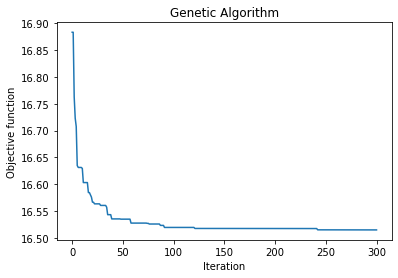

In [91]:
model_ga_top = geneticalgorithm(function=object_function_top,
                                dimension=12,
                                variable_type='int',
                                variable_boundaries=varbound,
                                algorithm_parameters=algorithm_param)

model_ga_top.run()

In [92]:
convergence_top = model_ga_top.report
solution_top = model_ga_top.output_dict

print(convergence_top)
print(solution_top)

[16.883131306695546, 16.883131306695546, 16.762484374346162, 16.722868835676, 16.70746256660627, 16.63471046497837, 16.63115990711596, 16.63115990711596, 16.63115990711596, 16.63115990711596, 16.6293289116291, 16.603003594544976, 16.603003594544976, 16.603003594544976, 16.603003594544976, 16.603003594544976, 16.584352394386368, 16.584352394386368, 16.580158397182593, 16.57586784272932, 16.566452290616915, 16.566452290616915, 16.5633392653422, 16.5633392653422, 16.5633392653422, 16.5633392653422, 16.5633392653422, 16.5633392653422, 16.56041045845864, 16.56041045845864, 16.56041045845864, 16.56041045845864, 16.56041045845864, 16.56041045845864, 16.557093725045025, 16.543173041450835, 16.543173041450835, 16.543173041450835, 16.543173041450835, 16.535285356561435, 16.535285356561435, 16.535285356561435, 16.535285356561435, 16.535285356561435, 16.535285356561435, 16.535285356561435, 16.535285356561435, 16.535285356561435, 16.534820858860414, 16.534820858860414, 16.534820858860414, 16.534820

In [93]:
ga_solution = input_conversion(solution_top['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title_mean_enc,category_id_mean_enc
0,7552057.0,262309.0,853640.0,23.0,22.0,28.79069,676.0,43.0,122.0,135.0,143.0,18639195.0,1.553969e+06


In [94]:
channel_title = mean_encode_channel[mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc'])].index[0]
ga_solution_df['channel_title_mean_enc'] = channel_title
ga_solution_df = ga_solution_df.rename(columns={'channel_title_mean_enc': 'channel_title'})

category_id = mean_encode_category[mean_encode_category.isin(ga_solution_df['category_id_mean_enc'])].index[0]
ga_solution_df['category_id_mean_enc'] = category_id
ga_solution_df = ga_solution_df.rename(columns={'category_id_mean_enc': 'category_id'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category_id
0,7552057.0,262309.0,853640.0,23.0,22.0,28.79069,676.0,43.0,122.0,135.0,143.0,FoxStarHindi,10


In [95]:
ga_solution_df['category_id'] = category_id_code[str(ga_solution_df['category_id'][0])]
ga_solution_df = ga_solution_df.rename(columns={'category_id': 'category'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category
0,7552057.0,262309.0,853640.0,23.0,22.0,28.79069,676.0,43.0,122.0,135.0,143.0,FoxStarHindi,Music


In [96]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['Views'] = int(prediction[0])
ga_solution_top = ga_solution_df
ga_solution_top

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,7552057.0,262309.0,853640.0,23.0,22.0,28.79069,676.0,43.0,122.0,135.0,143.0,FoxStarHindi,Music,55131235


#**11. 결과 검토 및 분석: Top YouTuber**

In [97]:
df_rgb2.describe()

,category_id,views,likes,dislikes,comment_count,r_avg,g_avg,b_avg,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
count,6558.000000,6.558000e+03,6.558000e+03,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6.558000e+03,6558.000000,6558.000000,6.558000e+03,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6.558000e+03,6.558000e+03
mean,21.148216,3.702816e+05,1.533824e+04,522.017993,2374.226593,94.588442,87.229643,85.689235,2.541476,1.586026e+04,21.616956,107.952186,7.277071e+03,50.902485,1085.683883,9.780098,432.711040,43.321134,3.702816e+05,3.702816e+05
std,6.779788,1.662346e+06,1.036956e+05,11337.747492,18748.472408,31.165412,29.405352,29.578320,12.456900,1.086795e+05,17.978007,419.561007,4.705238e+04,195.772203,7539.910674,48.145208,537.183225,19.539754,1.361084e+06,3.700064e+05
min,1.000000,2.623000e+03,2.000000e+00,0.000000,0.000000,6.000000,6.000000,4.000000,1.000000,2.000000e+00,1.000000,0.161180,3.703704e-02,0.012151,0.000000,0.185734,1.000000,4.000000,2.623000e+03,2.332710e+04
25%,20.000000,4.455550e+04,6.780000e+02,20.000000,150.000000,74.000000,68.000000,66.000000,2.000000,7.352500e+02,8.000000,14.211516,3.325417e+02,6.400000,66.500000,2.795164,120.000000,28.000000,6.107850e+04,1.309392e+05
50%,24.000000,9.915450e+04,2.019500e+03,54.000000,429.000000,95.000000,87.000000,84.000000,2.000000,2.137500e+03,17.000000,35.212064,9.958333e+02,16.478125,199.000000,5.143421,260.000000,41.000000,1.232558e+05,2.772646e+05
75%,25.000000,2.330775e+05,4.765000e+03,142.000000,1086.750000,116.000000,106.000000,105.000000,2.000000,4.921000e+03,30.000000,78.976690,2.398500e+03,37.797115,520.625000,9.075080,535.000000,55.000000,2.420690e+05,4.091292e+05
max,43.000000,6.279639e+07,4.470923e+06,884965.000000,905925.000000,201.000000,188.000000,188.000000,706.000000,4.589976e+06,126.000000,5325.750000,1.529992e+06,2662.875000,301975.000000,1071.000000,5235.000000,100.000000,5.261173e+07,1.678646e+06


In [98]:
inf_input = copy.deepcopy(model_ga_top)

comment_count_dep_top = []

for i in tqdm.tqdm(range(df_rgb2['comment_count'].min(), df_rgb2['comment_count'].max(), 1000)):    
    inf_input.output_dict['variable'][2] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    comment_count_dep_top.append([i, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 906/906 [00:15<00:00, 56.91it/s]


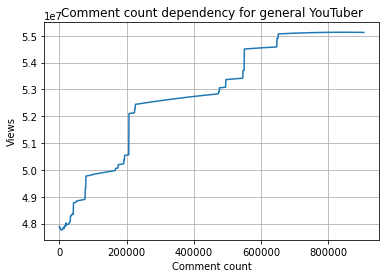

In [99]:
comment_count_dep_top_df = pd.DataFrame(comment_count_dep_top, columns=['comment_count', 'views'])

plt.title('Comment count dependency for general YouTuber')
plt.xlabel('Comment count')
plt.ylabel('Views')
plt.grid()
plt.plot(comment_count_dep_top_df['comment_count'], comment_count_dep_top_df['views'])

In [100]:
inf_input = copy.deepcopy(model_ga_top)

positive_ratio_dep_top = []

total_sign = inf_input.output_dict['variable'][0] + inf_input.output_dict['variable'][1]
calculation_plot = 500
step = total_sign / calculation_plot

for i in tqdm.tqdm(np.arange(1, total_sign, step)):    
    inf_input.output_dict['variable'][0] = int(i)
    inf_input.output_dict['variable'][1] = total_sign - int(i)
    ratio = inf_input.output_dict['variable'][0] / inf_input.output_dict['variable'][1]

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    positive_ratio_dep_top.append([ratio, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 58.96it/s]


<BarContainer object of 500 artists>

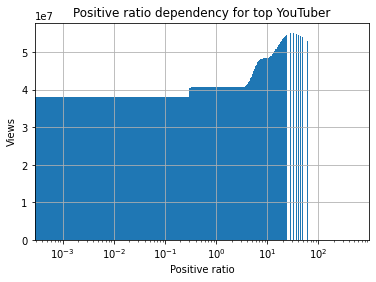

In [101]:
positive_ratio_dep_top_df = pd.DataFrame(positive_ratio_dep_top, columns=['positive_ratio', 'views'])

plt.title('Positive ratio dependency for top YouTuber')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.xscale('log')
plt.grid()
plt.bar(positive_ratio_dep_top_df['positive_ratio'], positive_ratio_dep_top_df['views'])

In [102]:
inf_input = copy.deepcopy(model_ga_top)

number_of_tag_dep_top = []

for i in tqdm.tqdm(range(df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max())):    
    inf_input.output_dict['variable'][4] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    number_of_tag_dep_top.append([i, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 62.88it/s]


<BarContainer object of 125 artists>

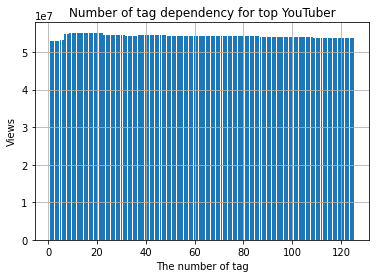

In [103]:
number_of_tag_dep_top_df = pd.DataFrame(number_of_tag_dep_top, columns=['number_of_tag', 'views'])

plt.title('Number of tag dependency for top YouTuber')
plt.xlabel('The number of tag')
plt.ylabel('Views')
plt.grid()
plt.bar(number_of_tag_dep_top_df['number_of_tag'], number_of_tag_dep_top_df['views'])

In [104]:
inf_input = copy.deepcopy(model_ga_top)

random_image_dep_top = []

for i in tqdm.tqdm(range(2000)):    
    inf_input.output_dict['variable'][7] = randint(df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max())
    inf_input.output_dict['variable'][8] = randint(df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max())
    inf_input.output_dict['variable'][9] = randint(df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max())
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    random_image_dep_top.append([i, int(prediction)])

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 58.08it/s]


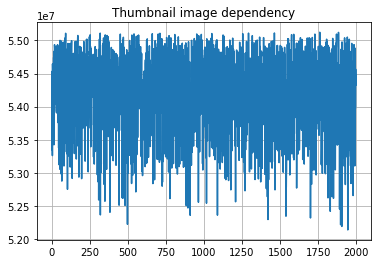

In [105]:
random_image_dep_top_df = pd.DataFrame(random_image_dep_top, columns=['Random_image', 'Views'])

plt.grid()
plt.title('Thumbnail image dependency')
plt.plot(random_image_dep_top_df['Random_image'], random_image_dep_top_df['Views'])

Average views: 54137496.8175
Median views: 54169204.0
Standard deviation of views [count]: 601628.975826502
Standard deviation of views     [%]: 1.1112981042596428


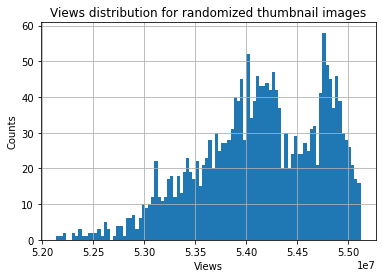

In [106]:
plt.grid()
plt.title('Views distribution for randomized thumbnail images')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.hist(random_image_dep_top_df['Views'], bins=96)

print('Average views:', random_image_dep_top_df['Views'].mean())
print('Median views:', random_image_dep_top_df['Views'].median())
print('Standard deviation of views [count]:', random_image_dep_top_df['Views'].std())
print('Standard deviation of views     [%]:', random_image_dep_top_df['Views'].std()*100 / random_image_dep_top_df['Views'].mean())

In [107]:
inf_input = copy.deepcopy(model_ga_top)

channel_title_dep_top = []

for i in tqdm.tqdm(range(len(mean_encode_channel))):
    inf_input.output_dict['variable'][10] = i 
    
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    channel_title_dep_top.append([mean_encode_channel.index[i], int(prediction)])

100%|██████████████████████████████████████████████████████████████████████████████| 1478/1478 [00:26<00:00, 56.42it/s]


<BarContainer object of 1478 artists>

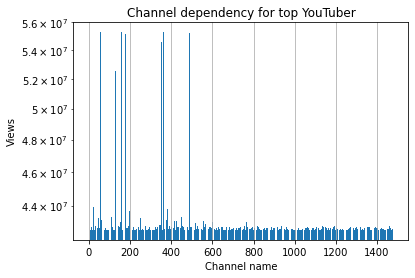

In [108]:
channel_title_dep_top_df = pd.DataFrame(channel_title_dep_top, columns=['channel_title', 'views'])

plt.title('Channel dependency for top YouTuber')
plt.xlabel('Channel name')
plt.ylabel('Views')
plt.yscale('log')
plt.grid()
plt.bar(range(len(channel_title_dep_top_df['channel_title'])), channel_title_dep_top_df['views'])

In [109]:
channel_title_dep_top_df.sort_values(by='views', ascending=False).head(10)

,channel_title,views
159,Dude Perfect,55285374
123,ChildishGambinoVEVO,55284957
548,TaylorSwiftVEVO,55282881
502,Sony Pictures Entertainment,55282601
363,Marvel Entertainment,55280144
99,Bruno Mars,55279408
57,AsapSCIENCE,55275466
677,ibighit,55272291
53,ArianaGrandeVevo,55269990
489,SelenaGomezVEVO,55258163


Average views: 43000614.06495264
Median views: 42695250.5
Standard deviation of views [count]: 1731668.0862873632
Standard deviation of views     [%]: 4.027077575384551


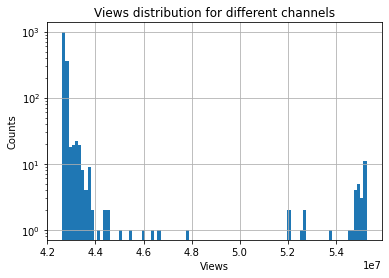

In [110]:
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_top_df['views'], bins=96)

print('Average views:', channel_title_dep_top_df['views'].mean())
print('Median views:', channel_title_dep_top_df['views'].median())
print('Standard deviation of views [count]:', channel_title_dep_top_df['views'].std())
print('Standard deviation of views     [%]:', channel_title_dep_top_df['views'].std()*100 / channel_title_dep_top_df['views'].mean())

In [111]:
df_rgb2.sort_values(by='views', ascending=False).head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg,publish_time2,publish_date,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
5568,7C2z4GqqS5E,2018-05-20,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",62796390,4470923,119053,905925,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,96,121,122,2018-05-18,2018-05-18,3,4589976,8,37.554056,1.529992e+06,12.518019,301975.000000,5.066618,784,35,1.517593e+07,1.553969e+06
812,FlsCjmMhFmw,2017-12-08,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",52611730,1891832,884965,702790,https://i.ytimg.com/vi/FlsCjmMhFmw/default.jpg,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",73,76,75,2017-12-06,2017-12-06,3,2776797,37,2.137748,9.255990e+05,0.712583,234263.333333,3.951105,710,50,5.261173e+07,4.091292e+05
4361,i0p1bmr0EmE,2018-04-14,TWICE What is Love? M/V,jypentertainment,10,2018-04-09T08:59:51.000Z,"TWICE What is Love|""TWICE What is Love?""|""TWIC...",38840787,1111599,96407,206639,https://i.ytimg.com/vi/i0p1bmr0EmE/default.jpg,False,False,False,TWICE(트와이스) What is Love? M/V\n\nSpotify https...,94,92,97,2018-04-09,2018-04-09,6,1208006,35,11.530273,2.013343e+05,1.921712,34439.833333,5.845973,498,23,6.841438e+06,1.553969e+06
555,6ZfuNTqbHE8,2017-11-30,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24,2017-11-29T13:26:24.000Z,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",37736281,1735938,21972,241242,https://i.ytimg.com/vi/6ZfuNTqbHE8/default.jpg,False,False,False,There was an idea… Avengers: Infinity War. In ...,74,64,49,2017-11-29,2017-11-29,2,1757910,11,79.006827,8.789550e+05,39.503413,120621.000000,7.286915,448,55,1.293744e+07,4.091292e+05
4723,u9Mv98Gr5pY,2018-04-25,VENOM - Official Trailer (HD),Sony Pictures Entertainment,24,2018-04-24T03:45:03.000Z,"Venom|""Venom Movie""|""Venom (2018)""|""Marvel""|""M...",27973210,850377,26543,96767,https://i.ytimg.com/vi/u9Mv98Gr5pY/default.jpg,False,False,False,We Are #Venom. 10.5.18\n\nOne of Marvel's most...,44,39,27,2018-04-24,2018-04-24,2,876920,24,32.037712,4.384600e+05,16.018856,48383.500000,9.062180,493,29,1.315249e+07,4.091292e+05
3642,QwievZ1Tx-8,2018-03-17,Marvel Studios' Avengers: Infinity War - Offic...,Marvel Entertainment,24,2018-03-16T13:02:41.000Z,"marvel|""comics""|""comic books""|""nerd""|""geek""|""s...",19716689,975760,9120,127045,https://i.ytimg.com/vi/QwievZ1Tx-8/default.jpg,False,False,False,In theaters April 27. Get your tickets now: ht...,103,94,86,2018-03-16,2018-03-16,2,984880,16,106.991228,4.924400e+05,53.495614,63522.500000,7.752214,474,57,1.293744e+07,4.091292e+05
4758,rRr1qiJRsXk,2018-04-25,Sanju | Official Teaser | Ranbir Kapoor | Rajk...,FoxStarHindi,24,2018-04-24T07:58:08.000Z,"Sanju Teaser|""Official Teaser""|""Sanju Official...",18639195,511785,15607,32435,https://i.ytimg.com/vi/rRr1qiJRsXk/default.jpg,False,False,False,Few lives in our times are as dramatic and eni...,105,111,121,2018-04-24,2018-04-24,2,527392,23,32.792016,2.636960e+05,16.396008,16217.500000,16.259966,1414,57,1.863920e+07,4.091292e+05
844,vn9mMeWcgoM,2017-12-09,Jurassic World: Fallen Kingdom - Official Trai...,Universal Pictures,24,2017-12-08T01:44:25.000Z,"Jurassic World|""Fallen Kingdom""|""Jurassic Park...",18184886,399208,17473,58902,https://i.ytimg.com/vi/vn9mMeWcgoM/default.jpg,False,False,False,Jurassic World: Fallen Kingdom\nIn Theaters Ju...,52,60,62,2017-12-08,2017-12-08,2,416681,22,22.847136,2.083405e+05,